<h1 style=\"text-align: center; font-size: 50px;\">🖼️ Image Super Resolution with FSRCNN Model </h1>

In this template, our objective is to increase the resolution of images (i.e., increase the number of pixels) using the FSRCNN model. This convolutional neural network model offers greater run-time speed, taking a low-resolution image as input and returning a higher-resolution image that is x times larger.

# Notebook Overview
- Imports
- Configurations
- Model architecture and implementation
- Dataloader / preprocessing
- Training and Validation
- Inference
- HR and LR image comparasion

## Imports

In [1]:
# ------------------------ Standard Library Imports ------------------------
import logging
from datetime import datetime
from pathlib import Path
import argparse
import os
import copy
import time
import warnings
import pandas as pd

# ------------------------ Third-Party Libraries ------------------------
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import tensorflow as tf
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import base64
import io
from io import BytesIO



# ------------------------ MLflow for Experiment Tracking and Model Management ------------------------
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec, TensorSpec, ParamSchema, ParamSpec

2025-06-26 18:11:06.429921: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 18:11:07.675639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750961468.035665     267 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750961468.151989     267 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-26 18:11:09.156124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Configurations

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Create logger
logger = logging.getLogger("super_resolution_logger")
logger.setLevel(logging.INFO)

formatter = logging.Formatter(
    "%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S"
)

stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False

In [4]:
# ------------------------ MLflow Integration AND MODEL NAME------------------------
PROJECT_NAME = "super_resolution"
RUN_NAME = "fsrcnn_main"
MODEL_NAME = "fsrcnn"
MLFLOW_EXPERIMENT = "Super Resolution 4x"
# ------------------------- Paths -------------------------
TENSORLOGS_PATH = "/phoenix/tensorboard/tensorlogs"
TRAIN_PATH = "/home/jovyan/datafabric/DIV2K/DIV2K_train_HR/"
VALIDATION_PATH = "/home/jovyan/datafabric/DIV2K/DIV2K_valid_HR/"
BEST_MODEL_PATH = "best_model.pth"
MODEL_PATH = "FSRCNN_300_epochs.pt"

os.environ["TENSORBOARD_LOGDIR"] = "/phoenix/tensorboard"

In [5]:
logger.info("Notebook execution started.")

2025-06-26 18:11:19 - INFO - Notebook execution started.


In [6]:
start_time_all_execution = (
    datetime.now()
)  # This variable is to help us to see in how much time this notebook will run

### Verify Assets

In [7]:
def log_asset_status(
    asset_path: str, asset_name: str, success_message: str, failure_message: str
) -> None:
    """
    Logs the status of a given asset based on its existence.

    Parameters:
        asset_path (str): File or directory path to check.
        asset_name (str): Name of the asset for logging context.
        success_message (str): Message to log if asset exists.
        failure_message (str): Message to log if asset does not exist.
    """
    if Path(asset_path).exists():
        logger.info(f"{asset_name} is properly configured. {success_message}")
    else:
        logger.info(f"{asset_name} is not properly configured. {failure_message}")


log_asset_status(
    asset_path=TRAIN_PATH,
    asset_name="Train data",
    success_message="",
    failure_message="Please create and download the required assets in your project on AI Studio.",
)
log_asset_status(
    asset_path=VALIDATION_PATH,
    asset_name="Validation data",
    success_message="",
    failure_message="Please create and download the required assets in your project on AI Studio.",
)

2025-06-26 18:11:19 - INFO - Train data is properly configured. 
2025-06-26 18:11:19 - INFO - Validation data is properly configured. 


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Model architecture and implementation
The FSRCNN model works as follows:
- Low Resolution (LR) image as input
- Feature extraction
- Shrinking
- Non-Linear mapping
- Expanding
- Decovolution
- Super resolution (SR) image as output

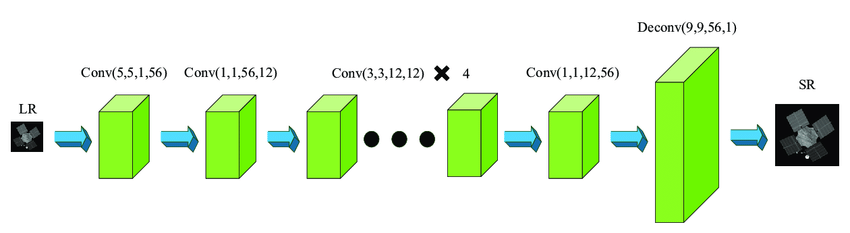


In [9]:
class FSRCNN(nn.Module):
    """
    A class for building the architecture of the FSRCNN model.
    """

    def __init__(self, scale_factor):
        """
        Initializes the FSRCNN.
        Args:
            scale_factor: The factor by which to upscale the image.
        """
        try:
            super(FSRCNN, self).__init__()
            self.scale_factor = scale_factor

            self.feature_extraction = nn.Sequential(
                nn.Conv2d(3, 56, kernel_size=5, padding=2), nn.PReLU()
            )
            self.shrinking = nn.Sequential(nn.Conv2d(56, 12, kernel_size=1), nn.PReLU())
            self.non_linear_mapping = nn.Sequential(
                nn.Conv2d(12, 12, kernel_size=3, padding=1),
                nn.PReLU(),
                nn.Conv2d(12, 12, kernel_size=3, padding=1),
                nn.PReLU(),
                nn.Conv2d(12, 12, kernel_size=3, padding=1),
                nn.PReLU(),
                nn.Conv2d(12, 12, kernel_size=3, padding=1),
                nn.PReLU(),
                nn.Conv2d(12, 12, kernel_size=3, padding=1),
                nn.PReLU(),
            )
            self.expanding = nn.Sequential(nn.Conv2d(12, 56, kernel_size=1), nn.PReLU())
            self.deconvolution = nn.ConvTranspose2d(
                56,
                3,
                kernel_size=9,
                stride=scale_factor,
                padding=4,
                output_padding=scale_factor - 1,
            )

            logger.info("FSRCNN initialization done successfully")

        except Exception as e:
            logger.error(f"Error initializing FSRCNN: {str(e)}")
            raise

    def forward(self, x):
        """
        Implementation of the FSRCNN logic, in which, the input passes through every step of the arquiteture.
        Args:
            x: Low resolution image.

        Returns:
            x: High resolution image.
        """
        try:
            x = self.feature_extraction(x)
            x = self.shrinking(x)
            x = self.non_linear_mapping(x)
            x = self.expanding(x)
            x = self.deconvolution(x)
            return x
        except Exception as e:
            logger.error(f"Error implementing FSRCNN logic: {str(e)}")
            raise


# Dataloader / preprocessing

In [10]:
class DIV2KDataset(Dataset):
    def __init__(self, img_dir, scale_factor, desired_height, desired_width):
        """
        Initialize the DIV2KDataset

        Args:
            img_dir: Image directory.
            scale_factor: Factor by which to upscale the image.
            desired_height: Desired height of the image.
            desired_width: Desired width of the image.
        """
        try:
            super(DIV2KDataset, self).__init__()
            self.img_dir = img_dir
            self.scale_factor = scale_factor
            self.desired_height = desired_height
            self.desired_width = desired_width
            self.img_list = os.listdir(self.img_dir)

        except Exception as e:
            logger.error(f"Error initializing DIV2KDataset: {str(e)}")
            raise

    def __getitem__(self, index):
        """
        Takes a low resolution and high resolution image at a given index, to resize.

        Args:
            index: Index where the image is located.

        Returns:
            A high resolution image and a low resolution image after the resize.
        """
        try:
            img_hr = Image.open(os.path.join(self.img_dir, self.img_list[index]))

            # Resize image to the desired width and length
            img_hr = img_hr.resize(
                (self.desired_width, self.desired_height), Image.BICUBIC
            )

            # Resize low resolution image according to the scale factor
            img_lr = img_hr.resize(
                (
                    self.desired_width // self.scale_factor,
                    self.desired_height // self.scale_factor,
                ),
                Image.BICUBIC,
            )

            transform = T.Compose(
                [
                    T.ToTensor(),
                    # Compose other transformtion if necessary
                ]
            )

            img_hr = transform(img_hr)
            img_lr = transform(img_lr)

            return img_hr, img_lr

        except Exception as e:
            logger.error(f"Error resizing image: {str(e)}")

    def __len__(self):
        """
        List the number of images

        Returns:
            The number of images.
        """
        return len(self.img_list)


# Training and Validation

In [11]:
class TrainFSRCNN(object):
    def __init__(
        self, model, criterion, optimizer, train_loader, val_loader, n_epochs, device
    ):
        """
        Initialize the TrainFSRCNN.

        Args:
            model: FSRCNN model.
            criterion: Measures the error between the output and the real value.
            optimizer : Adjusts model weights for loss minimization.
            train_loader: Training batches.
            val_loader: Validation batches.
            n_epochs: Number of epochs for the training.
            device: Where the model and data will be processed.
        """
        try:
            self.model = model
            self.criterion = criterion
            self.optimizer = optimizer
            self.train_loader = train_loader
            self.val_loader = val_loader
            self.n_epochs = n_epochs
            self.device = device
            self.log_dir = TENSORLOGS_PATH
            self.mlflow_exp_name = PROJECT_NAME
            self.tb_writer = torch.utils.tensorboard.SummaryWriter()
            self.best_metric = float("inf")
            self.best_epoch = -1

            logger.info("TrainFSRCNN initialization done successfully")

        except Exception as e:
            logger.error(f"Error initializing TrainFSRCNN: {str(e)}")

    def train(self):
        """
        Train the FSRCNN model
        """
        try:
            start_time = time.time()

            writer = SummaryWriter(self.log_dir)
            # mlflow.set_tracking_uri("/phoenix/mlflow")
            # mlflow.set_experiment(self.mlflow_exp_name)

            self.model = self.model.to(self.device)
            self.model.train()

            outer_loop = tqdm(range(self.n_epochs))

            for epoch in outer_loop:
                # for epoch in range(self.n_epochs):
                running_loss = 0.0
                outer_loop.set_description(f"Epoch [{epoch}/{self.n_epochs}]")
                for i, (hr, lr) in tqdm(enumerate(self.train_loader)):
                    hr = hr.to(self.device)
                    lr = lr.to(self.device)

                    self.optimizer.zero_grad()

                    outputs = self.model(lr)
                    loss = self.criterion(outputs, hr)

                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()

                if (epoch) % 10 == 0:
                    self.log_images_to_tensorboard(writer, epoch)

                # Validate on the validation set
                val_loss, val_psnr = self.validate()

                print(
                    "Epoch: %d, Loss: %.3f, Validation Loss: %.3f, Validation PSNR: %.2f"
                    % (
                        epoch + 1,
                        running_loss / len(self.train_loader),
                        val_loss,
                        val_psnr,
                    )
                )

                if running_loss < self.best_metric:
                    torch.save(self.model.state_dict(), BEST_MODEL_PATH)
                    best_metric = running_loss

            writer.close()

            with mlflow.start_run(run_name=RUN_NAME) as run:
                logger.info(run.info.run_id)
                mlflow.log_metric("Training RMSE", running_loss)
                mlflow.log_metric("Validation RMSE", val_loss)
                mlflow.log_metric("Validation PSNR", val_psnr)
                mlflow.register_model(
                    model_uri=f"runs:/{run.info.run_id}/fscnn", name=MODEL_NAME
                )

            # Add a timer to calculate the training time
            end_time = time.time()
            total_time = end_time - start_time

            logger.info("Total time of training: {:.2f} seconds".format(total_time))

        except Exception as e:
            logger.error(f"Error training model: {str(e)}")

    def log_images_to_tensorboard(self, writer, epoch):
        """
        Log images on the tensorboard to monitor model training.

        Args:
            writer: Instance of the tensorboard SummaryWriter class, used to "write" in a format that the tensorboard can "read"
            epoch: Epoch of each image
        """
        self.model.eval()
        try:
            with torch.no_grad():
                # Get a batch from the validation set
                hr, lr = next(iter(self.val_loader))
                hr = hr.to(self.device)
                lr = lr.to(self.device)

                # Forward pass
                outputs = self.model(lr)

                # Convert images to a grid for visualization
                grid_hr = make_grid(hr, nrow=1, normalize=True)
                grid_lr = make_grid(lr, nrow=1, normalize=True)
                grid_sr = make_grid(outputs, nrow=1, normalize=True)

                # Log images to TensorBoard
                writer.add_image(f"Original/Epoch_{epoch + 1}", grid_hr, epoch)
                writer.add_image(f"Low Resolution/Epoch_{epoch + 1}", grid_lr, epoch)
                writer.add_image(f"Super-Resolved/Epoch_{epoch + 1}", grid_sr, epoch)

        except Exception as e:
            logger.error(f"Error logging on tensorboard: {str(e)}")

    def validate(self):
        """
        Validates training by calculating some metrics that were defined.

        Returns:
            Metrics used to evaluate training.
        """
        try:
            self.model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_psnr = 0.0
                val_loop = tqdm(self.val_loader)
                count = 0
                for hr, lr in self.val_loader:
                    hr = hr.to(self.device)
                    lr = lr.to(self.device)
                    outputs = self.model(lr)
                    loss = self.criterion(outputs, hr)
                    val_loss += loss.item()

                    # Calculate PSNR
                    mse = torch.mean((hr - outputs) ** 2)
                    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
                    val_psnr += psnr.item()
                    count += 1
                    val_loop.set_description(f"Validation: Loss = {val_loss / count}")
                val_loop.close()
                return val_loss / len(self.val_loader), val_psnr / len(self.val_loader)

        except Exception as e:
            logger.error(f"Error validating training: {str(e)}")

    def device_validate(self):
        """
        Validation of the used device.

        Returns:
            The device validation
        """
        self.model = self.model.to(self.device)
        return self.validate()


The evaluation parameters used are:
- Loss: Evaluates the error in the data on which the model is learning. A decreasing loss means that the model is learning and improving
- Validation Loss: Evaluates the performance of the model on the validation set. It indicates how well the model can generalize to new data. In this case, it measures the error on the validation data. The lower the validation loss value, the better, meaning that the model is generalizing well.
- Validation PSNR: This is a metric used to evaluate the quality of an image reconstruction compared to the original image in the case of a high-resolution image.

In [12]:
class Args:
    train_dir = TRAIN_PATH
    val_dir = VALIDATION_PATH
    scale = 4
    batch_size = 4
    epochs = 30


args = Args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(device)

mlflow.set_experiment(MLFLOW_EXPERIMENT)

# Load training dataset
train_dataset = DIV2KDataset(args.train_dir, args.scale, 1020, 2040)

# Load validation dataset
val_dataset = DIV2KDataset(args.val_dir, args.scale, 1020, 2040)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)

model = FSRCNN(scale_factor=args.scale)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_fsrcnn = TrainFSRCNN(
    model, criterion, optimizer, train_loader, val_loader, args.epochs, device
)

train_fsrcnn.train()


2025-06-26 18:11:20 - INFO - cuda
2025-06-26 18:11:20 - INFO - FSRCNN initialization done successfully
2025-06-26 18:11:20 - INFO - TrainFSRCNN initialization done successfully


  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.278, Validation Loss: 0.248, Validation PSNR: 6.17


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.232, Validation Loss: 0.205, Validation PSNR: 7.07


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.176, Validation Loss: 0.120, Validation PSNR: 9.33


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.069, Validation Loss: 0.041, Validation PSNR: 13.88


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.035, Validation Loss: 0.031, Validation PSNR: 15.15


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.030, Validation Loss: 0.028, Validation PSNR: 15.59


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.028, Validation Loss: 0.027, Validation PSNR: 15.82


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.027, Validation Loss: 0.025, Validation PSNR: 16.02


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.025, Validation Loss: 0.024, Validation PSNR: 16.22


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.025, Validation Loss: 0.023, Validation PSNR: 16.41


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.024, Validation Loss: 0.023, Validation PSNR: 16.60


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.023, Validation Loss: 0.022, Validation PSNR: 16.76


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.023, Validation Loss: 0.022, Validation PSNR: 16.74


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 16.78


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 16.94


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 16.94


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 16.96


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.04


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.09


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.07


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.18


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.17


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.28


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.020, Validation Loss: 0.019, Validation PSNR: 17.28


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.020, Validation Loss: 0.019, Validation PSNR: 17.27


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.020, Validation Loss: 0.019, Validation PSNR: 17.38


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.020, Validation Loss: 0.019, Validation PSNR: 17.39


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.020, Validation Loss: 0.019, Validation PSNR: 17.47


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.019, Validation Loss: 0.018, Validation PSNR: 17.49


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.019, Validation Loss: 0.018, Validation PSNR: 17.62


2025-06-26 20:13:09 - INFO - a6b20e2ce8024fb0bde7012d52bb5464
Successfully registered model 'fsrcnn'.
Created version '1' of model 'fsrcnn'.
2025-06-26 20:13:09 - INFO - Total time of training: 7308.80 seconds


# Inference

In [13]:
torch.save(model.state_dict(), MODEL_PATH)

2025-06-26 20:13:09 - INFO - FSRCNN initialization done successfully


Predicted image torch.Size([3, 4080, 8160])
High Resolution Image torch.Size([3, 255, 510])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 8159.5, 4079.5, -0.5)

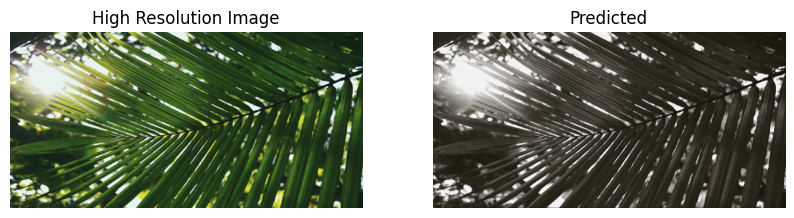

In [14]:
model = FSRCNN(4)
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

x_batch, y_batch = next(iter(val_loader))
x, y = x_batch[0], y_batch[0]
x = x.to(device)
pred = model(x)
pred = pred.cpu()
print("Predicted image", pred.shape)
print("High Resolution Image", y.shape)

# Convert tensors to numpy arrays
y = y.numpy().transpose(1, 2, 0)
pred = pred.detach().numpy().transpose(1, 2, 0)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(y)
axes[0].set_title("High Resolution Image")
axes[0].axis("off")

axes[1].imshow(pred)
axes[1].set_title("Predicted")
axes[1].axis("off")


# HR and LR image comparasion

High Resolution image torch.Size([1020, 2040, 3])
Low Resolution image torch.Size([255, 510, 3])


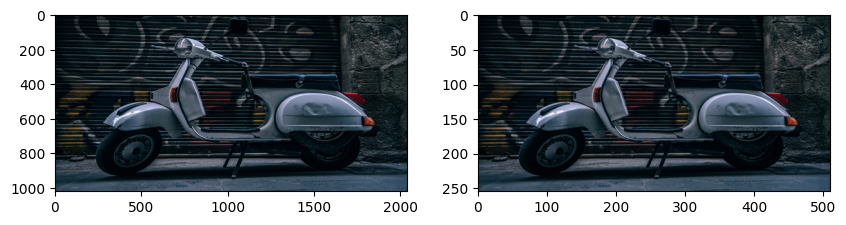

In [15]:
def train_imgs_visualization():
    """
    Does the plot for the training image
    """
    for imgs in train_loader:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        print("High Resolution image", img1.shape)

        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        print("Low Resolution image", img2.shape)
        break


def val_imgs_visualization():
    """
    Does the plot for the validation image
    """
    for imgs in val_loader:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)

        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        break


train_imgs_visualization()

## Logging Model to MLflow

In [16]:
class FSRCNNModel(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        """
        Load model.
        """
        try:
            # Load the model
            model = FSRCNN(4)
            model.to(device)
            model_path = context.artifacts["fsrcnn_model"]
            model.load_state_dict(torch.load(model_path))
            model.eval()
            
            self.model = model


        except Exception as e:
            logger.error(f"Error loading context: {str(e)}")
            raise

    def preprocess_image(self, base64_str):
        # Decode base64 string to image tensor
        img_data = base64.b64decode(base64_str)
        img = Image.open(BytesIO(img_data)).convert("RGB")
        img_np = np.array(img).astype(np.float32) / 255.0
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0)
        return img_tensor

    def postprocess_image(self, output_tensor):
        # Convert output tensor to base64 string
        output_np = output_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
        output_img = (output_np * 255).clip(0, 255).astype(np.uint8)
        output_pil = Image.fromarray(output_img)
        buffer = BytesIO()
        output_pil.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")

    def predict(self, context, model_input):
    
        try:
            results = []
            for base64_str in model_input["image"]:
                input_tensor = self.preprocess_image(base64_str).to(device)
                with torch.no_grad():
                    output_tensor = self.model(input_tensor)
                output_base64 = self.postprocess_image(output_tensor)
                results.append(output_base64)
            return results

        except Exception as e:
            logger.error(f"Error performing prediction: {str(e)}")
            raise
    
    @classmethod
    def log_model(cls, model_name):
        """
        Logs the model to MLflow with appropriate artifacts and schema.
        """
        try:
            # Define input and output schema
            
            input_schema = Schema([ColSpec("string", "image")])

            output_schema = Schema([ColSpec("string", name = "prediction")])

            # Define model signature
            signature = ModelSignature(inputs=input_schema, outputs=output_schema)
            
            # Log the model in MLflow
            mlflow.pyfunc.log_model(
                model_name,
                python_model=cls(),
                artifacts={
                    "fsrcnn_model": MODEL_PATH,           
                },
                signature=signature,
                pip_requirements = [
                "torch",
            ]

            )
        except Exception as e:
            logger.error(f"Error logging model: {str(e)}")
            raise   

/opt/conda/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:168: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [17]:
logger.info(f"Starting the experiment: {MLFLOW_EXPERIMENT}")

# Set the MLflow experiment name
mlflow.set_experiment(experiment_name=MLFLOW_EXPERIMENT)

# Start an MLflow run
with mlflow.start_run(run_name=RUN_NAME) as run:
    # Print the artifact URI for reference
    logging.info(f"Run's Artifact URI: {run.info.artifact_uri}")

    # Log the model to MLflow
    FSRCNNModel.log_model(model_name=MODEL_NAME)

    # Register the logged model in MLflow Model Registry
    mlflow.register_model(
        model_uri=f"runs:/{run.info.run_id}/{MODEL_NAME}", name=MODEL_NAME
    )

logger.info(f"Registered the model: {MODEL_NAME}")

2025-06-26 20:13:17 - INFO - Starting the experiment: Super Resolution 4x


Registered model 'fsrcnn' already exists. Creating a new version of this model...
Created version '2' of model 'fsrcnn'.
2025-06-26 20:13:23 - INFO - Registered the model: fsrcnn


## Fetching the Latest Model Version from MLflow

In [18]:
# Initialize the MLflow client
client = MlflowClient()

# Retrieve the latest version of the model
model_metadata = client.get_latest_versions(MODEL_NAME, stages=["None"])
latest_model_version = model_metadata[0].version  # Extract the latest model version

# Fetch model information, including its signature
model_info = mlflow.models.get_model_info(
    f"models:/{MODEL_NAME}/{latest_model_version}"
)

# Print the latest model version and its signature
logger.info(f"Latest Model Version: {latest_model_version}")
logger.info(f"Model Signature: {model_info.signature}")

2025-06-26 20:13:23 - INFO - Latest Model Version: 2
2025-06-26 20:13:23 - INFO - Model Signature: inputs: 
  ['image': string (required)]
outputs: 
  ['prediction': string (required)]
params: 
  None



## Loading the Model and Running Inference

2025-06-26 20:13:23 - INFO - FSRCNN initialization done successfully


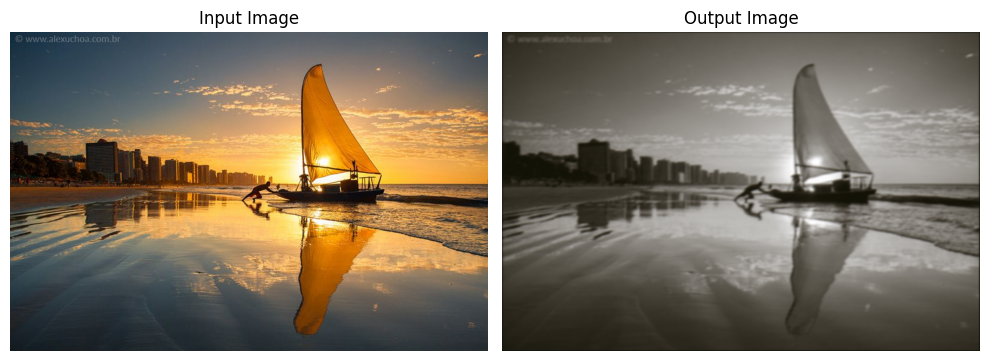

In [19]:
# Load the model
model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{MODEL_NAME}/{latest_model_version}"
)

# Your base64 image
image_base64 = "/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wgARCAIWAyADASIAAhEBAxEB/8QAGwAAAgMBAQEAAAAAAAAAAAAAAQIAAwQFBgf/xAAaAQEBAQEBAQEAAAAAAAAAAAAAAQIDBAUG/9oADAMBAAIQAxAAAAHwdtfQ7+fEuqxcR6JOdN6pjs1uvPO1jC26tMh3quOaiZZ0BGF72Mh34gGGgTIhhUEwBJBGkCEqIxBCQQkEaSiNARiKSRYxlWMRY0FjQWMVSPBIxEjgUPBI0RI8EjwrjyVI4EjwQOEQOKSMBIwEDhEDgQOBA4EDiue6nfMyEjCUWVgwGGgNEqYJBDJAwFSykkJAYYBJVSSAkgJkAkqpaAjRQSYUkisSKWkqloKWgIxVYxhCxEjlUFgFFkiuOSuPBBZCuPBI8EFgElgEFgEFgEDwrFi2ViwFYcIgeFYtSkDRKw8WsOE55h6cwYwDCQwhBJIYQwgMKgkgMMAkkMIDCAkqCSAkywNAEmURiLGII0gElVLQBJVY8hSxVSxhC8FjyVC8Ky8VI8hJZCuPCuWQrlkWsWRKxYBI8Ky0EDgQOLEDgrFi2IHCVhxSK4EDqi68unOhmKVzjD24QwkhICSoMJISAwgJhDDEMJISAmLDGATIkJIYZQSQElQSYEZlQkwpYqpYiljKpYqscwhZpULyVDZFrLyEjwQV8fG+hpxb+XVpZPRwqloisWwqFoquWArml83GLBqViwJWLBZWtqlYsFiJYtlYcWVhwiK4pA4Kw4TnGP05oSQEmgTCGGASQQkBJAYSQlZCQEmAYSGEhhlhJASZQSQEtKpsWUEkBYqpZpULmVC5lQuZULmVCxVSxhC8lrW7lHOO2v5f0dtuK3Gt8sn1/mVSyFUshVLIVSyFceLWLAlcdSsWCyoWrZWti2VratzULFsrDiysOKRbAViwJyzD15QwkMYBJBGgCSCEgJICTKCSAmAJMAkgJKgkgaGWEk0LUcbaRytrLpc561XPpgmq6sJs0RmnVnPpzR2sRjPRsOXOlQZW6XPVSxsQuYr4XoPL8+vQJnx/pKlhs6L5d/2fl0y0alQthULYVSwFYteMw2WS85dlGpStq6xWHWkWxbmtbBZWtgsqFgqoWhKhapWLAnHaH0cIYSGGISQElQTCMCSEgYGCQyyNBSSAkxISoJYYBs3RUpmpYl4NWJs616ea3PfQ2coc+nabiHF6Wjitb6avz0xeq2HTLopxLprqIqDddlyT2aDmNeu5n8h7HxvHr2GW35f0KS4QdzhdT3eXQLR6/LULRVQthULAS/MJdGNhZWti6yiuLKxYtla2iyoWCqhaEqFoKRatlQtUrWxbOMSfT5Q0JDCQwrDDEMYBMIY0ojEBJASVEYiljAJICTKCxVSxhWYyhic6DEzQsD51qy2tz3S+rdjfI6enDz1TR1LzjP0GXnr2BLzV7KpyL3sWivWJcnife+DxvqX5tXz/AGRLlxqtwvTHolp1/T8FS3PqZTYotVq1UtssoFi2VrYtiLYtiLYErlgqsWgqFgStbQVLaTOLU1KlsS54pJ9fkDQkMYBJUEmASQEkBJUNGgEkBJlBYiliKzGVSzSqWaVGc5qlzNKWMqljNAk5sMMtllJzsNGizXimda2o2Y1l0ssXzO2brOGyNS1WZuT599G+cN9PVl0+D12NDz3WLFR/T+U7Xr8/XosHp8+dNtkcujs1Ncu3Y2s87Wcy6Kcu+5x0dvPnXKo65s41nUpXAuy+znttz2Pbk140MXVyy85O8ZfN5e3h7c+FYG9vjol2nWeeewcb4p6OrWOKdlHTnWb67FJNgLFQSYBYqtgszQrPKjMQFmzpGYisxzpWYyqWaVSxmlLNmoXMqFzNIWMqksKxaUEtNBi2arFpVLNkrM8tHzn6X82l6d+fT4fVphPHogK0SGs9NOV2vo+LOmlN5zpcLM77Wk59fSWXlnpizlN01ql8imp+Whs189DQcV0tpkzrBuSneWJzxvx0SXyzR/rfLaxn5daLJNZre5pabLbMdK6OhXFVgvly2X0Wako1Y2lOiu5vfCy7MrMiR21ENrZtLXWTWY6xm5zqWWg6IUNYBWJlBY50pskqFytZsK1tdZlmbRbLkOiS0tfIqbQ2VDWHLP8ANfp/zC3obMe/yeu2xrPNvKumjQGOL6Pz9vbj6KFfZ5a6NQ1clulEoFla1LYxQmqw5y7ZWe2yuKUuzKQ5uVrtrWrPpTecydN5eKvUy6nmbPL0/S+d62/x3os3pWJZz3LY3PpGFudkE50XqvlFb5zTX4VevL1fN82OufpdvzA8t/ULfN+g8/e56pz0y2SarI2S5rXqzdSpJLmpZDasszsG64R7JnVlFshbUW241sWMipolLZW2ZWi2R5GKvMiPazT8u+tfK9dNG7Hu8fs3WG3xaoydOi3A4nXUDBOl1/K+j9nj01WL15BRVdXJXWty0LUjJbeKqkteh6bNcZcdtpSiMaQK1i5L6dS015j5pmvp+p89uhg0r7CzmZeV7tnmbZfSzxmzPT1lvA6PLprsxzLdkw32eGsqf6HjaCBBWa7ve8hX5vT9Fs+eWcteh7nzb3EvoRRZ4/THraLVJRLGOdICdZcMZUcsGRpCjSxSToSkLpS8jMjQ5SZlrV2TFpFvXk3y/wCp/PO2uf3vN+u+b77Lqeh58Z6d1McnJ1OZfQxz2609uWanrJwux6/CwSBUK1KrhVK3VWmtjVTGyymvXmEruWqqtlepkl91mKrfXZgXbXvPympq/p+G6s2Rna+mzTRGmtGnkPL066LTXz7tVnO6WzLx6810b0eeMjkBU1035+fXVfTpzeX3+A819K+b+g83w6bPYeH9XNekwcDi8tfQeh8708t/QW8Bml+kN4z0vDe9sGjC8lkqNk2rNhsrZjSljMqWaRGdpkWGzpzNos9fFvJew8H6nmPa+K9X8X6PoOnn2/U+dn5XX4/zuuLndPD836XMq08L2a7R5fQzW9BwrZn0gD9fHWtguqpYLoKwpUsFtYcVWWUIC2W1CClkJRaTHNIr4xVcv3flFZbLWQheVOdUMs3i22t8aruzGz0ePHk49r3oPfhogsFWxbNOd7uXY2Utc1GnTndKial3Q5+3l0zFW6Y21W1ebtWtnoc65Ytoxsd7zurU+haPmHrfF07lnguoeuPmao9YfM3R6E83o8oxDZyXD6w1q2dub3VW+/jZ5b03hfSr4HqeV8n6G/ZVt8VwU7zrPDr9O/d5TP7TxXacj0OL0Gdc3WavL6Nnc8f1dce0rDnhQRrQBGqIRaFYUoZVUMtAEWARSQKFQsfIDor/AEPybM/Rzc+mWdiu556dCLiXo0TVSalKqNNlzjp6K6mK7XXm5bLCl1dssx9PE+dQUtR10JnRitV+rDby6Gwtm3rnONP7zwXZ8vdcdte5n0I3bnTqpZX0Z7uW5YjaPbTZF/Y4fQ4bnpvJpiek7/zv2HLHYs4l7j2LeRb6ufP+Q/Z/knrepRvUef0Tp66O3n23cLH6uXp6vI+A56+tfM/LU537z1fyr6d4dtzN3A5b9fz9PF469SuJeO9wwrbvGBd3oLgXV6A566vRHPC7xzwbxzxXQXAtdBcCpvTEleJLn6vjVXgA0FMKCu4VQ9hIlklrtQ0zViLZUC4VNTRDcwg2PJfCOcmN6bce3OuhdzDy30U5ti6zk6llNgcC23WU07xHKu33acenvW2cTV2LM3ieU3+V9HNj7btYc7V5bVjXW63zPN05/VLvBPx6ew+cdnzvfj1/bfMutL9Z+ZbuRz3grqX2+a7Zy+hm85GTcu938/0Y16ujzNcvpel4Vbn6fXT6LwezhV9wS8RezNTg1+gFnAbtU2ck9OrU5tXaJx17OezmU9xbOPOwlccdJdZ85Ad5YQBkNAgkkiAk0CWSuXmzPNFdyhVhjWK0W5zz3ps59kWPh046Ln6mKWvcvS5dOONubpi1Nyebtzvc+P6vHpmzak0xbaeh1wveydfydMGjJtzpV2tc8jzfpNvp5eMz/QeZdeW94mjEi8dDN5L2vK78/Ezr0+7zc09TPrOWanzci70XANiaxlGpLKUuFVC1yg2SXR1R6rz9eJX6TJz6cEdjmdMBaMh0q6YC7HVrPTt88h6K/wAuD1rePkvtbvBg99k8Y1ns6PKNc9KXHriksUVtOiMb3V41Fv1S4LNLY3hq7VubyaO3ix083YH9nlCsUtqdZqw2Pz6i5dGLx756aa5HI+jeW5b4/oKvU434ej3+XWfOV+u2efr4C32y6nm9nf1cOnkur2LcyjW54zDfdLQHjK+e9INPn09D8792fY+08t2PI5mDrno4Byeh9fPl2+k0c9eR53vOYeb6fb1c75er6B5yzy69+vPTi0eiz14+j0Gb18cfoMHUzc9O+3Nw9nLnj1FfLo5a7NPHvt11Z0svyvaYJrfU5SdYWcxurjOZk7qbnn8/p5vPlafWTWPIN6qvefO0aB14J0s3ezqZ+ynO+ev7lmd+e29Bc7OHqdHGvK2ensPPN3+bHz1g/wBDySKYYhpq89bpef0ecv8AUPy14L1/P9ZNL5X29Xn6eM9XqsXPj6sxcG9mxVhNM6iSw1vDRSghlCEwDITh92WeB431fN2ynSxafMuep2K6t1vr5cPzfsPmV6e26fO6la+V2qe3Pk1a8vm6pmnG5ddWDFj9WOpo5OvU6C3UY1dfm23KXGrG0jtFefpVLga2zUzi67NqxNj3iDLi9PHuW+f0ZvXrx0Z1tsUZ0lOhdTm107Pb4cmjdqzqi6zTz0mlDz3fZgOddAZrsbe2kzV3L0Vaxw83Ywdufn26d3TPNHtM3Pe7bw+z5fRawTFTTnaXQ1F+NqyA0qjkhWx1j2KgbWS6WZ1IUiyVwseppbCkh5JmR6miyK2YzK2cXNW/bnj+Y/XPNdbjM5/k9ntNHLmuHbHm129DRwF563fPPZeZ6626M/UOTp1zO1hftxNeTN2x0G4Ozpns80HN0UVPVzKka8ttWdW2ZENuauuxOV2r+vPzWzq5dZzX4OTrPSz77fT5+VfrJabLMWrYledbm49R181e+XDr0583dbwaJeoMN+ocu7kVTb0WDfZpxrNsry5vRowWF23G2bvt5acu3Xy4TvGrVzynYPHnPe04pqabMYOmOc+ddM85s66L80510GxHN3HE2Wls5jSczZamoOcXWZHTT5nu+S6zFgp349fcSjb4Otb2nlaRZl1qnjdbk+vN+1rs1NNPcy0OH9PiWt1aXDtXV89yfazvz+fX+5w9efm792HeVu5ebefRV4rca3Njqzq4WJY1NyAy3Vazy9Br+h4NdnNWXfSNUuK/oUSm7n0nSzZr9RLrdmaz48nPfSy5j0w2iu2zVs5R49d2fLNZulL2W3ZzLfKZLbK4WNUZbjUZbBWZbXoOdajjObpVbJVaLLY2dV2PgfOtzYrM61NlbGtb4mzrc/PbLfZz3zb/ACvY8fqabsOvh6NuzBd5eu45l5atzovUylqLLpudfTpf2eS5liBZFgUkVEstFA0vKLBz3IvneF7/AD+rz+Mv6/M78mmLTrLsac6e6tY5N/Qt9PnzEZrnWuEazeKn1H0VNLovwJjWumg6lhQpZbVC40qXjMq6ZQ5osoaLTWJbBSC85rF0XZ2xdBzyauRQEKtWW5zGp8jY1tbNfz6MGOd13q+dLbpyc9u7rC6c981VYNWbQbnzeB5n1flNLtGTX5u2qym3z9ba4k1Ik1LGrtLe1dZ7PJle/L0w6pcITgreebbc6rMl2dKmkmUX0jLaBWRpTTahnx9CzePLYPazrjwae5x7x5RKT9L57lCrsHGesRaK4NIQssldq1q8UCLVViPLAXqZbDnSL6klMyFbHqMlpqi6HzTN1tkuzqxHktEle86Gq2891buRozvoWVbfP2oterG7KL65egycrnrsTHolsurbFprgXP4j2XiuudOrHo4dtt2S/wA/V1VZXiGrNvP7++fWbn19uHQXmNb0BTbc159h0w9OmqTRkyJq9NebmTt5cNtX7uJrubDkuW6XTGqrKLCWV5pb8/Mr68/LFH+z8pnQpZEg8QrZEMrxAOKwPEdDYtimxZFppBatYLJU6sytKQAMamseVxLjW0tltT51szS7l1C31QqrXqWuKpehsw6OHZ76a8dO2vNPLevEdFlKbqrnJbsoVLcOg4HOtqastpt8vfQ9bcujhVLHo0dMbejkX2+TVMr2OtK6zfM4s0HKK1pmCahlllwpmpdKQXCoFppCXW4wvQXAM3oJhBdUg6c+CUPr8rmuFgSLYapLaaYt0pJYVZHaqJZKwtsqhbKoWGslhrktrUQ0CgpYa5VkriXtRZnVt+W3Otd+ezl2Zb6M23ma8m8Ouc9Od23mmX06cHp+b0s7pK2nIub0seGrWdSZx1xsu575vOpuz8O91+fR4vVYyTnshVss349H0PFrGWduWtsZl0rSTRGtxrCltPTECpvFq1Sy2UyrjnJfKIXykRaqgIgsAK2SKtnEKTvweJGniCWyIYaAjOssYobGiiV4oHNcLBXC00wulZHAYhWDxCjFAWPSZbWoK7reddje1sszrZnqRFAXpiw1wsakm63nPjfZz4rMbuFZsYABiLYuLdzOHbdfns+d77hSc2yU6vT59Aqnu8lgrllkqBfKIaLMkl315ZLctY1lwosYKLGCrZYK4WSqWWymFsqhaKxFtma+XzsE7cmgkpKlWKOjMkseKRosDIBooVgANFiMVI7IxJIMrVo8SK8UFhrYYqZXasxa1TLYpJUttSRq5VkQwzJC16Wl0NneatiSVgoRec9vD0Xsk+f7XNZH05bfo+G6VHpysVZTBYGLCwbOfnVkqOs2SuFkrllgSDqsQgCoILJFFjRAWSuFgSHJgJDBTEFGKGxorDhArxYNFgYsgwCnCweKyMyONIBwrCCAJWDMhWw1NFprYdq2lsKEKEFcNdjlIWNUSxqzLaa2HKGVlGRaOjmv+d73AHLo0rGs3PQfp/NvNDLdKiWSuFgSFyVyV5WLLJXCyVwtlULZVLLBXKsVQjAAMWBAAwATmyBWKmxopsJUjQBWggYIGCQYsGAA0BosoSxqiXGky2GqWXUtFWLJGiy1yhhmrJY1TFrUkulZlZCtCLEYoR2qK2tSYvNJLcWnPjelq1+b9Gxa7LHV6u/AxZ7fE5SLaaitsrMPEI0UkkBAQQQU0SDyuDxIjgQIWDRYXU30zQEFzzWU2NFlNFKMVA0WK0WDRTBggYAGBiMBRgiMysEgyySBKsKHrDFlNEI5SRYa2HasjxSESQoK00WDmslhqYsNRLUklVXr8/ouuzHn0sCT1+SyVzWXCweJCyIYcpFcpCwJB4sGAARASQBiwMWDRJTRINFCNFhhikJVqJSI0WK0WQ0EGggSslIEsYggIlGKYcoRykLJWRopHNZALEBIKJEhisLDWw8UwZARWWhBAlSEqRihGKmGgCtBCQSwxQPFg0WDFIOaiWyslkrMtgQFgSWPEkNFFrhRI4WK0SUwWDRQNEiYzIQyEEhJJUMkQySwyEkgDJRMiASBaQhkDJIJkJJKEkI8gqyEEhGkIZAtJEMiwSCrJZDJBkhDJRMkQyLJISSWASEEgRIGSUJJBkhGkIZIgkJJASSpJIEkWCSySQgkWCRP/8QAMRAAAQQCAQIFAgcBAAMBAQAAAQACAxEEEhMQIQUUICIxMDIVIzM0QEFQYCRCQyVw/9oACAEBAAEFAkGEhzS31kEDqBY9de3/AI//AOb/ANOIAs7MIjCbThI2hE1MAIbTiQg1MJ0AVbNeLb8RgfmNR7xtsQu7f8eCQvnrZ6WVZ6WUCVZVld1ZuyrIVmr6Wf8AlgP+Uq0QR/A+f5Fdv874/hQ40sylg4v+jM8lEk/8E7JiamOD2fxu1f6Xz/Br1TSCJh2lMcIUYofSjjL3TRcR/wCTdTQ8mUx/MaZ+p9f+v9ekWED+NnH2sb+WYk0EJpqT/hGOY1jqe/sEe/WvVQ6AKvTS1Pqm92Y3q4WGHdn/AAtJtItTY7DcVpbJExoYzcvh1aAtWk8FRQgxiVkRYGiROxZGiLGtTQtC11R4gz1Y53k/vrin6bWFy46JY1p9pXb/AAKHo+Po16NCqpNbHqQEBa0cmuotdGVtFs6WFop+S7gchjBckMT5ZARjxAKVxEfLGGCV7wyCUp/5S8135Ga9tQ3c8bkGEotI6Uj8YH6Poa7R/wBFoTXRtEktj/Jv6+7/AEtke1OcXKyrPpjlewHKkpz3ONIReyIlr+KSUuhKGOE+D3PY9psqT7cL9uPTiu2j9Nf8I2kODrRpot3lho6MDq0WixwAQLgj36CR6MjiflTPPFh/tm9COsT+OWun9FUvgucXf8GBa1oRuDTEInFsTCmwxatiDj5cbiBqfAm45UsbtWseE2ItHEAwxm+GkYgEGhZXH5bD/bNQ6V0ItYj9ouypaIhVarrqelfVpV0ACPQ/5gHS/aX2EAmucxCQ0JJLMkpGxUcklUCNfcD22anFitiyzG6DB/bBN+P7pUqULuOXgXDQMLkWOWrgXLutXLjNayWI3hvl3I4pRh1WqptFBNbsn9kGEoxlMa4EUHVjlGmogTEsaEWWnxOaiO/+eOrXannXMhMQnSOcGupOdZD6QeEZFK5pjwf2wTPTSwiHxhtKzfM5cjCtY3K2MXP25ZkXyJzpVu5QSe0PY4yNjX5NaY9cMITmxhdio8jUSZKGTIAXteeYVyNp00djjWgqVj06BwJYhDYEbijG8LUrU/wG0iB/i0nj2YH6ATUPS1xY5urm+mlu8LlenSPcgwlFrwi0hMa1NijcjBGtWBaMcuA78UYDscknHejAFrs2UOaYnsDZAxzh7WukYC+cJsxBc9pW/cSNTJQV9iLWuftFUlBf0xrSiK9NekGv8d/2YX7ZqCHqwpNXLUlEEIoHVBweONi0NFrytHVxpzGRrlaFI+3cr1ZXwuZyMzyBu4NkkYmvlcnGRBxIdK4FpgR8vZ4U7IPUN7CNFoWoqu+q0WvZ0PaqQbbRju1IaF7HBsbAHaOREYXt2DYSNIU9kQRATRZ/iV9eT9PC/aMQTVSPz1Kx5TNF3K0KLQiu4WslayIsKLStSEWucuMrRFtFsbEWBzeJOiatG03UH8qRz442qth7bMjFuAXPtGTbo00hIFG5gLigUXIvcU2QhchJ5GgOe9yAcBG6YJ1vRagKLXhiLtjqB1B7MbsS2iG2S2iG2tCFxFcaETlxFNjJRjIWhqvUOgVKlSay1xoR9jEhGtCFotCgxBiLaWpTh7cH9H4MaAVIj0xSGGRG1otaVOWrkWuTnOC5XLkdXIne4e8KhYq3NYjSMYX5RAYHJ0SEZCLF8JjolcKcyNyMUSYdkaCEjN6QFrRBiotQYVr3KqwOyFrRq7BB1LZZmZwNh8QJMcjJGOmY1B6uySCAvt6e4kjt/TNb9oDjaDRqHCmo2W8bkI3ItpBhvjRpRi05qAetV3AZ82F360VtS2JHdXSDrJd2wfs+XQ/ICDU4J4roOuDIu10qVUg6lSOqoU4PoiSmiVU+u9HcoEp1lO5WISUt2uXGFxArRrUCnstcS4W0Y2hu5ai8uTHaugyGveCQgtyOmy3QcVsU02g5fccq2Q+dyCjl5BDnOce61cg33eF92NAK17DVNYnRtXEhH21auMFcQWrEONMoLZoXKvlWVs67ctytivcu/QAr3ruge2wVoLugegN9AvlYfZD7o26vaO1Kuzmr7T6MeTljJK7lalalEORtELuVTV7VViyFyOTZEXgr8shjhbixEsXtTHBF9JzwhJSMrac+0746YX7kdey7Fe2xqiNVdoL7TlHbGb8ej+8TJMEkWZBM7nhC3YFJ4lUmO7miFIqum62VrZxWxBLiUC5OsrVaha9tFqtUWrULXpSoLXrSq1qh2QQAWugafZI2k1V0cFI3YIIjpFLwyWSO679Oy7Far2q2IELsVqFqtO7mBGMBFja0CLAFqi1CO0YqWoRCpfAVLGeGTHKiUmW6mZ7rysrZsckrCM2UGHLa93NERyNavMRLz0aLxNjt+PS40rTD7oxyyN+3w03jtdSBV2gQu3QWqXyg3v26hUFasKwrCtWuy7K0KVBUFSpBqDVqgFLF+TGfbL9sTSg0otKc1PClBB2Qd27dMOWj2XZfCv0Ehypqpi0bTWtBPdUKcwIRgjXRxorVClTQiFqtEWq+3agiK6A0t1brZJaAaU5i0co2Pey+9qDKkjDfSVJ0Z92L+sCvDpuPIyO+K1xCZI4LwyV0imlZCpM+FohymSNjLXD59FdKCpUqVKlSpUqVLVarVUgEAgCgmM3nb2kaNnQwlrBGnN7P+Xr/ANnjV2yY9sjUViy8rEelBahahdgjS7IgKmrUKvRfbQFaBUtSnLt0JoDoXBaAoikE77U1bq02dzVCGl/BCRJExrW+i05SfCZ92J+4P3P+cHIZFgtQXhb9H+LyMkm/vB/cvypmMPiE5jOZkFYua9kDMmJzPNQBRzRSfUpV0AQCAQ6HMZieNSyRc3h+UyRscmxsKQ9pEVM2xey8UjcIMAf+LfcJpMb2OD2fwaCIVld0fkp5HQIik00iUBaI6tX9WmykEStbG+ZjmjoPno74k+1M+6J2kgAJlbSaTTUETUDkFhfupfgfppn7LJsPkXhhDZ4po5RafNGwxyNkH0gggh0ja38f8Sxo/PYmJC9Y+BAvLyNVZocZ85qf4g9p/E8co5ONInSsmgxHs3KagQVBJxP/AIlolWg1EHoe6uhaYAuyPzaCFdAjIS1Ap1hNcF2VIjsZA4TxiN7Pucm/B/TamoJ36BQWH+5l+2P4b4eJImisPJ+Xr/13IWRnOiky5jPLjZXBjjxIoeISoeIu1izimZcTnD0BBBBBEgB+djt8b8SmimcPazGfbNrRIsNmkQxZ3L8N2X4Th3PB4dBLjYuJK53hKPh+S1HFzQXx57VgzTfx/gf28U/sCRZ1BWlIx9xG1cPfjNNZ3czZa9zYKC+4N6d077R8ZX3bUt+n/wAwmoJ36K+Fifupkz7cX9uf0clO+P6W5fI77n/ptNn+grTDq/DPbdxZg/ouyH+Z6DoF45C2TGc064nFJ4V7ntxfD5GxtwW3HEyPq9waJc7FjWVjvzZcPw8YuVNLltURy5WwTZb2QCQA/m+K/wAUo2qNuf7CPfVIHt3oManNjTNQ5zE5jNYYiEWELQrWgWaoiy2NalNaQE8Bjn29aOCax7iY37OtBBfCHdaFFhqnbUVTgocwtHL2mdudbX9IAgnuSba0egEXjSNjIc1qn8SGPjeGZTpk3MhKZnY7kMyBDLhoZcClmilmDOabF0f4F4X5aOLzESfnY7E7xTHCd4o1HxGArNyXPmc5Fy8MkEefk5MfJj5EbYsPIZ+GjIhazwqZhj8zCvNQrzUC83AvNwLzkC85AvOQLzkC85AvOQLzkC85AvNwLzkC85AvNwLzcC83AvNwrzUKdkwkcK4lxBcIXEFwhcTVxNXEF5dtvgtMhAQjFGEFNhocbVxtWjVoxaNWjUGMCMbFq1OY0oNAXtQ0VMJHCvy1BG3Zscdcca4oqEUYHCxcLQmxIY5RxyuFxPl3Ih7Rypg2Uo0HIU0hyEdo6MGRnuei7ZUawDi8OZXl/DAIcRnFMGNATmNaxjHMxGyOCxMksZjwljG4QLM+J+NKZCuRy3Kzo+HKJ6QkCabLxzOcmBsWK1o8OzMwOxPD5Y/LDVwIJIYa1NEFFr0BIvevdY26a9j0rsR2rtaoFUF7SqCvratWrVq1atWrVq1av6YaCjDTfzGpuRIhlSBvnHrzRUUlyGYgDIKjbKWiVyMrmoZDkMh68yQnZgXnAvNgrnJQmTJBRlaF4t4i2YLw1vh/BLJgyRPiZA8+JZtZMjpJWu1UPis8Ym8Wlljd4zkkXaFKLNkjiwvFpMaPOyzky2uy7LJyRkPNL2q2p2QShO8LlcFyOXucvDpMeDFGpR4qEYXD7nNIGq1dehC43AmM0QQBoi1qcEYQXcaEXbTVHsi1aUNlatWr6X079O67+i/VS1QjWnvGjVyNKdMWjzD9RIStk6g11dMVv58zaDfjHA4v/hk/cSQmzPamZswT8twe7M9zHxyN0gcPLxKYCFrmT+IO8hHCs17J2+DxSjJbEE2OgccPjyfBbGTgZEHpvqfp4tb8xUORGpshu5mc8c2i89kL8RnC/EZ0c2ZDLlavxCdfic6/FJl+JTFN8VcvxJhQzscnzWMSJYSjMnZgvzoT82Mtr10qXfpSpBpXG5cRXHSOgW7VyMXKFzJ0zgpZHU07Fmia5tukZROM1twlDy4DRjlkvlmn2k4nGH5DogQ9mvmZQwOHksgx8knGsZsT3MxsVyfiQOfNj4ofDjwGLysKGPEvEPDuaPCdFkRZkf8A4nh7xi4ME2PkumhAY/jYtoEXxBTTyKZmRO5mLI4nDkC4HXwOXl3LyzkYHLgK41xFaLVFi1XE5cbloV4VG2Sb8OgK/CYad4QxP8HUnhc4TsGdi4ZLbiylHDlRxJUceYIscPRavr3W71u9ch6V6NShGShC5cbQvykAxatCO1ASOTAGNndYq0HFqLnFf3yuTnuKIIaHPsO74wPMD3Ljen/gt6QM2iyWaSLC+/JFkMOlGmR/+HJih7jh2cTG0LY2jo+PYsFNVdMrFcMiPLngy/Hpmyt8AxdERbZMXIAe3QcsAIyccE5EQAkaQS5yc0qJk7VpI5rcacp+I8l2PqfLe7gDVNjWDA4LhesaJu+kVvx42tjxWVwCN2P9ocGjlCvYPDVp3OO1HFiT8VgXlCvKSBOhkC4nA6BcbafjxPX4ewk+HBHAcjgyBHFkC4XhCFy0ctVbAg+O2m1rOi2RFkZTMZiEZat2hBjXoYoXAxg2YBk8bowrK2KsoFF3fcqyS0rHcQgAsLGbIsiBjcEQBCBYMYDJ8YPkdiNUWOAHw24wGjjpkXt0XHaYzX6Pi2KJsfIhc1YGa0Mmy2xxskkyGOwS5uR4dIzIZKxqY6Mo6p3y8d44wWsxlxFjJced0kuPOhBKExklzcpJEjg5pYo5wpJMYjfaNjGBOb7RCXEY2rX7sW0r0QXItK0s8ZrXjAi6FwW5CsqSdrUJoqdI2t20XLY38o7Io0rhCErAsaTIlPBMVNjxMTcqJidNnSJuJlSqPwti/JxVJkZMhGLkyAeGJuJosmA5EQVegD3lAOto7RimAFeHRy1ksc/D8lIA3GcsBhYyaNz3PxnkRY7mjS1QVIfRtX0+Vk+HQzJ/hTmrKxzAMGYTQdXYsD0fD4CDizNUeYZTDLTIZ2kzP9oZRLW0BQpSHUF7SpCbjjK4C53lfccKPbyscLY9wb9zXu4zKWpwdI3bVOe0nkFMOyc7VNmDk4yKR65WSKw1M+Gt3BZa4++tGgjdyE02IrjaFHpeMX1VowxFNMEaMzVyzORhyJDHhwsP9DoAs8luIPj0D78bG5o2YKbjaLy9ry+qgbUZbs0RgLUJvZEKgrCtWr6Wr+hXpni5WY8XEzoECgVnSaQxSGJzHuZ4Fh5EUjPLQFPwoHF3hjbl8PnuTGzGnIincnOmiDskyITZFsMpIke1Sd0ziyEaC7kueSIyyiInLkoOJI3e5SPkTdXLgFSQAg4j2tfHKuCZhPmChK6JBxkDJmtTHGqpaGnWUY4mIzY7F52kybLlQx3FeWhTGMYvcUFXQoIFWAst9hkmHEn5YKew22GQo40wTY6dihrIdgrcrQdfQFE9kEfjoFXcikD0HQq1av02rV+kdAsyLlZNjv8AO5F+Uhkl48WWZwdI/Zrk55C5KRLCp4oayZJN44HPc/GnjRmliQy4iuWMrcNJk2DWjSVjQm6NcXM1EYc/Smjsi9xIe/XzAaPMsL9rVFOGg9zw9tKRyE7mrzBLY3B5dFqm4hTceEJoiauVoEUjJVqgAEZWtRyWhNyLQ3K0XYLkjajO1UJVmTtxEMzJkU7M2dQeHUuGNO8vEfxCIuY8kF7EXsW4VEoNVgLZNWiA7dBsih813TehXbofoj0BVaxLPivizvz4i2onR7SSErsUXkO8yQTk2uW1O8BYb28z5jfK4o6uTcLHle/w1HEzY0WZaORo6PLYSJYwjL37blm5/TEkvuZIHM02LgY2ggl79XNdEuQlCg10dqSNhUpcpDM6R0jFzPcuPIemYTQW6xje0GOcm4yEbGouARyAE7IJQMj0zHJTIYwuUND3t2OQrJMuZFEhPk5Th4aA6BkWMjIXINc5MhC2axOyCg95MYcmlDujQRlQlIUQcV9q2FbIucu6bIQuS1uEO4HYnoVVjpXoHUKyvDpf/wBXxCfbIgf2gJex/LbN9SwprKLl3vNOuLCPzU1MbsWdm+ibFglUnhrNZ8TJanPfEoshibL7udHI1TJbVut5KY6wQQuwTXRkPia4HFaU3HYA6FqZExitgW6HuIjagAEZNVzhOlJXymQOcmwNYjLG1HKAT8gvV2tCmgJxc1cTTLymg2RybAhxsT8hGZxVoIGluVyFchW6tWtlt17rYq0OgKtbBWEHNW6Ei5QhK1bhbKz0tX32TnENxNmYffZnYsKaXaj4Rctk6qyhbmAV8oA3G3qep6EWu6lxoZU/wvGcn+FvajBlxrzGqZMSo5FYve3j49wHJ3d3Ojlq4IAlNjTWBbtajMjK49GscUIl7WIzuTpHO6MY5yjxHV+W1Gcp8jndGRuco2rUhF1IutX0CtWr62rVq1atWh6O6tWtlstlsFYVqwrVrZB63WysKZ1R7huBDx8g+W/DVaLmpyvp3Q6RNQJ9R9Pfq9oesuF2Ou2zY2OcyENd32JF37/kxmUFwet6XKtz0ZE5yEIC9saM4CfMXLbo1lprVyANfOSNurey3PTZE9LVq1atWr+hYVq1sgelei1atbLZbK1fpznEYj5DI2P5CCCtEonoOuO23gUh0J9ARoEu7bFbrZb97HQkqaGOYSYDlMMqNeZDEMluod2cWAExonoIyuCm9mjZGRX1azs2tWSaBz7Vq+g62rWy2Vq1atWrWy2WyBQKvpst1stlaBWyB9PZCMlUWqlS7rvs1vYik1pK9ysrxd5Hh4+xny1DpaJ630hYZHMAY20HBOkXKVyC+ZbtXIxB7bc2w1rnJwc1BxV2V3v5VL+iO72iQHCgIm8NF+Ty2p0mTEjl2YwxqMrWp82y5Cr6hDpav0BX0tbLZX1HW+l9Agr6dvR3Vq+loIdR2WxsluvLbpfa1tuQsLakKcWCw8e7sV4w0Hw8G2tTEEOh9ETDLJFA1g4wjG1OjTW9w0Uap/yFSACHzaPc0Ai/uO/QFvS0UPcqpFf0QE6Nrla2V+q1frtWr9AFodulgIvWyvoPQCtlav0Wg8hWCGOAQAcu4Pfo1to0xe1z44qY0DVzUBYEa7BOLSrYs0PdixG4wmoH14rXOe20UQu69yJ9q1C0IJaKIAFix91CyWhOKjfRewle0IaL+hZDWr5a27pFvavSB9O1fSkB0A6Wr+hatWr6A9XdGa26SMC02SgJS9MMRD4l3A7r/wB3TDiY5zE3IJWzgG2i1upaFrS8QlMOJEKhCBQK7V6Pk4tiNy/ooGgyRic5qaRVrsn0nhWnuWy3K3XIV5r28oJLrTGhO1rZoXI1coCkeCHOW7h1r6Vq1atWggFS7K1sr9d+i1atCkOIh0I2AQiMhMMoWjq1KDCow9qedo2Ncm3YcCJqVKRqh1apA22EhCV4XIVuV4vKdEEEOtq033GOLV/Itwtu1q1a2QeQt3IyFbFFyJ62rVq+lq0JSFz2uZcoRc1OPUfWpV0tWrVq1atAq/T36Wg5bIFAq00o9lvSlsiMAnjIW1KOVpALkTS3cmyuUjymyFMBeiwUGQrij17Vaa865xvOQQQ9OOaf171atWrVq1atWrVq/XatWr+jfS1atWrVq/TatWr9dq0T0tX0HQJvcsbaaOgOplaSwP1TpXODVaimpMkaDMyl3Ce5M7Fjgnydn5DnLkNbIOQfS8Q7SoIei0O5jGg2Vq1sr6UtEelq1atWrVq1avr2vratWr+pf8C1av0glWUCtjbB3Ye516yCvRabI5oZkB0bac11p2zUJKRerVq1atZ/6IQQ9MI7WrVq1atWmlpc7WqX99bVq1atWrVq1atX/kkhWrTZaQkC5WlNe1Giij29IKZK5q5XFMej8+i1ayBvCw21vS1fRo26WrVq1atWrXIVuESFf0LVq1atWrVq1fQfxb9Vq/qNdS2V9Cj6wUCrV+tnyFavq3sLVq+tq1atWrVq+l/Uv0Wmyei/5J/gX9C1fre7VsH2j0fKHZWrVq/qX9W1av0V/K/r1X6rVq+h+vkklMFD0NV+m/Rs3g6Wr6WrV9L/AIV/ySPXf8G1fpJpQjZ3ougFatWrVq1fS059+i+tq1avpatWr6X/AAb/AIh9dq1frP1cg9o20PQVf8m/8S+p+jatWrV/TtWrVq07vN0tWmomz/O43f4Z+ratX9S0/s4FFy+UAia9dq1fS/4B9IpH6V/yT/Lf3bt7UEFdn6t/Vv03/g2rV9D/ACyP9G/49/5dq1fW/wD+H/H076H6N/6//8QALxEAAgIBAwMDAwMEAwEAAAAAAAECERIDECETMUEgIlEyQGEEFDBCUGBxI2KBgv/aAAgBAwEBPwHait6/zyitqKKKK/jjX9Q2vH3lFbw03Psav6d6cb9WPFlf2GiiiiivRDSwSNf3ab9Vfe5eNlFnSaFBsUTpscDBmJVb6UbmtqJRxdFb0UYjXror7KxV5FJoU2KaM/gUzMy+S/g/2UYlGh9e/wCoh/V6m79NFFFfbraMLMaMDAxKMWYGkvcLaUclRiUV6qKKKKKK+woooooora9l6tP6xb6yrlFsy/BaZf4LLKiVExiNRPahOx15MIktE/4xQ035OhHumLR/I40zHzvRQtqKKKKKKKKKKK2retofWLdq+Bxp16MSijgyLiKX4Ml8F1yWPU/IhKBwYxFGBKEfAoR8ocaFT/A4/Bl+B+7sjEwZgzpswZgyiiiiiivRkjJEH7xejVhkrXoooxMUV8bcGI0ikzD8lCQlESj4PYcMiSVcj1kdVn7hitlFCWz/ADvRSK9Nbto0HchFie+tDF2L0XtZx6HiXFFC7l0ZcWZi1BTS7sc8k0vR1HF0dZt9jSm5PbkxYo/I4sxK9NbsbNGXu2lIjMT2lFSVMcMXRRW9FIpFIxRihxMR7VWykNRZSlSOlKHOy2n3I/UiDx5NWV0zQfJPXadIjq8WzqxLW9llllmQ5DZp+aHJVwakpXyaBBk3irIO0maunkuO+1/w0Yl36kT1X2KK2lzyi653h2ey+gUHLsS+kT8inZZfoYyRDyaSUoq0PT5MEu7o60Y/1C/U2aWviqYv1EDUcW7j6qKKK3xiOEbHpopMpdh14O/JRjQhwaPFFMqtomAu1GjLF8kuUUIWyPBNrEksknEwY9OXwU1GmQm4x7EtTXkdOb5YtP5OIkee2342tFoyXyZR+TOPyZR+TOPyZx+TKPyZx+SolR+D2/B7fg9vwe09p7S4/BkvgyXwZL4MzqGYmdQzddhXLscl/kv/ALH/ANFfkx/JKV8IWn5syrhnWaOvE1NRS7ENQy4MmRlxyORHUxOqLWd2R9yMDA6ZgYHTHA6bOmYbWWWWZIyRmZmRkyn5ErYhkPOy+g0pqJJ8CFaP9jS+Bxt0yn2j2FHEslGI0UUzGRizFlFFEISa4MNQcZrwXIuRckdSR1ZHWkddnXZ15GSMj3GLFAwQoElxuh9yP1IjHInA0o97HpMUPbRgUjgssvacuCuODBFMxMLPpITyOBxQ4IikikXXYyZkWf8AhX4KRikYwZ04M6MTorZbIpFCgiUaW8e5022KFM01RJJkVjtZl/A4oY0O0Rk6tkrcbohqRiLWidReCWsvJkn4Go/AvwdvRy+xJyHN/BHUXkzRe3Atv9i1Ilt9hOu453whmNsxUWRlZki79L/grZjE+KIK4j0bl2P2p+3olp8EdHLsft5eGSjKPcyflGasbT2ujJ+DL5HIccuwoyXkc0u5wZHIsV3Oql2R75FQX1M66X0IynI4j3ZmvBUn3LhH8j1W+xGVdzroerYp/J1TIyMzIyL3oocRQIlFban0sj7SepS2RQ9GLOi12ZjqIza7mSZls0h18HBl8FSZgl3Mkuxk2RivI5RX0jm2KvIpIcr2sve9rL3syLLL3Xcj6ZOkOV72WZFlk9LLsYY90ZLaxaflseK7GW6lXYu/4b2ssssTFskvJVbLeP1ERb3ROeW3I3RkIxKfopPuPRix6L8P7KxPePYjJeSKsqu+1lp7p+4Qt5y8FbtCRZkkZIyiJlCOEOa+zQnZx5KV0VXcjVcCaiZI4ZRyjM0/LFvOTiuBzbMizIyZmzIssssyOox6jHL7NEUVRP5RZGTQtRS4Z4LoeoZCkaL7i31NS3RkZFiQ97LLLL+3UjIcvQpMzv0aEuaEWa2rjwiyyyyzIv8AgsRX32hHm9rNWVy9MlX9q044rZypWXfpv+W/vIPks7n6idLH7Br+wLWvufuIolJydv8Azb//xAA2EQACAgECBQMCBAUCBwAAAAAAAQIREgMhEBMxQVEEImEgMhQwQPAjM0JQgQVgQ1JxgpGh0f/aAAgBAgEBPwHhf03/AL8sssssv8yWX9Ik+/62y+E9RQW5peoWpLHhf0ZK64X+tvjZZZZZfCyyetnJnp3jqp8L4WWXwv8AV134OSOdF7Ic0thyOauwtSzmxFNMUrLLNaVabfBOiM8lZfC+FmaE/qssv9FQ77DimOCHCXbocpv7mPT2pHIQ4yX2ih5Nuxmcws9R/L4+l1NsSyyyxqxJL6LLLLLLL/Q2WXwZ0JalHMy6HNSHqo5uxzEOaOYjVd6ZIshPF2KVll8LL42WWWWWX+fZZZZZZZZZS4NWP4R/gplFE/5ZLjoSv2sopis9xTY1JdzORnI5sjKfY/iNEosi5dkc5rqR9R5P4iHOa7HPl0aHrfApWrL42WNlllllllllllllllllllkn/DZLjGWLtEZ5KyyzLyZo5hm30Kk+5y/kcZscJeSn5Gstj43FpLwNjlI3MpDlMjOfclOX9LFOx2vkjLyY/Ivb1ZkZoeojmo5iM0WWWWWWZGSMjIss/wCGzUGxPho6lOiyzIyMjNnMY3fUTLZl4E2ZNdhanxwY2xt9x5G5IT7C0GLRSR+GXknUWX4MkOVFi+Dc38FsuQm+/wBNcLFZJNabJ9BkZVx0tTJcaMSiimbrhbGiORU2JnYxscHdHLHpscX2OXju/o5KnuP0yXc1tOMI7cHRlElNdhSiZozMhNlv6L4RTHD2mts6KJIg+xiReLsyMiyyzJmTFJmTOYzmMUzMXC74OIm0W42zmwns19EOhqfaycc1R6eGGSPVL2ml6VSinI1PTe7GIvSzJxlFnuMxSMjIsvhFGnAmlSNeEtnR6bR0as9eoqVRO5pLOSiycMZNIjKtmWX+RZZn9TGrI6S6ll8I7bMavY6cNTquEv5n7+SetHS+4g/f+/gnHJYmp6dxdRHotL5OVMenJD26liImkTrY9RKUJyUWc/UXVilPU6Rv9/BD0cp/dp1/n/6fhYwNdRcupLTvuYOjIyMjIssssvjbIydbmdlst9eHTbhdjFIfVMvuXZZI5g/uyPV6b1I7EE4v9+CyVD4M1FZLSlN1E1IShKhNrqaeskQmpO0amnGU93SI6XpI77M5+mtkS1HLohaTu7PUxmpq9yMZb7f+iMZVKVGE/By5+Dlz8HLn4OXPwcufg5c/By5+Dlz8HLn4OXPwXLye7ye7ye7ye/ye/wAlS8lT8mMvJhLyYPyYPyYHLMSS2OWYRvqScYdWbPpRT8Ip/wDKf9pl8Dn8GnDvIevTqjC3aH6bLex+mnZo6Uo3kauhfQhp9FRiiUd1Qok9LI5I9BVRKTgzmnNOcc1HMRzRaiOajmGa4VwoopmLMSiihy8DdDF/0NV9BLYf809VpS1EkiC937+CTVW0akoX0HJLoLVfkWvjHJdRep2yfUnr5y32MWaWpqikZGSMomSMkWZFmprQjKpHN0rsWppvuVBiUDGLOVDwcmPg5ET8OheniL08TEpFxMx6pzGPVIy34sRqfa6JyUN2aWrdmvqdKI+oVbktVczI5xm07RLUk1XCiiLcTRjGbU1saucp2yOvJP3Gca23HrfAtcc3N7GonCrObt1I6rsjqsk5NmUktxrNbi00YUY/J07mT8lyFKT6ClMWrM58jnvgyxv4MmWh6shTbfF9DmpEtVNGtO1sQm49DUk5itEkzExMTHjQnj0I+ole4+uwmackUnsQUVJKzV9Pqajux+kmhaVPch6d9UYSW9kXO+o77nU6CGe1dSCgKEfJLSfZnLlwRuPh16D05lJdRqxQa3ZHyZUjmNk4tdRRfgca+tlFFFFFcYkbi20TtMXqnGP3fv8A8Ev9Qf2nPcjQ1KZP1Eouj8XH+qJDV05CUezHpyoUWuhXkqxQiuqMPAouhTx6mcJdhabl0ZuYmw830OS31Z/DgZTf2o/DuX3sx04i93Yxa+DKPbcqcvgWjFdSUL6H4dkdGiUPByTAwMDAwMWYspjiULYjJpNk6HS7DbI29zR+5E5ZMWnlxW3Qj6icReoT+5Gekzlxl9pg0YcE5ITfk3ZjfUuKM2+hg39xjGJOfgUJy+8UIod9iUGxQooaK40UUY8aMTExMTExMaiTJIoSLILJihRXCjEwZQkaeu47M5il0ZiyuD1X0SFk+pjwY42JV9FcK40NFFFFDiNcHfYysu1Yxssl9iJjEuFWQUYItM2FFMwQ0ZFp8UZNdBeomheoXdfm19NDXGXXoTg+xJtF304KLY011L4V7CSGiuEId+FH+BSG7FFi05M5bQ4S6ocWWMpsWnL9GxqjfsW6tl30JXe405C06ZvF2Zdy4y7D00avZD4UacFJ0xacUYoxMTFGCMSiiijGzlI5SFH8+voZITsh4ZiSgmPScXaL3GrI6SMRxNddCXCjS0lFWYmJRbFwooooor9O4oxFH6HFGFfRrx9tjKNDRy3ZRRRRRiV9VFFEv1/qJbVwo0oVEr6Iu/7VqyykUKFuiqK+iv7TNbFFUenhbz/QJ/2B6NdD8PJkYqKpf72//8QARhAAAQMCAgcFBQYFAgUDBQAAAQACESExAxIQIjJBUWFxEyAzgZEEIzBCoUBQYGJyglKSscHRouEUQ2NwkwU0RHOAg7Lw/9oACAEBAAY/AlNAOar3wePcJ4fAnd+EBBikSq3LpQMbBqhQQ530QbFQZPRZ4GqTKgC5nyTZiCLQsOf4Sm0niSE8AUy6qbSuSU8nhwQMa2SUw0zVTN5PJMyi901sahCwhAgo8nQnUrKeQBMD8H0JCrpudFyrnRcq6ur6JmquVdRNNNz/ANq6/inUZTioc4T+IwM5AHBVr+AozyeAqg5tj+IZPkOK96ejAh8SBCgkHp+FCTYI4h3WHBV89Dh5/YOf4Qbh/wAV+ig6WHy/AuxLuamGsXP4lbfFP5aI6Sg7j+B6yuSmW9JQPaATxRLXkkcleDzVNbjGihMdFOWSjnY6Ci7WmLINYIOg55C93VazaqhryHfxn8XHuuZ5j4dAtdVbI6rePuG/2Hd66NZ1VTRYqwXvM3Rq2HRwlDssOvNSQcvEBEPflhZsXEkI9m0lT2OWaSVmw3A9VtWVXyjkw5Q1ssblm7QuxFVgKIy33KezkcZW5vVWMKgJVRHc6k90O4X6fCvC2MxVAPvna7uq4haxlX70MMK6klSsxIhCqzAU3L3r+kqjh5OUCSqthVTjyTO9lN20/BWsvmKpolAWVHV5o67Tp3KYoqKhKro2ipJ0Onc0pncrbQHbrHTbTxVfwHRawM9VvWuSqBnqrA+ao4DlK2qKrT6rUB81spuUeiiBo2Rm6rcqlXqtpYvHIUzvw6pbQ6auHet9iqY+8YhcNJymFV8FSHLerulG6khx6rY+q2JVQQqhWcsW85Cmd8H5TRyq4KioNEu02W+VZRcq976NYaJc5U0UVAraNiUO0YFuU4bZC/hPIaNVq1m+it952Vlsq2i8qyo1SRJXFO/Sdyb8DI52s3+ipiLbKrCrKorStUVVR9FslVzLaKl71B+q2gFtfTROZUerqHNotUQVuPks2KSTwii1G/Rawr0UCo5KHCFLahUoFxVRCoa6KtKsVY/YKhU+5ndF5/AD23H1QcDQ279HFbRVXKgViqha8ql+q4KYFOS1csqopyWzXmVcBVKnMo4cEa05oUE9FJxASvd6w4IZgtQKwVKFSqkoiaFUcCFrOqsuIPMI1DlzVXZfvJ3RDqfg9kbHZ692igkq30X+ypRRP1XiEeei6kLaKuqKkaN5CoKc1Iexq8dqrit6wvEHkFUyeau5XcogR00zK/xoo8Lir6BX6KWkHkFzWzXipAVnTzQAGU8VXECiKrfO+VWYVM0oQVQ5uioo+5HdF1PwpjWFHaKlX7lSVUrerd3WlQ0tVSPVbQHmqEFVwyV/AqSQqBobzWsKclqsWyPRW+igzp2VVpVCVZatCtYStlCAqtqqj6KhVJR1QTxC4Kq2BKJt5K+mI08NHPho3LVOjdpk9+3f59yoV9Fe4eiPIlDuwe5m+X5uikabjRfRcret62iqVVAqgBf4VtZWjoq5vRRmIWriBcVRSWythVwwCriVttXiCdFSsoeM3LuXVHq5W0Vtz5LguXMLaPkruUAHzVMsrWUMriH6L32G13RS2MqjVHmpNlLAECKFb+qq2ZXBUKqTPNawpxCo6OqsOq+VSf6qMv1VWLYarK2mbKmjVJ0SVSVJ0XarKsaLqgXNVGghP/Vob3J7vZO/b/hbwtpXXBGToqoBrzVI01AKozRV0LVK3Ksei2YWqHeq1s61XOXiO9FtlX+mioUtdVVMoFpgqATOncVP99PyraW0tqFcrEc35RK8T6KO2dClxJK3rehKeOarRXoruVJV6qyqpt0VCdFSqEreqAyrd3ct2iqsNFP6qsqoVBp3qqsrLf6rctyxuT0TwCw+kqe5Gmi4Hcp32IVz8Csqkr5lv0a11ZVuomnRbltAqgnorELaKu5bMqx0X+mlujd3YVArAqi5rFpXKe8FbUddAZnNJ4rL24P7lV7R5pzexLoMTKa8S2d3BVqrqrlzVlUAqw9NNdFY7t+5v0V0X+mnf3LKxXtDv+qQsT9KJ5gD0Q7vPRXRmFvmCpZcVwVdNQr9zerjRQKqnRVbQV1QhXC2hpMq+hrjYKpU4eUrWYI5LLhz1WYOM81rQfJQ/K3mqYjf5kCXN8yttnqvm9FiFoI1d/eCGnXrKCNRdVotUzo3q6oq6aret+iFRX7l9G9b1v8Ahe3fkx5R5ocS5RzPdzBTuVFwOjsnWOz/AIVtF1tK6utysqyNG/RsrZKrmW0uPkqtdPRVBCqSVRbl8quNO/MsvcrXRDo6lbUDktU5lZatWg6S0bMVHeCGluhrXGAVja06pVCrrKXHZQ7XFibLVe555IQ45j8iDmukHfKvor9n/wDVGdCiFhHcBmTQdq57sKm9S2h4FS06dbxG7X+dNlbu20WVytpVOjct2iyurq+mmmO5O/TUDRDTCOYA0XOUS3vjQEzqigsZhzS6bDTWjC0ymdm7MMuhvQrCDMQtGWyAkfq3rxnIvfL4MVQLnBpO4rxWLUc10cPsntGeuHiQCRuRjEFJhAZm05qeLo7uqqrMy7DMrCFnRPVVpoD2bQ+qDm2P2K+myqNN9MjTXv5nSKqh740BB3AolAioVNLY0t8/6LD6I6MTqN6b+kIIudQBqnDeDoh72g81LHBw5fYMaWiuGCFiywVZKPas53Qg4oN6PQ7P2zGFd9UcvtTHEbnMUP8AZmYn6HL3nsmMFUuaeDmrM3Ga13NYwcW0kXXszSRXDyxzUGqvIVFXw3X5c/tMEaJF1Gnn38sCNN9FNFdDQCatDkOqKKPcb10sTPNFMIcQSF7Q2JgiqZ+gII9FdDDY0bIMlBxaBuUZayjmwq9VUNK8MSm9q0V3hAAmTy+FJMBDG7WcPJEhMxcB4eILDCxY3AMCC6FVoQaLwn/0VWhvUr3uIPJqrh5uqxe2FsQjIOC9gFn4jTmyGsrU9qxh1qtT2ljv1sX/AMc+ZXgYbxyeuy9owHYf8JJ+0AcVkdEjgqabraBC2lQhbiNNV0010DSFhf8A0wpRnQe4OugSsPqm+aKwui9rH5v7rD/SO40n+GEOqHXuBNI3J3HIUBJgK813rLZuaO8HYj3Nw23hB24ynOY0NxG5ZhDDYNbENkMzmtPqtd7nfRajQNMuMBa+Oz1WLj+zw5jsSAvZH9sC8ugtBsYTIb7PrODblE9rgt1iNjgsCfaG+9c4bFl7zF7T9sIDdgMn9x+z8rIclQaxomxZfJNtZEOv/RRqHmhmAWqFlNSjUqhuiTQWW0rK1+SoGoxC59V8ydOaYpyVZRbBpxTYB4KYVBK2TwVb8O/SdHVYQcwanNY4ymMT6JsCwjRGiY0efecSbtIWs4DzRHszwcVxvwRf7QRIdfirwnQ+xhbf0XiLxAm4Zc0sbrO58Fh4IdDXPICMOjFwXGg38kMXMO0ePTktr6LWxQtU5voqYmAzqcy957c/phshPjFe5k0k6cBxtnXs9T4vBY+uKYj17O8uGbCxP7quK2AsbHxHgOxcQnyXiBeIF4gXiBeIF4gXiBeIF4i8ReJ9F4i8QLxF4gXiBeIF4gXiheIF4jUfeNW0VdXKurlXW0VcraKnMVGdVdKNTErbK8T6LaK2itoraK2iqkq7lcraW0VtOV3LefNNvTmt6MB3onZ81eSrmnorfVWPkVDjXioABW5UDVZq2Z6KBhlUb9FTDcfJeDiT0WthOHkqYZK8JeA4Lw3eic7EbAaJNFGE0YbfqpcZUkaqHYBxG+ePNP7PMHD8t1mxixrXVEohmIw/p3KK+YhZ3xlFSnYkDtX69dya4Uym6xMEnLh4h1nb0zE7ZxwH1OWkc08FuaRQkyixwqNF1dPZM89OGXWzBYEYzSA4knyXtYGIJJJbetFj4bi3jfkgzCrmEFNaXZXMG9S1zHBfL00RC2VRoWw1WaVsQiXYa2IWzVVZ9VBHmrFVotk9VsFWKrMrZK3/AAb/AGO30WYbt6nd1W0VOY+i3KrWqEOa3JpgVROrDbr5fVeGVsO/lWsD/KV83oV/kaKZQqkQpytPmpcBA5rscDY+Z3HQ3ELQMTfnMosfitynci/2H2l07hluo1L15pzsUmSpa4g8k0TmA4oscG5Solg/arraRw2uGUota4Qi90SVdXV1mLQDAEwt63qxWyEYivJUgeSuVvKwsI4mV9zPFZszUdbD9VqxHJbR9VVx9UPeBbitlteao36rgVTN6Kv1VNEq1lZb1XRy+0Voo3cVtK0LVK/20ioW7Q0k0TdGF0XtHEuTP0hUVHH1W2UBylRlCnsgvChUOIEXZn5RvopM4fs26RdZ8XFHZj1TP+GwXHLSQyAtbDIZFZC2WegWwPIItfhjoV7nE/a//K18J8cRUfYySAQBYow1vogMTD85R7NjIPGqGbso/SgcJxDuS8X1C8T6LxPovEVMQrbB8l8n8qsxVDFrYTfIquE6VrBzVOeCqYjj+5UOIqNxD5Lf/Kt3p8eysqkBbc9FYqxVGrZVKdEyZtQEqqNI3ytkwo7O/EoAw/m0RCIa2OZKrJPJCSxg/MZWrLui3DzTstXZTCYAyW5aVVMP6qjTbinHLd2shLdwQondpaFc/VZnA5uqhz3AqhcQrH1VJ/mQOG8y2uV1nIObLTYt4LEDGZ3ERCw8PHo4cVRrSV7rCBPooxWYw/USqB//AJCv+d5PXune0D9ynEzOPGFGQqrSrFWVjororov3bKxRZiszAqmFifzLZf8AzKjnhUxSqayq2Vb1UAs/mW71WwV4ZVWn0+BvW0VdWHwauXiKkqy1Gt81rYoA5KhK1S5o5qSqKqlbvRXjyUCVvVUOAqVZQAFnIJdx0w3DBp6KCI0Yg/6ZWFq/8sWCsf5Vb/SodIl38CnM/wD8au//AMafJfUfwr5tFyPJRPc/4j2c5XfNG9e9c+DxosEN60XbOuQiLKuMHjm6FLsEOHIytgtPRbDytXBxiVT2XGjqq4LlRhPmp7AQd8oxgmeMwvCcOUgo5qICQoQVAZ3grqqWUYkoBzTG5VkeaMWQNRoiquPMqbhbgoVVu9FtgeSpjFUxFUu9FWv7FsAftWwtkSrwqPVHL/fSLaKwqvaqEnoFq4WKfJUwQ39RXvPaMNnQquI9/wCkFavs2M7rReFgYf63qvtPs7f0MlX9pf0ZC/8AavPN+JC1mey4fVxK8bD/AGYaLs+I6PmNtF1fuCFUqwTzSjTRXCkp7QFZbkaKYWwfojqxIQNbBbJ9Vsn1C2CrKx9VT4JMEubYKrXiOMLDw5Y0xYys2bD9V4VCgJcCgXZntngh2jOzHNtFqub5Lh5q88E4ZacSoEgqA93qjlxoPEgKf+K/0qO2w/NhRLjhu9Vnbl4RmXhEjkVPZOHREuw3gc96aH+z+YqqNYP2woZa1FrtaHLdHHMoa0H9yljZcUe0aIG+aFQCzKdzVQAeavRRmxlB7QgcUQDI5lTkxAthbKjskNX6o5vNf7LNBjopoBzVNFpX+NGu7EWw53UrVwW+ajCDGjjlWv7Q7yopxnOd1KjA9naT0WqwsHIL32I/+Za9T1UZ2NPSq9y3Ey8YXvXuUzVfJ5qHuaA2tO8NJWN+nRMtDU9gq4qquPROlS2PNbTVUi0IWoIt9gmIctUu8mBYZdhmJuQg6nl3NbBYfJQ3Oz9Lk7JjBwH8YTQ1lTJo/wDygXNxAOOVAYThS8rVg9CsziSeKMl7lYnrVVNFAzeaInXRziVUivKV/E3koGR39kMwr+soxjPYeGZNyuzneSLIjWMclST5IyHkt4thB7cldxYrADkwrUfhg85UZhPRawtxWZw9HKBiNHIqmQjm5VxMFpG5RNv4WqScQhSHN9FrYTXHkj7mAqPe1a2N9FRwKqFsraKqSVq4c+ajIGt0a7Aeqp2TVQ5ugWpg0/MVr42QcGKcuY8XHu4uXh3hVZs5HkvEd6LxJ6tXy+QXzH0TVFFZvorBU+zZc7gssk955FdQ0TDQzgHapCwrtfAhBrr/AJlPZt8lOWDyKnDx8Vv1Wp7S09WKjcJ4maOha+BiAcWula3ahopsSmtBMjcRdDLDVYZuIW4HfAusxJG+IQLpB5BRhZ55lbTsvCEA9opaqh7SN9FXELo4r5fMqWtwyhGcHgiJHm1ScpdwlW/1L5J4TKnsmlUZhtUsmfyqCy3EKsnos2ct6raZ1hQ23IKMrlLmuHRas+a13epVp8l7vCCo0NHRe8x8Q9KKrc3VajGDy+DlzFjd+rMrj/8AjRGD7O2Oik4bmrVw3Fa2GW9V7w5UwMkiL8VY+i+WFuXynRvW/wCBXvb/ALDS9k/Cw2OIZuG5YLHAjWQyOsYVWhQWx5raV2qwjqtZqJIahJ3lMYx+WRJzVRMB/wChy95hOA5hf8s9TVawiVquJ55lEv8ARGXHo/VQzBgn8yrTnmU5837lXP5GiytGKAOKGWTzIVmHqIXvcMNZyVBm8ltOa7gFmbitd1dC2Weq1mtHmpaRC97iMjmtTJ1DVQt9FrR5lRfzRhxC1qBVWoxa8N6lHs3B0abqio0lbvNaz9FSFRbOY9E0HDqeS9zgR5KMRtEDiv8AILw/9RU4mVvUqMMPceQVWZeqqVdUOi40U0X0R3K/Z/aQcpixhEE7IW54lAta4DkVBEjmgt8KLr+yLcoO5ZiKBTI2bIKASveYbHdQi7swDyovdYzmjgdYLVOE/lMIh/s882mV71rmu/MxSCw/2RloVMoBRl7vIqe1xPJVdPVqnM+eRQzOrwcjmwhHVajcML3jSD1hbBDOZzKd/CKKMsj8pVj5qafyqrACpEctVSXklbRf+le6wvNy1sQgclLyT1UNjRvWsVs10UGikrXcAuPVQFmMPd/RUCso2ncAsuD7tv8A/b1OPik9F7keZ0WWsqaKKqtOmi3Ldo/37l1YaL/Gur6PbZvK9qniipaN28qMsU4qtFtHRKlREnks2SNUV0hUEd3XwmHyUYGI7D+q8JuIOLUBiNxG9WraafNUA1lDWt8jdDM0jnK1Xeqq2qnLTnKBiPNcVtkfqUZmEqzD5qxbzzLV1vqqiAiAY0b1vWtKoFeF8y36NyqZKiVQaa0VK+S1ThsRfiOzE7hQKGiNGu5bNVRX00V+/Xv27u9b9O9b+9RFYpg9u9xMErWv3+Whl0ZV/qvP4VQveYLT5LVD8P8ASVODjSfzhQcHMPymVGJmw+RasrIcFlLI80JZJUdm1vMuRGanVZm5Y/MFrFh8lSR+1aowj5QvDaP3aKrjooAr6LKujVVXaKAlS6AFIaPNaq1nHRs+qsFWB56bfcjoNYlNg5Wlxhrroh7czeI/rpqFYKysFsq2ipW46L/Cv3Ic2Qs3smCIN8t0Q85HfwlRlB/cVI//AGUgPA5BUzg9EPefRGMSHKG4uXkVr4riFfu1qrhH+3dsuajh3b6L/Et9rxDmiAsMkRqoIfCzATHfv3LaNkq3c940FTg4xHJwlQcHMN7mm6h4cw/mosoqDcqbDmrShRwP5VAlmjgpK5reqdySYR+1XCv8OxWyVrNWwrK2ipV1TS+DE0Teib1+Fy4qBoqVSNNQraNrRTu17sEA9VXBZ6L3L3M5KhafoodhuH1QBxDP6VuVFUT5qlPtN/or/TuXV/jUWtVarS5DKwgjmgXUWq5b1ZWVFMrisSlRVD4QaFEELlooVWqsuCpp59yysraafAq37rot+ZVqhlcEQbrcrj1VVtFWP7URJgoREqYrourqpCuVigSdQpvwtS29WW/1V1QSthTFdFI81YeqqFVb1ZVGmI9VIhQ4EK6pVVopmdEI6K/cl1dXV+5rWUMB0WHosxyly1olSxCy2R/MpNOiOQEwtVkozhmnBCGmI3qoWyvCXhwsR4BkCib8GN6yulq2xoutqdAqVRbKqfqpGIVtSgrqhcrq+iMqEhblMqtVQEaP86KKhP3NvUOL/JTh4+IBwIWs9693VbBVtO7zQEa3Fb1d0Ks+aG7oruVC4rXB6wvdl0LVdpsm4X8aA+BAQc74FD9grRVrosPt9vi8CqbKr9EeA46N+dVVT6KkqyFluUwY6LXa5VzBagHmUdj1V1tGUJdZvwf7fgK3e1VX+qpdQdIls9Sttlb1QLDIOi0dVVbURuhf3hbVO5QrCf8At+BAXPf8C4+Odrz3/du7RuV66KiVLZjuwDRZXlHKCf3Kig7lTKv9+8Dwd8CfgmJ++t+nZCnKFsRou5XPf1TEq6Mu+nwHBA97l8K/3/uW5WVvsThwP3NX79J4KeP4jawb+9Pwt0/hQun7BYfhPLx/7E2+/wCfuXd6/wDaa/39f/7FP//EACoQAAMAAQMEAgICAwEBAQAAAAABESExQVEQYXGBkaEgscHRMOHw8UBQ/9oACAEBAAE/IT3AGlIGEejTqf4Lq0WmS/BqTTJ9F+V1tOfgkT/LP8M6TpOk/KEJ1nWfhOsITrOk/FkJ/kT3rKcM5VKSJ6wj5U1GBR0eGqhL2QZX/NyBupXkSGk4k22NXjcmA5xmz1KuaRJYxLljor1JQsf6FqRC1Nc6i0rWWRNaukWKx9hLcTwVNWJ4VdTWqW5drVZUUdeQ8tFr4EpJIW8a4y6IsDK3GuRbIrBFsYJgXVaCLGBmmjHl/wCCE6zpCdJ+EIQnSdIQhCEIQhCEIQhCEIQhCEIQhCEINE6T8INEJ/h+ohjbas2+4m0mk3Hr3G25W3NDM3keG6JtJpPD1RmTyJTUS1EpcJibxl40zoX1Ze4hI2NM6GROqtHRstZ3XJaWXjTOhTI7qZ083NEhEyT4YtQdlKxl407FfL1or37CvOXnXqv8UJ+MJ0hCEIQhOkIQhCEITrCE6QhCEIQhCEIQnSEIQn5MhPxX5sen4r/Gus6on4TpCE6QhOkIQhCEIQhCEIQhCEIQhCEIQhCEIQhCE6Qg+k6QnRM0WWPYk/CEGQSJ+SqeBuq/8q6L8Z1g4R1O/X4whOkIQn4QhCEIQhCEIQhCEIQhCEIQhCEIQXDpOkGiDRCEJ0ffq+kBub78Ic3haHEtUxf/ACr8Z+M6TrBLpCEJ0hCEJ0hCEIQhCEIQhCEIQhCEIQhCEIQhCEIQhCEGMaIND6OrpcSaDmu25f8A+JCdZ0nSCRCEIQhCEIQhCEIQhB6DpsiBOCqqiEIQhCEIQhCEIQhCDROiyVO7DGifjPzX/wBK/GE67Cw6ht5PLIQhCEEiEIQhCEIOGQhCENbe24xJbHeAvYjUWeFidhbUsRtNEIQhCEIQghTPu4PTa7iEIQhCEIMgxr8H1hCf4Z+MF/hn4T8Z0hOkIInSEIQhCEIQhCEIQhCDMuIrYguaCKsdD1cjKV62jeQhCEIQhCEIQeSEGiLkINE6Qa6QaGMZCdYTpcRpf4oT/wCNdJ1hsopNrD0yQhCCRCEIQhCEIQhCEIQxjNVeU29uGNqbzkyY6JVNLXshCEIQhCEIQhCEGiEGhoaINDQ0QaIQhCE6r8Z0hOk/KdJ+KXSC/CEEhP6QaJ2K0FsKpvsM9WxCdEIQSIKGaQ3aXJLohCE6ExVLHJCEIQZdgXwy/wBoSR3o10glrsLRbKQhCEIQhCEIQg0NEGQaGidGiDRCDRCDROiX+WEJ+c6T8ITpOqQ41EZ7XYYsq90FfoQyoIDubTGHyYJp9wbR6W5UZMpzcQENdbgymhgbIwhRUubYP8W5bzRZcTb4G4MMDlX3ZJVZvLA2dOdMF6QhCEP+gVFivQxdPQP1P/ZCEIQhCEIIm7JaidOCVyk8jm4GwbVXThIeGjpBrpCDQ0QhCEIQhBonRdJ+KITrg/oRbEIRhJPkSyNdYQghCEFIG7Rwdty4JFrvAxokcyvRmtuaFprl2EYLpuY7gS0JIs7gkSwprW9fQ28A5GmN3rNBYZGwBJZO7CGRpMtuDLeHiilXWG4JmjY4CvMwxNULK3nkWUFuRLXyJWq141EJREnuGpW3KH1eI1f8hI7sC5GK919kuBqqkz04L/2CEIQhCEIJeq+bOPDLbMEsv0NvTYg0MaIQZCEIQaGiEINEGhdV/jhCE6IrfrPyhCdVgxaukEiC2JuExnXN3FKVyU1bNdXRNybCxp0wsrRuI9I1iOwsIY5so8sjUTJbzIk01dhoYzdNCAZn03bsEmzPRJDfK05Hr2tMw9hpQtHxqdngnyNXwzMH7y2ZCEGiFPQhCDQ+jQx9INEIQhCEGiEGhog10X+OE6wSIInSE6QhCdIQhBIhCEIJGVZTsIn/AJDleU7iQnMiwhbhw9xkheycWqIJdhuG7dlQ8iEd1Xsfrqxm1Zt9xY0E7CRmatBum3lsZuv8A+qPgXPS0xT5boa/7ksWv4+fkvhkMYauaU9RJc6GMGHc2lPAxkGhjGhonWEIQhCEGhohjcaH1n+WE6ToiCROkIQhCdEhISIQhCEHtNRDlxESFFr5TGCdt4X+y7ic5MSasLVhlSSvuCmWUUSoE4u7GpgUUu7oLaX6HCvLxrBvloQ5yfBhTVk2h2CbuXoRHepjYWeEwZkkLOHqhiCEaejwPzDeprwx9kInclLB8ZI+BMyS1HDjINFNGGhtwQg0QhCEINEIaCtkNMbT9aUVJ4z3I+OhkIT/ABT8J0hOkIQhCEIQSIQhCCRCEIQpoiR51EunvJMSTbs8CKOJVmfDirMFyk+boO1bJ7pDSlphDMy5a0Eua+Xg0jRi8isfMzKsJyLZ1t0LlfRwVKx2Nx3NXS0T46Hl0W9/oufQssdeTiGnusm6hRTcaBAluB5YVE/KcrTLaN8EKS5RRi7CYFxlPDsLVovLFMz4SHVD15EM1U5ZCT2CuhB/6LZJ5ISRk9HoPPoZab3KZAknYE73a3Y7TJcie0vI0lLOjJ+cJ0X4TpOs6IhCCRCCRBISEhIhCEIQhCEITphoa6kJDSeBOpJ9itu/YYOJGNCbavBPlvQzTgjxLyXiF9+zQU8Vf0D7j6GJVDVDIMOCaw532f0ayS7UaqzrncW0fvB7MILHycm3YbQohIedp8DJ5MDloZf5SbVcJvJFD9iuunYanb8CiZauKJDQ8s3I8F0PkydQu4hp35GSt7jCRTQVi6LVpdyG5hwOQuGNikvOO2bUoLWuHTNqBLX4THjWE+GMcP0T/qIuO3gnJPxS6QhBIhCEbm7pjKyd4ZBISEiCRCEIJEIQhCEIQhCdUhEIJCROiQkJdHyD9GUcN06kIaPyMfTI5s8N0O2TVWQ0NDQ0MbcMWkBNkgjGjW9iTK/RPbknoMPR8IwbtcQtz7GlJW7MaWDeSLtLtcWa+QMYq0VMJ6PAjmze6aLRTXpglLerLI78nNLg8lsh7U+4hvIrZi2yaiF3M6r4NmQkSzimG7OBE1eIdbOd90Oj8t7ifCvsRjFVo90JJNV2MR67uihrHrpCENAkQSIO06iRqQSIQhBIhCEEiCRCEIQhCEIJEEhISEiEIJCRBJ5H6MWd7oXpapqs6k6Q8i/ZuX8kW5sEaqjJ5HNUV7oSFrfBLRw2ylqGmEfBg1fOgymVpk4B48saWFb2qFZjysDlFAbm63yJ1dRJJIjW4yJtR9jEJLdxvocGETQHs2QXR1HDI9ggKiJPW5Mp4Eox2UyaVETRsxBCQnN2QU662gg8NzdtDXlO0HpL4IcrKethM1hzyTrHyJLS6BkjTXcLgqbY9Bt2m1sLY0ToJzCGYn3J7IZqSPITJY/EEv1E0GIOtM3dIr8YJZa9iPopMkIQgkQhBIhCEEiEIQnRCEIJEEiEEiCQkJCfL/Rordq9H6C4ENAkrbRjwLIhOHHs1szABYBLRkZBywImwtEhMiqExGm4+42YQXkjy/Bdm3ykPc2MM/bH215Ncb+GLQrRhVk4mgww1ssCnYBT6zEFreGK6niEm6nCumowrATMiN0SZUuvBi/ChWqdmIsol2gXFOybFgZwfkgmC+RufkJiK7ryhSm7miHGr8xByPBgIZlgofBNpwQy651D1bOqaHGql7QrMq9BPMju6aYU4Zlu0qEo1ksoNBNxcrcXakfBKiedzA1e3Bjk1oOj9hssPuhugHBWq9uBYK0T7jV7nIw9MeSabbRedTYmvKJtkZObBpwQhOkjHSWVb7jXCE7NmGqYgn4GNgaJPL7CiNNeDBVj2OfgolO6Ff8AYg8ZETVTsHMr4FPQe8b1GiFpO2RL01gVw0TXUQkSEFqnWE55ehO5bd0I29K3vwXwe44y32Te2mppjDeDauDKkd4Tioe+BHkqjIkhLsQvzTEZo07owm835DsmpbYKxsi7BJLDcow3tHK14spwldhsqTyKJr13TIPICOYDMxR2Aek1Edg8YJMYqODUeFIty1mqDboGtk9DrrzatCbVbakuZdj1DXOm3ZtjvBP7AzPL/CHEqjT9A3KclFtG92yYhfE09F5FFcg8WxI7dmMxF480Uk3yQ1wwtU9xYCr5EbTbBN1JN1NG95WKXePIpZHgK0mXkCvTO0XUXAnSWnudsRgWoasLmkYs2DbORcsY4eRjT9DENQhLg2eS7WXxBDZvowWgc1c8jtUvs3S9oxG4U+7OJo7ICrem8oaTz6kVePQm5BZKG0ln7DZ9nsa5cjYJILrLRhrBu2aLn+EfZ0IknZr4O6MjsPJ4JK57b+goR+wdLV7FeBSOXuZgLvwcr5ER6FRxQFYQack/AtYkiGceBPSbuKi5T4HktJyqbKb5hIk2i+RzYsXh4uzGxJsXeMFWm/KY9GBzWfkE8TF80c418MYiVb5qMCals8iWwU4wzUFu7HzC3Qj3CewkwxuV7poE0eBJ7GvAT8/KMlmNnNQ3F8BtWGPSy7cwxmd3pdrsT1yOTy0XcunZDO5tWxLiVwFih33GexpGsCbQ67QXMfgJUp4ZqPwaEkSPehZ4b5FrQfNEpavILKp8C5b5wKslNjUSKGdlP2aNV9AdkMy39C0ayuqMSG807PwK1foRtB5ajVfoQiqmp5Mlk4G5ygSpw+TBolMbG4mDZqomtE3tnIeaSNYCuxLgSW2PAsJyIbyB/RCTa3lowQ95nl0GsjTYwmPKqV8Caer0x3DTg63DI2lcLZlEQNYqN+o9hG4s8kHmjFmr5Hk1ZBb/AGG00J3bNQnP0VRv5Ec03W+GBvn2ThVqiDmK+4V5hrsZCfkDtaLWhOpNc0Zi3vfQ08PCF6vJRzBL8jds9jV6z8hb4Fqs/fS+g53Ca4FWwlveiJGUU0UUlw8jpMrcVrQVUQ2hbIPyE+/2bb/YtdPpk8fBp5+xDZIs644MgxcUvLF8AtAoKT5QbKLI6+53wx8hUet12IzEV2Ej2OyQmksexcaiveiZL5QRSY2nge0fBL4diW1eYUXJ2HO4mTKvgnRCN38GjVBZ8rueBITt2aIshJrn9mS5FtjAEldGSaW+RNeXk7gt2guWLewq3v0OtagpR4cvdFG9wyLb6QaeDQsBLHSoc/pidXZsOnrhkndBtjKH7lxyL/QkDdXlNaFhx+BWGuE9obXFGu8z/wAA4ea7Qw7iemCZdF5KvU4OMHgUT5iK/uFeTMKb9MxrW9mjXT9sarT0uid1+BBTNSxlQ0d6LB8qLLxSE2NfkZTyYE8ZZZKKwL3pLp3bhK0242rk7ESPBqWsHDDxFly1FACSUW9HgZd1KLvqwymq8Jjk/wCsiv8A1I5p9E8fBpx9DefMoZawTN5/QjRqhaJbI818GobyKao3sfbcZqNBsqR2m34EsVPRWk+hlvU/gWtFXKFWf0hqokqS1USP2E5/ZCabdvtGej6Lu6vJGmQ3rJhw4JW7+RKt0Gr5FhrQsv7CTkU3d8mTV/Jkw2djQk5MmIdxCZasems/ZpCz8JqGL4JfZnHQJeRLXo5dkRUWzCiIWGqCapcGCwu4plq4Y3UYN9xS+7box4Pk8X6YpkmQ/Z4E1I59Fa0VruJzOtcDrNMeVfIOBltXzhUOvycLPwaBo9m9IYQ/grBU7dFA2mD7IZcdmIM0vIxvePsQzZQeGmNNFafI0izU9DcHWN3LozQyms9EIYt0504DUF1OwenFpzoNGrwjUoYu49Npam99ya7umbmkawsfR/2wp2+hPv8AY+Mt+TQU8oWL3Oz34GJJcC3GpxcjyJUzR9hLn+RrhvlmxPUbu4q9SalFZSJPdZE1TUm1BZbTJgxttoNsNt+CcmNO6kDj1/Z5vRmvyunE57HuIJheAn5+xvP2N56BOad82n4oneX/ACcspvOwpCtfcIQtCUyFuhpTN0HucpbHp4ITpsPWvAgINPTuYEuM+VsI8YTnj2OJgz7+idnQdlnlYk7CYjOtUUbBt6N+zvENi0hTu+CJ6rKt3RONtPIrQ48mRW12osqm8kxJR6GtBLqtGuRFyYLJ8jO92VYhhMu1Fo3nsXYEayMo0JoeSbrHsJt0uSUuL3EWAuxuADQy7q2Eti+deNRMDk2+j2vlCa3f2eX2xsLz36Pc++Y6/wAj7DNzwUrYLqtDQaham+RX2HklGUeNTYN/wbGjYFPLFdVHlFkInfTENYQhroq5NrGhvSXsctPNQvGnS9+s7kIZIJC6CXQ8HQSCM6dUDRqMYvkPC1wZnMKaioseDODNKIeDN916GMergSq/ViK7QU1gpa8lXUMYShcnggOG6H736u3+VoY0Qi3LiLFsNlTWvJDwF4E8tI2Ca7EWw317DdWvAxvQWaE3H4ReQPDHtSbqVNJoh8C1vwarbBp644GRZPB/3Q0/9IaZfyJ14/bE+b9nb+ur++JeaWmBqG0rdO5mFKWWirWBzUNyCrjHWxqR9VPsc7d+z7g9Ge1/0m46Bt/6x5juh3iZtvsRAdO/RhxVjZMlwlFKUpSlExMT/EEJoowDRi7WU5VNywZEoaZYommetTMF6eBTE+et8DuK5j+zCn5WRMeVAfL1w+RRyvLxalkzb7GC0tPtdf8AY80j23QhyNSfsv8Amekf+N/g89G3z0rkZ0ZNLeRR0po0k+zQR4j0hZZk+w5vll5+BqJnBCQzNJW7Dw4MrrCkMiJ79M13GYnQ8q02+zI+b7036C+DwhRUaGjiuPuh/jGrXqzD/jcY0qZp6syRtPtv9MSbL2eyGp8lW4NFuMeYE+EZn9aO4U/DAmqnXgfdxjfwPeMxT1M+Ru0TYhCFtS/YWrSN4U0GPk7gR0TLjXgrmkQh6NPwISEhPxBrSRq3oiPDa6SY/TXmx6on+OAtSwuYPNGVxNUb+dhJhnDn8h17P+FGPI7If2xKR1d39DHdUVHEWPAqNs8YaeBC0viA8xXhfyjDPNAZf9F3NqPRGmuOj/K/mx9aNjY2N+DarBrnXS2X0tgqHMeSgnquwmM5Jaalw9BKRpzuMrL0bLJI1/lXQYs009qOpJaaIwhIuYJgBtNlLTJ4U3MLNGZT1GhuMutekev5FJCRx6UzTpln8og6sq9XIDSWORIGzK8rn9ule+CikssfQJltn/MaQ/16PWik9UuhaLvGMvkTGgTNI3haG6LIxibSb4mm5lSug11ORqMqrSNrUTExhMYZtV5udMb5PFgfhjefIp5z7MuHTGphyOgXqtqlgxF7dLPVjkt2JKl21fA810RY/Odhy4a9qjdbDmBNy6mPrhTvVORxqtTi6V/oaZbFgWWo2fgX0P8AxPq+tKN9GNE29Cz8EmdDItLsKvKLa7d13Ft74ap7HA4aGwIvZbpLI7v7YxBXMZnJplpeR4DJqI0IXd6EJt2KvUsV1yQ8qZruxrTbrbUToUzloHpYvFGpK3ZDlteAUrPgMRKRWPIy1PvxBhPtBb8JJa+BKJoT0u5NPbSCbJUWS4fAqtq0moV7mryKtNRGi18FNhL+BOsnJBaMxJhBkFOq1IatGhU7yEWqi13ZarUtbJYjo1tWxUTQI0Y0dJamciDr0GLTUTSmnyQMoWyegvdkFou4XZ4kmZSyxNB94xhp+5GqPMwf+oMtHwObfkR7OTym2ftk0Hg4/wCwZJTmxtozeUNwuJvkaefIqd+6pPlj+j99vhL+RzlLsfzlmeDc7TYY2M5GGxEo+lMwb8EylLoX7MWVtrdJ5/TKKAbbbJ0LPCYXS2lg1G//AEx/6Jj/APXH/pmP/TM7b4Z2/wAM7L5Hb/DH/pmdv8M/8Zn/AIz6X/5TH0F2MktZMSZ/WS3h16OEMuv4La/ELl/HWX4fgHuAJVIyS5QhWgISeRIXYR6Ewp9FwJDN39BjCqnyxJP1DN45k7rHYQb60fBOnwDVZ1sla94OgU5yNBX1RmuVtNBRJKKZ4FlXyQ8Vb6CZerwwRe47GZIHnJxPdlCuWsYnp6hARNLONSO4MXQatQWZJvYzz67odOM3JCfdSiGUUvAvg+hSKnKGrDmoblsgrtOJ7MUWyPRs4BdK5up5hoODY318GnRtNtQkSt0scYfsLbGlsOpKeLGGE/ChkDtOt5HwaCFUwNayprLMokXGM/Jb+cqpe2IFE3x8DsKnSlUabepPbpNmkhY7xRmJu1wqmw2nTKWoKOcjflWWAjY1pjYZxQXMT79zVsJVomSiz8MmrylaK2+NiqJfNOdVyirKH7ySsvcJOnYMu9OAPI1zkws5HEZ9zhjoLuxGtQ+DJzp4EKlSCXddiwJq62cQVDWDYw1PEi7CzKlq8GRWVlLo8jyPLoRz1tHTnye/TcF6WlL1WokrZRLX33IXhUvAKM1NugjYS0zn3UdsOO6G9ZDFIWq6JZGgvkiB6n3E4ihBKiM3oRm29zEhPn0qkGz2c0yvgocqOGS0rOKoW/SmwtiO7Fv90aYGzQsKU2vFEGyv6K7DpCLKac+1IKtkx/8AqsvC6P2Q2SzB/QtkmkwvBR3EwHtzsnPyYMyxnYwuHwGrOrl3RkNn2b3NodUNnOYOfXgGnAvANxp+DSitcV5H2v4F5FK3vLIEXNMsSJNatQlmmpwg2lkirwsigMZq5RCqOGmhHZRb4IRy9uX8oSZJvYa5G/AatcjFSGtGoXKQ20m9ahjqbrFlZPL2otOqbnH5GXNpvECzTZTyLkUMIOpY2G7WcO4myjO+5NptnwJqRLkS92k+EPOqSc/g77jYr4KK+jIu08BJt5M7FfYpawojRkdIyuBM3/Q2rTelJX7NFzwbG9jytUwDfeCosDav4gqekNTHfYRq02nDMOf2K0xrc8EDVc3OjugmYh2l/Q7d7WcZMAFioUtq42Y3VzuxCY3AakZifOCvtzHhYE++ovp/mobHV2+IvM/3piG+0WvjLsKhBuYX8jHaun+DUZzmm4PxMXoHYdegv2O1C6bPhRt6Q+5dL0WCilG/F5/JE0vhuSm4cRPgqVtLVNXYSbQVLAhJKngPICaRekKn7IK+KP8AtyP784cUFEl8sW9ByF3vkKWX+mh6jLhIRWV3BZ3sFDxrMU1l7DaF18YjIuvfAnDjug4WJjcSCdR7kf8Ac9Pk+T5HeCdFcvojZRQzp+jkYQn+wGNro3AX+4O4nI+2YSJWKko8Qkh1SrOZ3fkcnNitw8tc9GbtXKoniLlYuVNVxuwswEM+9/L/AJOBAWZr0Wa4niirNJHehmaRdFnf6JlhGz1GhmoSpwLCKbE0rIX7AZ2g1w88iJSLe/8AAiXJsjpQCVTE+JlJVidkbzlCvV8pC6wXwwl0Xy29hkOXhvXwLiJJ96a2Z2ckCp7tJmYKw46QzHGbxfI0rQvhX8mh/IYg2nr3z+oJiNEmyfTocYmZhDxvqEzcL/SC/wCUJKwvI08PwWtU8oo/9Dx/oXoMXcT7bmDvwNG4Ubg5hOarrGjSoPvI+f8AIbf8sdy7Job/AHJmt3hkxk3T9DVR4kXVam7UK7noS1x8FiWct0rRX3K6KTJUymnsx/ynMz8i0jnGShIhGJmxxiGnnCHpVeSb0fgZep7IP7DaD7sesw8H6hPVp5HLaTy1G/8ANMRp8GEj4FwfQkrH0jtXJgICmXOtGd7yh2w3wVHKzstSruMu6C/u0o7fZxtFng0YUFrk0ANaUMbS1kgtdB8xYdcDEFlkTDyHyO/4FGdxLM4wlhM9iZpLhiyghrTFiy/lMnksvMEuj6R0W2ZREZYFovFfsNKTw2pELpiJPZGRHSlWqHDYTTqHJ0QxsOSwWcwvhGoEVSIuFmzowMdDpxC9tn3KxJWyy/B7lDF24Y9bW4hR/wBDAiNmb6fCHEU850hUjdbcmo57UjAyhd27Ml69FxvuKq1Va1FBsQTfI0CNmLZW33e4kAmSYYuxttbtiQzRrkeay5RgiadlJn9nHoY3twStPh66saWfdqZZNvhl+iVy1smzLs1wKtN7GmPBjTMbcMBmk1+Q8BHjcu7/AAZSp6FWIwmynDcJ/GBpsk2RcBjqTyx/ykYZnxUozvqJ6xHJJfBJMP5ZDOe+qk+zOND/AJ0HhdgY42+tqzjobJ9xcmXS+/8AeT9rYpfUjVrPdj7Q4/oU1bGpaj0jzBpVGhWs/sRXw6woOLXcJTOeM9kbSjX2JLCe/wDwU9vl/oT+5LUvOc7CW57DtT0rYTrjmREVPQZMnYS+Ro8vyNdREs4avLpCE6TrBY8uRkSqknEMLpBrN+xfb3GnUaTn9iCWsxJiCMnJVXokuJ/kCjNuzIgk2/SIJYpFob/6l2Gy5GjMItVXQx6Holh+iqlasIMt8vdRpPNuw+xn3CX9mSkVqW57Y7z5qDvsrii5j1iuSv8AQSUCOfziqSzetFuHQa1MxCDo41Rf6JqWKF2p/ocu6SaebkbGGJM79A2M0blXsQpMNG4wI5aXhZY8EuYsU9MeBvMt0XhM0SmWj8auiTsbpLLcJFFczHUzXI8PUwOtasZW6E0LMHqejzR61nEKK1nCG/DXNO0nZ0Tppo3ohs14Iq73wLvTK8sBpn8qRieqIkjH9ck68zxvCNykzLTEZFBcNhXP2BghJtDEF6JHrAezY5ZfJoXp5TnTQXdBc1xsdxOkZZD0WRXcU5AxjbWBLWW7RQomIq7hYTVZKVGYxuPRhHlHbAwNzNBZYvgK0U12ZkDy0MadkhBJIvZ/Ra1yUvSlKUvUo8I9GOI7yJmVYey/sC8Zo2AprfLWr+RM1mSJqNKdxzXXMUkTLawXShZ/OjBJUqDxhi3s3u/takYRtV6exrlVPfVEM3DxTS8GGJw3clLzFkXpCpW3FuDIKrVOEh7A8Uk8qja0MsK5fzoh59g2BJFqPXRe+SXkC80OyL4Rfka64bH1/kZfZSeQT2NktHVpf7NdVxLT/Y6ZFaNT6EYLGWx3j3eYZtkTIQyzaRn8Cefx4fcXTmuuP4pqD+6xeeckXS7sKOK7SXQXyJR7m1Jk5hwmuCL3xgMX0ajf7E2iNkymOa4CbZe1ZHAnCeBOpfdOG5V4G9fqhcNXcZgk0yKGWP635Opm9mqS1nYwTmJcv4T1qf8Akz77oY+BoTJjcQ+fkd1XCrMRChPBLJfgbQmuRPii6CMTuPIlErevaN0Iz4zUWVTTgh31QmEyJLHBnajhoRZJ/wCKIkwngVq0dhQSFII6tfoXcUmwSCfWcPql0TBCE7sbv7qkn+xEivdLohjsCCWsGvlgdK67qKuhTIKE5v8A0ZXZmNvsoSVWjSDs1m7EaYXapBvUm39TFvdA44jUk8eSWVS0qfYRf+mgNB/VXLaFO1PRt9DmyLNAw68hUbEWjtGxRjOtfGSEXbgWVwfsgs7SZFEzZon/AIFnqV4M7Yv+ZB7x3mv0WPI0hL9jk8eczn8GLsXQ+huZ4zN3Ds1o62YyM++pB7p1sVyY0niZVCSNbdlH/I9XVrpFGWK6Q/rPQG66J+GmLSyEWSzgIhZ086onH2v9DBJ430L5HPrWj6Ejccu2a0vZBPcFb1bFDwaHkhlyK5QmGy/Sa16AqaULP74ry+jHAfKZ9TCPtQQayPbqIK4B8jYVA7fstME28EYCTzdy9mvBmKth20ZXDK5ivYkRkzsD2uCEcmKatTfUZL/0S/8AomCX/mVN7/JtqzbXphsePSmuRC1KMLQ0DGrY3bF3yUzwNiARO+BZ2ZqaaEQxFxBPFvQe9UXtCjHZo3qo5BNgS0o28orlOdrC/YnZXZFnPbBeNxGhBvg/ZoAMTHPK3HC1NP4BqUcybTXwJbgdn8WL33v/ABHaeaag4wLXGPZDJbU+isrvsnaRj18/+YhmlLUNba7U/wBiJl9+RSNWJvRyewyZ7dk1fDMsFwBzT9GQ+nha+hp5f3ITqCbZCVuLuvskpQp1EvdAor8QmzSWcm+rko3yrHKyvwPMF9hCiA1QS2to1KGKY0KO1MO/VB/0Rd6j3CPPjaThHNwrO8qiJfJamgwCXDCKGPf+8mk1jywmI4MzEsvUWL4M2PtEVE3yaBfcrhgtKhi1SxL61+DSUTy7fI6Vw7Ulq+x3Rr4HjFyQUqfsfGdSNT0Z4CxT3G8LDM3nBI1EldupwxyYG/yIXQ9Boh5vBPumZg4KtkVmuAeCWaWeUi7g7hu5J99jYVtYx0s3JvUUi1d+Q56UaZgyzMHkxtTWolGv2OSjU22IWgT5Ehgd8pYAd/6FMIzswqtLrDFlNtyRgQidw7RDQncYUeCSv1zoIePfVhwui2y/eMyHiv4MNSUuuJexibwn6NhQZeP/AAHA2vLHtGX/AEJS7Vf+A3Kg31Ak7XZXLkWlW7jYWHaKImlS2WoyWwVP4IVHNEF9qxJN3LVJR4nsKLB4hiUkBhVF2Q2DnC+R/UamAfkYjzDexmjKGNVjLfYiflyHXl84EFiNHwHNTB5Ms8n2HLlL9PlmLT9WtvItCvOOvtlHI33WagvoyieeBbl4H/GId00MauvggKMppBmeJ6HZo2yT/cqchDW0X7NqaWe405tB3olfI4tZ7FG5tZ+WRg0d0x0x+zVIRFtHoRcGGwuxOBlbENiqdG+C5DcCbwcmZVf4FJNloljgXpNvwaEbxwWDs+Qoy2BMDP3Hk7me5Xdq5FlxXdoeS9OGVM9smol4rb36g9RYxm4QiRHw6MaGqs58iB2HvqFs9OtPF/IykZ4xv4Y++U30yppKy6F6hmcw1cIcOQ1qv1IJtY5IZEFws77Hu186uDmco402JDURYqcsu+V0M175MRjy0/YkVN96E9KxDP2CjjF7tKiGAezeCaJ1mrDRFwVCSyrijoIJ6kNGlMZ6ohKtR7x5psRfAkUMcGvTZtUXCK2EFVgTabPxf+hZWnltljXNAElEEWMI2BkY/WkR7uTEJvH2a/iZ6ip7D9aGRvU9yC1IaMp259C5piXZP2kUW3abE0UojyN3rRs6Ca2j2Q2XyTuvs7H2LnfyLb35O37DU1dBs5JAnaP4GrDfiCvqVzVC7ckhYBoaxWFDRgUWe40rqss0hAmLnyLMtnqZXVVsXvngUtfkctvd3GpNyEj5zBRDb7i2KmVpaTW4UokZWqwIVNZH0QmaJiqx1GS0O2onncMWIM5y3+S6s7aH2hFLuv8AWYvliBiV1y5bGK4N7tBrQxmU7IxtEq9aGXUzXVSxEUwhtwmoja/Zsw4B932TKamO2s0hNjHqhxl6DRaWeyQ1abu8iiPHsJ3uaK5PXGVWqvZCWhLzk16a4L3GP1hgpDktMEF3pRq699MgsORspzW5hU7uN023sb5EjXeC8ui6ilKE4sPwCDCSINdy8hMIopBJwhAuJEPYW4iNqLn9MUc+xG/7I8+yCvBNqS7FwSTEFupnR9yTVHUygm7wOp0wMtPAxKtw3E+GNhpMGsWC96jd0RE7IQ9ReiKtQWJqRJOqGsazsW6MZnkYsGo1qM8wzyPULuTR8Dd0FHtRUCZJjzLx6McbRMGxGZpkvs9iUGmWXVxqwWsBXvpbOQWf0SDTgf6YpG5bqQap/BFrQb3q/krfJsEXcZLUIhNL7QYNc7aBt24GzE23oM1C1jV3ICb9GJKrHcNmWiVfcRZbjsk3K+Srw8mTDRe6PIQQXQ8iC0j4Yl0ZKVdzyEnmLvKaiSe5A0hzp5IXeLvF3dEdyOGexRN9xNib5EO1RuV+iDhEXHvc21yPlBxhchHSbonTTQg8CWyIUk8DcaiXY0hPupyNTVmKkwi0rY0OSXDyd6LtYm/uQ0wbIxYc7Cd0yzdGY7s917JKHXGL2ONJZZhoJSbI2ZklZVMC5RLQTdVky0R55VNYfLVvobbyzpWxK4Vo/r8hJmfeDEmOw/40GrUkO+/s9CQlslG3IyoWHsUcpM5Q16F5KfgWFgpgPuMN+hdolXP4B9zI5I5Eo16IgLgV9hyDCeSORI9xCEPKJ9vvpCLcS5D8mlKXdlkdXpcDbVY+Rthyuwlpm90LSka7H9MFtj5msPkiaKktUM3OLDfsLEZwmptMSjOvh4GyJtvq2+dRPopBWLrBD8S3GJNDsIT1l3FvReEWxT+SLAW9HkS3nF4KOHtCcsZqlP2aql8jzmFe42bqxVIwvYZaVGlU2YyaweF3sJHLF53PNehO+MryJDtdZD8QphbEhJPg3DwNi0XqX7h8TwQ3ZeiUhFJQ6KLpl0XoYYyEqJ7LUw8lFWrsP/kY3/xiA9oTuQt+jVu4u1sxwMfsb5Hc+hNspPUdsbsvk9L5J2Ka0mWrH9/JLaPimEwBuTEaBD0fBsURjuS7CjlhmK7ZhqXdmFha7mDEY4BP2LLlDZXk0vyN0Nmr8FhuvWDKm6edROeW/YQRkDN2lgQqfbJZLDVIlHlu4Ne4rpfJYMEl7mpNpeyZRHYPBIHSVhuPUsy0YK5DrUpLoUuWJ2o4mqY8l/ZjFNPlIaj7jzKJiregkkXpZpRdEhPoZZbEmJTgZ4CrBJE7I4dY57jGXTuooilEJCUS9DY0WPqk7jfYSwcPbopFLiWnBQSwzl3IxbtPVF0PhhF87e+r4Hvlo0aM4quj0ENO3oYclp8hNFjHcb5HrJHSngYahoRQaVI1DxdJMbxk89F0X8N2UOdVdqLXmArGREznbUqN6O46PQaG002037LsEJqd7mN4KMHJJC0iKVHg/JTH+CUsUtYhynw5CwOoweCmmPgWHxjRc+yVSftkbwTUa20ZifojSmEZE+BB6R6EvIvZyURS9L0XW9Sio7gjkE0iO4y30S6UXcvUpbr4P+IJhXQa7ivUo8bfgOkJrZzoqZXyO0gjaSHCM2JuakpwYx6xY1ecRvR929f2MSHAepwPtkRqy9XYKhzVs/RBNu8U5iuGOO5MrYTshAxBTwm8Eu9eiQkuRPzRy6ja56IWNMtstRE8J3MHU3tRNVlDheT2JiTw5juNtmqehnQ/siuN6HlgSKZpn5MyJ7evYy1u/DKT/aO5+Ro9Gvci+VwLU49mcIO4hdPMTSjprTgPYTDTD5EjG/YeiTo/rZzH8i0i9iaMCCi0KUpelKX8TXQ4Bc2JJqNRhinovbpe433EKUou4XeLyOcLKHcqJuyiyOoXhIwY34GrTosuZhOnihMKdB6pjwlNBabMGFZFS4dgkK65RElKh6tCa5bljU60GxZnc/k8s0ePgoN3iw3aoX/uSrafYzgptWuwljg6GNHS9S0o9iHCtbIavYfDPZF8PuMsWtGXy2MtIzVt/Iw7WN25R4K6lL0YdEFPNjzNJyNnwQpbPAblwPLNPAhrA2JtncUpelL+couYkQuiOiRiOiIu8vZDnAfiDwJMqkZRgMK5Qx7owZeRMUGmrBmTSy6pmZ/1kItq3DQZdysibJT5IFriWxqI8DNaJOp7HcvLHEzVcUv/ALFN+4Q1dLaKEyeQ5l/yPMZffE1RFxrReGk9DDgjmPSTNfwS/Cim3nC/kJak7EE0/wBBtRsX+YNdS9yvkvSl/EKUpRFKXovRB7fiiQuxlF/FaUpel6PHo08ui8nYUN2Ex5KNUhyxj5Gq3VfAyyR8NUdm6T/Yc9x5FC3uMq1Uu53t0qowjf2mMywTIWjXapGBYfiFkl6UyOsGmAvKM6JeDc7uR1r7Eh2JTPYvsLuYOqGTUqzogvxaMVrDPMx59e5ovjotZm5Runn5ykN9DFyXH+AlTV6lZKSTRoGUvQ+qpSl6ez2ezPS9CKXpS9KUpSlKXqaClKNjjlP+KMXHybnPydo/GSMNp5FRRMxXt9F5U8UW0EfZ7FKUUaHrAQwUyRZMcxZuwVmlo2HQ5pplNkGK+2O0SS8fgyQSjJzRozwMZPoQxjMjFp6Pf8nzyLPU5l2NILxRshrIeo2X/KDNcGBwaGilKUpSl6rIsFKIpnpX/homUpSlE0QKOt6JRKZ+SjX0Hkq0N2KM0axKnrm7iVClKXoW8LBrkwL9RDWQ3yXzhS9hsvQhB1XKvJ38XSmYDFKWrhqJpKIf5g0UjcOyjfjYvwMUpelKX/GAFEcKUpSl63uJdL0SG2V9ysrKV8lFZSsrE30JB9KUvRNFXBewn4ExqS4E93+UZapx+HQ7EylKUon1FHLkvko2MZR5znp0GRR14V9G416PDopfyBRfReilKUpSlKUvRSl6ESClL0UXSCUKXp5Leel60v4LouiNCL0pS9L0QhCTFTO6G+wxSifWiYggmUpSjYlzoMqatX0XBSiTYZJFgosfYeBetEm9FgpSlKXovWD6N9aUv4CnsncjknSvgrFj8FgvY9I/7TpelL+CYmJ9Wr0UpSifRRMudSiYhfPQxOtL1TE0JovT30ZzKVkRLYo2Upv3WdFKUr6KUo7FX0d10vUv4C9FKUvS/hSl6QiIupN9KXoseTJ760pfx9iF19icJZWhSl6UTEEy9EUqKhsYylKUpRdClL5L5Eo22UFm+4ulKOhjxd3r/ggXoh0PBSl6KX8Qo+h4dDfRSlKUp66Uoul6UWBsXx1pSlKUpei6JE7k7iYmLH1vSl6iFExPq+qlEyiffohC6pzpvYexFr2KNl4ZeFy+iiZRMpSlKUpSlKUpSlKUpeilKUvWiL5KLpelFgbZSlKXv+FKXoil6XuRyYFBKtHfwpSlKILoIIUo2MpelKUQQXUKm2vRdWnYy2TKNJ06UomUpel/OlKUpSlKUvSlE8jSrc7fhei/CiL/AIaUpem34JlKVCfb8i/GiZRdQ2UpelKUTEy9Eo56+iiTEor6eSb/AIUpfwF6KUpS/lSlKJmopSiecjK903U0ZbMpv0X4ruMUpf8AEulKURng+D2i9z5FTl1pSlEyl/J9aUpSlKilE8i0FhLRXBscDyLgpSlKUvS9KUvRSlL1vSlKXopSl6KUT63qinkpf8SKW9V5fTBS9RN2Hk1flRF/KjfS9KUvWi6IeqQkk5WhY3DfLYmUpSlKUpSlEy9KUpSlKX8r0vSlKX8V3GyopeilKUv4L8kMc9PXT46XoeRr8V/hfS/jSlKUv5UvWlKUvU8ClK0WClKUpel/G9aX83+GOtKX8UT8PaFphMpe58/jeRdiUan4UpSl/C9Mf4aUTzpe3+D31pelKUpSlKX8r0pS4/xL8Kil6Uv5ovR9ORjV0XgvTP46CCd1En4LrSi6L1f43/FP8FKX/wCn/9oADAMBAAIAAwAAABAnCB+w5fRD+vs28KWxN5BllJbsFppT3jBiRgnEH4ao/wBsu3/zzguakcuQv7zcIxLi85nu00q/pmmnYKp4US6uSOOW1WSKFy73xJ6/N5/daXpowuzDv85y1iS5XO3MW8i1XjsOiN5wZdr5uNKmLIcXpE9JRwsQo0qPT2YnXPrQHdvyRCAT7HgvNZZoyywk2MLR2qworYA/Kyw0KieyPcYyvNOhSHDfPAJRx/isJmqvvJppr5INGqiGTnrsYxsuKyU5c9SCF/LyRuBmiuOQbjNFZ8CrMm4Zt4Ytz9QxkP7DMzmDkc+ziGYRfoJ8/e47C5ASurCV2c07rJNolMLBzP659N1xs9CFmcxld8vKVaSDgYzBLAH1GmyxCvzVSLKd3dW3vx/8guWGfhBJfKAu1tJwCGR8qV+y9gYc3WNcONg/VgFrpKgygjCEzERo007WDG69+eL9rjDHfwPA76F6t+i5ALBAKJhYCobJXHAtcA1HrQ7V5H++UgmMWfxtUVZNNbI/oXg1W5hlW7D0viWxwH9YUVdJHU24RRCK6fuJggxfb7S+YgvYedDNklPnWlhv+8UejxQQMNXpsZTZH7fOqw0bKBVUfutLms7GnJ0sstEfzGvIw6TRULcC2eHQTsN+kMf23qTVzyRHzC3y/sOsVlDj/HVQTeabkNIomrIR4aUWltIrApnvrP8An+mNlScR6nJCjvwy6d1van2huZK7CbGDfSw35QLGL8Mzt6czM7HIk5tsdRf0Xy61tghAn3ZWmmHpx6hRkHrO9jHH4g4AwOxYQLzhx19Q76lB2YFHJ1VsiJluO0s2uYwslSVyMLcNqlXbfr+CzYdJWpvavmVnfZDGluIj/FomyjTr5rnhd8TlgXEhAIM6ANGqKV2FCJQFHGNaZYIFA6HbX7RIgQG3WZIUWkAKVa81HZj95RwIEV3tUKIXg1EerCXxOL2HSouRovVcCwaIuhxDy1hyDfe1xcl9tjx6ETiBfH4F/OIr0MQZOJdQbj38KZUtVUf3uCFaGdJ64dF73P1Ci/vAnG31/jHcEXLFLXf9BPqsqZ//AF24xAK8AYcu6UBmFI7tgd7Tkf8Ah65xxaosThvX+jJyu2Os645L+NkJugsB9pcaPPz1+Z749iXst2oMmj2+zXy94CwZ8BEZn8gysH3hOZh1JYnwFM33KssMXICo0TfZNk48Woz6JqlZ4n5/Zs02uxf0OnJYfR0v2jfzQzQF6+OCP+IAC3V3TW5YvUnNjXGvmrEfVwYd+jMxxDI0ioBVx23a63csSzSnQe+N5/zHj0XrsUMhg/uiiDQuooCjyms5iu/0pLjgWzrZElbD0y5vvvXf+SH+jbIoUnXnz8jA0DXOl+WtbB15a7n7Mokz+mICIZCOPULL8JCdE0lyN1a4EASZ1DI7OW+1E0HzhW/e2dqveR3lPH/IGLW21szRa7Ob2BRbKit9DQD13qLcwgu8cC7R4b9wcR+v6kxlmR54JaN/KB1Rqn++OBYV1q2TVD7v0A8zrXQ31KtYPcKv5VygLps+F+suzfWsa6LmSUIMvDXb8WjAPl8MLHF7gjBiL/uAYGJJV72XpJV2tSVN5FTijdDFXiC6IglxbopwmXBqdH4KehNTOiEG0NPHV7pxtzNBhHzSi9RK2dPkfao8Q9jiechiiCCh+Dd/jBigiehdDie9jDdDC9B/feAeDhjf/wDY4gXQHf/EACkRAAMAAQMCBQUBAQEAAAAAAAABESEQMUEgUWFxkaHwMIGxwdHhQPH/2gAIAQMBAT8QSpMzUlJohCEGpqv+GaQhCEITSazqQ9F9NazphNYQhCEIQhCEIQhBohCDUw9Z0eQ+pC6EPSdEEQgkQhNSdQITsNEGidMXangOPGIX/CuhEIQhNSEGUKE7tZCEIQTeBohBogxrohPopE+ghprchBaCCC0IQj4JJffzEg7Z9CEIQmiEINDRBoaIQn0ITWaQmrZpNsKvA04hpV/kSVbD2JTSeCLgrDdPI15EISX39BLA0ajGsfjRCaEzE/J4o0QaGiE1IL6C0a6XOBo1IhJ3aQltPQQVarJ4QyVql8Iy8Q3FbaEsjjQkrwf6FkhkSeRCEIJzYZuGhohOkINE0XXCEIQhCCQkJCZHlpOIgtEmGGKvAXKiVvca9xFT5GKX2f5RtIKY3I2TjKMBp8kIQnWA4GumEJrCEIQWggggtBITCQ0EkyISIJNbFx5P8ocQ0N90LzPsUtxMNA42Qq4EzwOETuRMbcpRPLAj4bHYthCeBt02JJgyyyF9hLtVdvnBjKNkkITUSMaotBBaCCCCC0kEhBIggkJh5P8AWlDFI25HObgaGiU8w1XIl3pUex4UJWYJ3FMhI3Z88RpvVfMYl+mRFclyyvcitqCzZJ8PPky+vnwX9HMP+0Gu4qvL9kEaSeVLOooJJZ9BEyUBPtMipIJ2yPDOKEODEQWgtRDBUQMFopp5P9aVr3gRl7Mx3KKti+xDeRkoDWOCN2I5VOUJS0aLKT1H2IwRjiyJYTP3Ep+f0azdxE5dvniISFhDCxfYs6yiiQqqKHkpIoqQRXIcb3HJKxILtGRCDRBsxruhqcEGwpMUGjHAh4N9MI2ZS5Ek+RJ9ytDFnBDZWIu5ExNcFnlD2yHDQ0yN5CRYExbMGDMpkATmOHqtzEMoShbhkpH2EuB4o61mMMox4IRkGmUO8k8TDkV3JVfjqE+RKFW0oqijFtMYx1o2/P4JEXYaaHgHha0nhDcauDj3LyHXliMJoqNJ+ooHckhjMhbiFfXQ14L09iT0dYwvKNWEmJipUNtaj7Chv3Gw7Sd1tyj9GihXuPg7e5LA1qqwa85SMlsfIJ5EE2JEMmdYyCBo1MMbSwiKZ0XYaOoaw2HyMMso1vYx89ioTdMUagme0Ehfd/Dy2JPR+WQbCkrFZBuPA2hkPoVvHsMPN/MC9mxXQPZq/tfxB+3K9P6Ig9tvJL9DC5RfW++H6iEIROkIQVMoRlZX9/gi8/PcSkSFakJuT3GkijI3bGyYyI3iDhKC3LvV7UTsQrgJGNXcTPJhi+YFODqCfysTKiswTJcmAq2FGrEpA37I756CUI+fP0NcZvhfODgGvJQ2h6/KL3b2/omhpcko2g4vf2HFE5E0uRdwXfF2XqLtPU8B6nhPU8B6ngPU8J6o8B6nh6JqhCnMJXUivwJ9p2hPgWY5oMHYjPhCbsvQu7NiuEvb+FaX4FWD9jBZpD5EcMjfei28FNyMpt8SqpC0h6CdkwKBA7BCwx5G2ndu4wk1CCZ43g7ac7+4hgFSHcj7GWPxFrkbLcdZTG8DZsUtyivk8x5ie5K3H3NNoeAsTMG9QhAiQjXIqlNDccpC+PAcNvsW9P5YrsTJM5LdgyEuwL8mVYo7EMeSPAeWRPCLTE8faHyoYNhFJ2KraOEUMsxHejaufcW0pPliRms7n4O4kPhGzA3FPZGQmLLMuTsCVG0Ke0YkYM4qKsg7BMZUl2RsuRU4Mh2KOTBGRMoZdqaLdxqaqmCLYYcv59zNNvsWs32MFbKljYlmt0JM9hlZRxkxFF7ja6oK+B3EU9htyiXcJQyeUx5DgyNu1GocT3GTJjAmMsXYo3ay4NLIh+KjfTaMoNux7VjSsVQ2mJHsbhtGCFRgcMSMaWMCV3Q4TM0DNPUbX+iaZ9P9GeSqrUQU3DxEw4gifYhCtrceefb/AETub89TkG2SvzyEXcvUqwaXzzHjfH2/Qk3X7HYYbujp8iT2E4soI4pBgL3BWZR8yzyQkCY789EI2MdMtCXY6J4Ezd6JclbEUr1iGGIILduBaqt8imxUvT9iRu37QTbPyMusdlghrW55jqIvsNGWen8ovDECjd2RyN/gbUq+fYxxu+eAluX9fpC8G/Js+HzzEsSv0EkEmyHwbG7wYJS7IWbQeCC2WETuA2bKybOITWcjDYIurtiRwO24JOtR8EixTsJmJRIQVFo7G49lMPkR4jwsFb0gSaKwdhYmjN86Gjw0KIlPIeR6nz9Eu18ht8fsLmGCz89ijPF9BI+P0JJuJEsBIeByY9hHhtj2XMev3ZubFBZbDcCijQmJtaExBKLOwqhOIIooYZExNNEWkLzLM6J6sCQfAW1aeHA3S+l8om4pcf8AooUvu/wJSiQ7MiuCiaG5htu0pSlKKlYmExCihFo1EtInCkjh4hIhveS/YwxSjVKxj3gzuKhiFMZvcyILLMvkQ9i2pR/ZPITGaXVdael0ooKEo8CWmxbARsZkwHjYlPItgeGmx8P2OMUpNDduPtRLO5QQhouB7ZlxKxRL2hsERgy+proWl0QhsWiZuEYNDWwvCX59idg2DVaA3KjaYhvsJc4meKZtvl6aExseWGVbEw3KIcjZyN3qMYCZZR442sjH0JE0b66UuiGXIhSobsNXyDduvI1qF+wyPYxLix72GzGorGmjY/tFoWglqiQbG+kmjHsOjbIQS0eBkIT6NwIetxN8RTgeiYkpRwjLRsbIP3DzQxOZmXQE62G73GLo2UbKXQ6uRCaNm+k62PoWi0fQmJ6Uc2Kc0XEuClKUhUZSlLo+i6TRsmk6YPWaTqfTRG+CChuFvsG7VlKJlHW5SlKXR9LH9BPq3pRRCVshKlbYET7vfRMpS6XoenjqpZWjf0nouh/VsNogkMJ9IClKXrv019B/RnUlScdNEIRdL9BdDF1MWr0XSup6vpfWuv8A/8QAKREBAAIBAgQFBQEBAAAAAAAAAQARITFBEFGR8CBhcYGhMLHB0eFA8f/aAAgBAgEBPxBal44Lly5fBcuXBv8AyXLl8bly5cuXwvwH+e+Fy+FxZcuXwuXLly5cuXLl8Lly+A3n6N/WuXwuXLly5cuXL8YFy5cGXL43xxVW/OEM7f8ABfC+FxZcuXLiy5fEuX6FQKol8Fy5c3nMuEXBgwl8bly/p3xvwXAOThceA8B4F8Hmh2Pb0mQNcS+C/AL4BgwZcGXLly/HcuXLly5fguVFGswZgi2CPwMUs5lOsuFyhi6jRdwSyLsridKusXMRWQjO/BfBcQaxsolu0GDBgy/ALxwfFfE8Fwvdghu45eURVWvVimkA0xOcDloTVlQopYpQKgVvZgMY7wCzPSO6eZ9mLUuZD9TwgGqEUQZcuHEHgi5cuXL4LxuXLlxZcuMMMLEVDUivvDxRjZaSvKJNb4LcgjpN3ANCHYFZPszBhTDGM7QRZpKyjBNoQRcGHhBzwgZfC5cuXLly5cuXL4GGGGGXgMMFg5MCOCNpUUR8sfJDT9T7M0xYLBNmkORjq3EcE0ZahgKQ+yAXNs54yzQYOYQ1wQFOb8tILLXz7xL1wSZEyAfuZbKUOA+8QCk867zNMQK1Ll8SwmGI8Jlllhhl8GMMMMMMXeofmYS88EDYgAN4SQk0SraF4koTWEW1tcwN1NAXlbT26RB/Z+IClih5f8mFSfXESsQo4fiWwb79yOLEtaY9SaI484C0Pe4BLafXv7SxYq6RApNxV6+saGxqV1vEaLuA1Z5stLGb1zOMvgdBiMkREb6RUW/UPzOaZ5YRZmujCCsY9UXzJVpCC6jGXVlWt/P4l9yTZxxLPvcB3dJS6sNZGF0i/J7RXgnHfwRJtnvyj2Jywbt8/qLDeN1vbrMJ30jYqLGu/wCQ0BEIjiI1F/M0ZIXbPu/ceeR5xCxat3FedTXeJymEV5y3OBOtRlW9Kj0eXf4iWM8x8oTAOpFvSCaLAu8ps8A3eIE8iK3pPUiaPf3gJhhrVJYRLwlqMRqRY4YRNYrAgmHWTi6RFbD5QFbVVsMMWDrFuZsVNgIYveZrJnvLbMpcG3eN84sRLF0iqoxGWJXtyzLCN/5B2kRwmZdnFGYgCFyzeED5y/ODgG8slirhdrDcYjF3YFxBvMjiBwgA0TURmGWNh0j+JODGKV0X8wLu8VKYvrL8TMurt27Jkpyc+/6iTKd+0WFXtiNC0T2gt2LCc4uXnrLZ5bDE6adSCtXSIqz6976w2OIIVd4aOlxC0ELDWxMMMBBIVCpjhiUEy3lyWhjEtGVbcbvHDmlCmGbaw2yrjho6zcBK3IlrlVMvVi1F8SArdC/iWJ837Q1p1xAOS7+ITTVtDlfMGyRulM4mGEIqX5nSOVBSqft1lxLE55+8xnTv6TIp0Pi0GALe2j+oUbGup5vKDmHrX3CV3Ua5Jp6XcwhJJ4nrjBM3OQILRKtWYqMF3fiFptBrWZIi7uEkA3cF/MSapQlPA7p5RpiZC237/cFG1v4/cuKd0IhRI9W8zSDWJRZWxAQ69IiZpyitCaox4mN+kBoBq2c/v+olknm38X+JRt9juphOtMVy9P7DYada9Yg80PcPlzqWS+Rjn/Llu/ow5/ow5/ow5/ozz/Rnn+jDn+jPP9Ged6MOd6MLtfR4K5DwoRDYpgHSFO36nmPieY+JXugmq79pmVb37THdiXFvWKUtz5xOqvz+4FRXzArI9ZmqFEhdSzJpWYGZ2T5TDVTymsNRzvrj7kAaC9Jo2kxqZiZ79Yggsa6V+4YMRlhjP4iVLYrpcKiDy+ImpqMCmtrIV1IG6IDlBoNp+YAwkVlgOsC6cKjaHkleUvyl9ocIFK7srKGZkKaxgyziMYpcHWWWpjWgbH5/fdSggy6tbSp43fsJtAiTSNdvTzgAtIPRyuyc3L/vOWVrtpf8lVS0VyX0/sA1VnmVEq2pRIjDnQ22EAxpLc5uZguR794HRGyr4guXxHV18S7ZFSkTkle85CwGsDkgiUasqidiYMRtyzAg99YlcwIzLaaMkSeSglEAJ5yoWoZTGqWglEyR9ZPmv1LEe+kS3jqWTNwNSXIZZTqd+lS4Opye2AYt1ZU4PmY0z7/uBpUvfN+Zanb8Sjp+YjCly4I+38hkDcPI76xOBuVWWA2g5Jdj7P3Dur9xCoG0CQeIDrUFhfKFJYYF4hXFhKmwt84ZxiA8543tEdLpFQbwiIJrmhtMwKim2abl+UfLCkolBKMZ26gBrgBbIA5isMHIBT9XtUNtbL/kxgrvymtpXfKPSw9z7WS1aJ33+Zqg775zUMffWLRm+ZE0xBYPi5i5Pk/UGwZ9dPiLgPfvMJWu/NqKKKHtFGBe+VQyA55Uv3uI3S/b+RF4qAoUzUU3iKwuKLqopyi6BZjSoLMLPN/kf5MwGld9WOWIk1dImoqJmJNCGYWMoOAErHgI5RlIDcUYBr98EVu6pqURbnnZ82O99QCOtr+KiEt+CLhLliU+p/x+Ycg9Hv7wa7T10+FYsx16n5qeaS5LQpq1lcQx79/EQbD3/esyzo+fuQ1qz6X+X7xtO/c/UUZy79ItdBLWkVq4hXQueSwyJI1ascOuGRZHW5Yl4wm8Qd7xFs2iejCZA2ypRCK7wNeZaUKhzMpG2sSaRUVHajdHeInBZQoLtXW/xGBstcwop+UG2YgW0IM6DfSJZGVwKIES7VTWG/X96zB9F7+8G5U9f5AGQ+9/GY6k76yy2d/Mqyr76TBDXWXH+fzL0CLWWIrrebXAeUMwIhg2zML2JnQjghrByjSWcNRDiNouJWswysZYYbRMYMjz/E1yyG2VEwlIEoYjsIkTBQguIZhlN+e/zBNdb+xPNTJ/5KVuq9j7yxaYQmu8qWdIeLpBwONXwJKRqARHAYBKRtAlEuOA9nAGukqMysV0c37EG8PAqF1ErG8MOIcVG9IhhYA4hV8oIwTTaOMTVKNKobV36xPb9/oVwuXGZQDaMqVG+sphiGSKqCiM6pqJ0lTlAu776QZdIPUKdZhm68/x/wAl0eEJGWEXaCC6md4Qjs2iixmoTZy+BAa2TViW1qW8EMaw4vheFSoxhxTgXIWDW5FsHT+wetDkFJDGIH7gWjA3qmoygMhHQPK+vCkIN6EIoIlAEBPKgG0DxzgpwSbNQFxAPq1K4KlR1hdolumAIaJACjEBpJrZO/KAcjSKbIDKQJtBZXbgqEGNzwMWiTUQwIQeBxEIVKJcWX9dIkVkInSUaPGopuoWKSpUCXjkht4QW0Qg4hLrAmkIrgSpXgAaxLl8A8F/W0g+BIkrgAZSMVd78FSpUS9kqVKlQIHgqVL4B9O/oPiSMwS4YWlXzQIojFSpUAYJUqVKlSvGHif8tRFhLrRKHMa9tpxqVK4V4K8LOHgH+2pmMKcpAGh4q+m+K/Hf1L8S85fjr/A/VfrH+EjP/8QAKBABAAICAQQCAgMBAQEBAAAAAQARITFBUWFxgRCRobHB0fDh8SAw/9oACAEBAAE/EAzAV0tFB4dYpQhukHZhWe0KhKVv4KGoJYG5bwNeofiHnMKle6Yq6Fr3DXaaXDJCFXXMKOYbhXaoNvlmvg18jMCVKgQIHmBKgUSpXwDEqVKgSsQIHwqEB8A+FSsypUqMEMVK7TaBiVGElSsfCpXw8IxUqvhU0iSomYkEYYZUSVElRIkSJmcQLgV3gQsTS2MOGMBWg04F+5mUU9mxfXJUVLqWhzDXTP4QR4Moypb7UD7ir4KAFlh94gaG6s0MV2zErcUbqHKmGzrMwymroWsc9a5lxohCvXjT1S+S8AU0c+rnxO8eOgpTnExWtSgHqrTEy5iFC1dc4zDoLWpgrsG6iA8SrRHGKPuFBFyqg/pwRBthQ5J6CmEawDSpsVcuMwUxSNY3rmBvc2Vw6MrxJhCPujjxMhdrcCHaVKzAgQPgZQJXwCbQgPgEqB8CDs+ATwgQg+R4TSHwHyCFOj/4LD8Fo/Dh8H4H4NtR+cZSMJiJEj8BhwiRJUSJEiQJb5TdhcY8xKthQAUBQHR6wMVirN0dCZRUZC06eIhA0Cg+esBAVA2sOniExHkBBuP3n06RQqgptZOniJMKUoinbpLGruFZ4i9mFWTZ36wJQ00hX4dImpxpKz3LGoMllkcbUCAwdXVXV9QHEu8/TpA8BHU56+YBAlbUVr1nMTvOfPWBKggSoECBmBAgSoQQECVKx8gdvhpDD4WmnwICEEW+GmfgQ5fCsSv/AIFfBhynhD4GH5D2RhymkSMMMKjhmJEiRIkEYYqJiJEgxAxKgYgQJWZY0t3AgZlZhr4BiVAzAgQMwMwO0CBj4BK6wwgQIIQECVCAqUh8FfIRUPgI2+BhCCD4CDCGXyeH/wCABymsY2m3zPweHyMMVGGBKjlExPwjlKgAbOJaG+8SJmJmNFGMCOXwFHMqBDUCBGJVRsJfYqVmBAgQJUqUQIHWBmVBmBMLsG+sC4ECVCAgQgwuYDa7wJUCB8CNoEIPkBAgVD4CDo+U+YQD4bTwjBhCMp+MZf8A4HT4PyHCaRqsF8KWkclJlzfMYSPwHL4H4GGKl3ZaxmVEuJrg8Rupkgig/L/Uoj8mVIBXZLoxUaTcqBXwECVAlfBDeZWoEJUCBmVKggQIECEBKgQMwgMQioHyA+BBBATw+BB4QgLh5Qg+Agy/+2T4D49IQ/F6xh+Bh/8AgGGXKPZ8HKOUYbEcIwIJkjl8AuJARNrgPU7zpLZx8VAgQKgQIGYQIEqVmVCBAgRIGIECBAuBAgYgSoGIECoEqEFIGIHwr/VNpUOz4CCCLwgjb4EHZCNITbpPCGHx2+FRLgMq6IPm7QV4xMmgiq/8YYaj/wDFOUY/KPZ8mHHww1Now5RhjsRhIBYHtdB/cHwMJmJEidvgkSJmBAgQQgQIECBAgSswJWJXwEDECBKzAgSoEDEqCBiBAgQ+AMSocOLuWDYZJeqJzCD4CDCHwCCLfAuwwhBXZDOYCxrk18+8Y0iy9LQ9A/viM8Ky6T9vLGGe3SFtDo1vaEP2whqx3XFifBnSMMFM1fmMPxLjdo5qf9jsIXwHxzjLDCIwwwIqD4EiRPMESJGHsjAYhAgQMQMwMQIZQMwMwMwIQOsDECVAgQIECEBAgQgIGYECGECEHZAhHdBiEB8CCDLMIIIIM4QQZfAggg+FgwDitAFr9RFAFrQc+2kXu1xG3KycgOPHaUtQsBxig9EDYxDpZh/j415Phj8GHOY/Av0PgHZXzmMPwHyj1UfgOERjjv4Ejl8AggjDCSoxtAhe5dGswIEDEDMDPxWJUqEEBAgSoECVAgQIECBAlQMQMwIIEICB8FGBBLFxZ1gTjeA3D4CDD4CSSSSSCCTthJ2Q+Ek7Piy6PlXOH+QPFyujcrijLLKLPHeYlbIivJ+IV+6neZjLNfi/LZf/AIRhh+A4R7P/AIAcP/gBjBHKPwMMMVAglQIECEBCDCViEBAgQIE2lQgJUCB8AfAQIECEEHAJvEfxzFAJOYv/ABFRkWNl65iA50oOA6QyhChzUG4MsOKIkPikXLa1gK3/AFDOGoOq3IcmGMIJMIZAbqMEo3wJi6hB8DjAfgtM6Vds/RAodj3MDAY/AF+Rk/JNBh+Dyfdke2OWoyw/Pc5b4MMPZF9GWfAwKZk/1A512+BhJijGCMOXwNiOHwOkNTBKgZgZgQIECBiBAlQIZfAgIECBAgQgPgEBgQggIRVwIjbWCJjQfIz0QYufcURYxaldmIb1UK2enWIZZgoVf8wW6Fbn2GpeUbu4ZbXiESqpF5DmYCwumGHC6bRsnbETsb0E/mEmpkNXpzzBnFN8nApxW4ks8s2/xEUsqtC+7Fki8Cqe99JUGQoBbgkZHFlrXIZuZ4vYGDqylVVV3CkIJO2ORjmWJne3dYfgCBDQ/lMWK1KjqyCXfzBk9ftHtj2xz1GWX4vCMXXAviU6DaUA+5ZKqLWj4jORJivsnaNGPguX7g/aXEfgJnMYcvkGGGHsjhGERtGMnMp+eYEEDMICBAlQQyhAQJkO3BbMeRfkqGUMoZGM+5ZXl2g4XZ1MynV13KgQM/A6oZS5oQ84hSGEPSUTZEsURnYTo3Lhzpyn8QFylxe2GVL2LlBeAsvYg5cio2L60zP5yoL+vmb29mq8P9yh4IWdxxD9ho7MEa50kIHhriypRmvONPaDRnRn2Lg8YaKq8G3vLEDhS71HL3Zdc26q8jGmAxsDIXaQz+OGDo8aleIMBgdMcRYcV2P08UZiYIKG1fTHM2VU7hZJQFBOlT/cxSLlIuU5Deekfm5auLDmnP3Aj7Qlfm9Uq5br8QedgXnEqfoL+JkM2j5gyBwmP4lIOlxpYlbOssPdXcsfTfqVrFJ1Iyyyy/PYvEanKFvTEFGXTFL2HUE+LqEYeNsm9EbTJBXwMOEGMxhhhzjjr5VllnBHCZdjBAgQQgQMQgQMwO+YEqVCD4DCBBSViWFZHeGZV8VCAgSoEDMIIOyVeYEuhFE0kGAqd2BmHwCMX7rAIeLihd0QJFAgzpOTpFBbq6tY3SyhWW6hEGkUhyRuSTwwImsVlBmL2K8gH1F7OjQMRKAseuSUdYoV07RiCdGR0rmZaus0jvjmMXLgWz6mfahS1IeJToxZqXWtQjNesHapUEb4pkiLOermmWW7RfbEKHWAAM2p7lF+gsVkqhwwgiWFI9JtQluv9Nj1GWWaWuSMCKFscs7i6usR6vgET4BiCJH4DDDLjGWXt+Fh+SMZOIEENQMQIGpWIEDECECEEBAzCMnwEICGUICEGEB8AhlNoQfABcIIIPgGkL9u8AbajsP+w9YMcqmSXsNzYS4mKwupcJL7A/Gpg5iN3fbrD2mfk9P5gKQ231T5lotWrhI0BX2QhBGVG+8TuABWzNeD1IKADtvMukO0YqMrsWrH+kgKDTmV5TnXtmj0zAFdGXpXMwNgn8Q5YND/ACkx1ZbpNf0gIar7KcelPVxMVq61iMvE+df1LBa6KjDdOSZYN8I1jGPcBsAFf3A1XEEfgCD5BhMRPhrGO6IjLD8GiMBZovSmpkgzAxAhAQJUCB2huBKxA6QIECHKEBCKg+R4SoQQRpCCA+R8kIIIIPgDgK4sJlh3Ko8zAOyhCfZFNmKND5gcYDoH5hEiUoq/uU4ZWyA8RQVoClfZH8FwbMBClLVEO3ePRK7pyQ5y7SpT+pitSilf+7ys1FXSZb6KoyXoveUdSQHFB6QwaYlZz2gTi5HgiPIDFP8AMCJdkqrf1Uqdj/3NSWQYxDRwLSGq4ZirSRAfxCCsLdyAkKa1a/MfkZYIWGs2yzC8t8VEBuNW/hFChfBIJdpoOsZApMMe2dnMvNt8TsTIbV4iq1iPwFcEVWvktGjMEY25jgyN8S68kFwxotDVEv8AkSDoa0uLaUAcI83BkhBBTcCBiBAzAgQIECEBAzAhAQggIQUhBBBBlCCcsJM4QZw+CSQdjDohCirPxFoChhIYUw2F35jaijgp0qDCcRCV0AtlQWVZ77x6rI7HjpzMX90QwsWrwr7HaYKuooF77xiaHFz/AKlJMXdPqpbkbSJtxTxMAYOlftl6G4lBM+5V1WrsXzElpFuzGaN1BWc9RrZtqj2uVpmERnVkqw85v6j1Q4TWWodKVWaG49mfFwBpXbWL6MKISgjquoWRYxS2eon1MtalhAxzcKYvQ8TiB5hsXycjBwdEIIgbG78HSvMoVmwCzG2rektYaVZWnriVBLAtspOksA7tN35h6BrvArDVcb/MqYDLwEJM45GWFAgeKZSi1rFuA+Ab3zDYhVGldyBbXIXRH9EsMBJfrMGoJ1XrDPyKh9TRn3Rr7ZbEcit/U0y0BsIQEDrAzAgQIYQgIOsCBAzDCBCAzAh1QIIIqyoQfAJJ7MMNTs/DlmGEkEHZ8CCSDLUIMIQDVS2xHtiNq1b1YQlLdKyP9Mohg4iwE9Np0pQPHad0GFFTaHoHAgVABxhYYj3VXMolzkKO0XkLPAfUvNkcm1csQdgfz8aFI2lpwwdmHSdEmUtfiCiORKSVQHDmvt5NvXWZwCavJ+I0HE0T/PM0M7tlUz5yaekW6eNpH6Y2erixH3xKkbr3fqYn1xWeIk7snYeo6RHBnHsjlZut4t4LRBB4iHLGGgfE8Yoz+CVBqcPcWzaUWL/qNaMuAidjTNOK2yzSQvaNbUqpT/2WLjQD7g0gHmPiyCIAvUPuApLKC1JD2OwmneDFShyc9YLaFYhb6hgXCUNqfqO1hWiu0CIDVOAwFZTKgn4lHMF0gPuCULy0srH4BKVpHVVRAAWi1suKCk4SoLdYgZh4gQO0yQIKEHwCDKGUQBQ6oJADWGRph8pxwnDDKEnZD4BBBjCD4CSsIIIFAgfAIQfICAb+Ryww1PNv70SKKBk0J3VOJYHRlO3p9kKOYqZzD6tZ63b5PzUMSsjCMy3+52vgDpBRWogXBy1KUECgvEpEwdckQaEox+ouFnqiUo3cGEjadMYKLFG726gjxIkv6mQSrqke06sQ3VvrFCnKKqTxxLJ1IY/nUBaRgoe4BbtwL/uUxfSBXYiiz5ULhWBwKUH8veMIKuQ8xkEFrlE5s1BuUzQgdDnpCBitN57z/wAj2NC3ydO8orskL/fiAFJdZQjO1tL/AKIB2w2sj5lQ2HIbJXm2VqpWGWRbI38YJRX1gpEgHoMkLYpY8XrEO8ymVI6Son41LFUjtWMDEIFUMpYDTTp+A+CVmYJwyDjp8DlkL7YhGXtDDmGEFD5Ig8IRkh8A8oQSYQ+WQQfAP/kAEF+IfF7cJuXR/wApel0jvbNi+ZSD0Zf1UMUlXz0esRwK0fMVUD8w+0s0pW7ye3TvcWckPEOR/iPXQnO5exWs6JldkcPdNQPuAFamBU39wxSt0kHUlirFFE12wBf3GiiTQsHtcqGrd7FY0rWbLUD1WsptUq6uVmrjwtd5Zh1FaW8eJVyFY2vnrHD8mv8Aql/gVRgV516gXRUXDzvc4kkRlwxBpQH1MRlvOj2Zl8HxZa/hjLZi6ldnRLMcW6yVEWhq09eKuUQ6g1xUGJeW2HX+ImkM9yBNbUFF9wSCDwR9SkqtbS4o38klFZUyZPlHCA4ol9yL4dsYV7gNjWirC1kgTj6lMPKCenWZPtorJMQOOAt6+JiojYj2zFnF+2v68xpIYswPVSuF8AMd4cy4orYxGDcuLXVdYAlXyQAiEq6m+G4UUy1YySskSq3UxR6hhCDOHxRwg+AQQWIfAIIKQgkgrNYQfAPgEGXwH/xcsD/NpRpVR+gbZlY7qS4eJoTmN6OmYht6Hh/iFyqYKNw35ioKEjtBkTuMMpBklPPhMnmVZW/qNWA4YAW+QlVDSCPchcDFsslZIdrXeEdkmx6qVyulrJqWbwQjMABQa3R/ECqtTBYhCKPZtVwVxdMCXAhW7NZ6Rq/vAXTvW5eGGz+Wo57VVA/cvzC6p/ERShrLeoOJsZEU5lazuAOrxOlMKpGDGWB49m5Z0srCL6xqMpi1ZkAuLFB1lVVnGp/cISJkCg8VK2wNnPEVwByaQlpppDD8ylhdVE7V0l2vFpVfeB2sG9EUNmHY89blhphOP5NzOqBjeGJ5UU9E/mAryS2HeCDJkWrzzO6WIXMpBZEfZUpHerRBwDMLTA5i+CZgiM4Lg/eAqV13BItgMK8upXRnBR/GnzCqi8iKha10g2vbdiqdJjol6H8o0QUnb75gBonm4EY39qMOBncw/mIHkgbfInmvGmIgAgMlv3RxKMAHLw61Ki5py9CWPS4QuXZULHv0lxRLT181HA/nzMOR8QggO0cRR8Nk8mMmFegTV3LX2AitB0sqJV0114i7yxnpBwiusAkDkSZIyYV3eIVqK8aSwWjhncuKDqahDQemFRABlgSCyHoqIg3R6wmBY4ZqKtrV5YNjWJRfDMHcb7r/AMh3FHt/mNa4oU8MtpKzgJTBljNT/D7hXqWopZG/jiAGiD5yad1nuWRK0AsTCPJ5hGWul5+paGD2lOyxyMn3Lam7eA1BWj1N3CKqU7FuBBoOLt+4xsjZTibgfCuQprZ2FP8AUuY+YPT6mSuobAP3EAFeW3PQIGiLaK+pQL53dXu3H6FgEt8rAra5bw65iRZgaJcVRnALgueMP/WI4gbVOO1sBZXGL09MajvY+pX2ju6ys/HEUqtK5hC7SqLWDyGRokF/uVmgi9aTjEtTgA00wiqYLho7Qea/IkzgL9Sng9T/ALEoys6jBCi9CbiM5GBawATB5CiGirCqFe3SBk841PiEYFKvA7jDYhpsFRSxELzuGUAW4s9iPWKMuW/6l0ldB/qMAGsNdQOXtBoDrJupxfaOEqXgF6Jwy0TGQsergnFtBWNdiJBwK9PpMWPEDXxKwd6F49VBFi4otf7heBRwg1LEPXbEqHTBMjeIV+LJZy+X8xsXOpdD6i3S4AO/tZanVLShntL5CFoTcd5MKVNe4yrIybeRFNfqilKPXSW1l8oQQPzMaMVtNvEuHWvAfiNRkrbqBVwum388QYqxxhdS0AMaX9QLCLcsCNnnVyf8iVg29lg+XpL1sHRWe0LRraoT9wi22htwyfAYVSTDJRwlxsgFyj/MVqaK3/4glTkKz9wUv0hyBCZkRZuWhyPvKQ9NfCC3+JkFGtWZyFzKY0xUzZMyhYRAINMOX+xuOqMTFTzLRVxqJGswrsbGoozk3yDo9oBHk5i2e8JGSL25xzE1a3ZhlTIFAr7lXBU9xEAFw5bmTgdYMSi624UihQECB7YqYjeBuC35gm4SuDczeDQu5aLqQre9xq8+sAiQVvDt5j4F6ZETD4sP5m6WMG3SCGQ5y/qE6Rttu+1EBFDYUIQwWS8/4ISUg8grzFSK2QGf4JRwb1ntKo0bEAku15EidRWYEiI2McHXTxGAwdod2qu1pDBC5sfiIS+XAFfUDYoz2PxKjVmLC/3L9JjolyrQemVe6jSAuev4hb6o/qYd/wBCD9RFGlZSlb6kaSRLFHu4ltamiB+CV5Tcpax+ovJ5AYjGJztIhrkbXcY+TBtVmf1KgtFlb3Gy5Rp/slOu3YT7jtdnJLfmZQylEH7ICEF9DcwQ4WMmvNxVTpZPxFsw2UP3GItjtyfXMzkadG4GUwszQvSU4DRcjkEtYo/mWDDRSOf3qLgXb3QgBa4tgFWJXQiohXm6Zcii9ZRWIcOGZSq1VorUBrS8iOf7iuDypcTDDnEYCFVLatLs7O2EJMX1VMpqK4XMRZoHoTmeoxwWHQVAIB6sXEFrWdE0CzkD9waFO6anI9G3ZvML/LgsmVuh/qhnT95F/cyioa6Bx+L9zUs0IRdFIrAlFleJlemXfpyev1DkZOkvgM9pkbXnAxBQOLsNJCBtHRv+HZ2hMgetMCV6rTKgyOM2QrSNcmostYtsBAra9Qa6eLMFi+pmAuBnIqXxdb/gQ3EZsKT9xZs+lrIqyV31CtY5Yr/1Bow8UQdO8SXTSr9MG4Q0UL7i02akV94m2PnBA+patCbCX97jL3zUjfe9RNpa7axPQLxCveX4ncdyp9AUSWAVOHNijouKn7jNKRmACCYf86jS227M107RZzTyXEQ2dhGXC6H3AnDuWQABA8ha9wJsRvOI/rK4/MEHaZKiTMiaIRJTWPUax4g2wLNVWf1GSixDWpUde1h/EVMJ8P8Agg2N/bgXZ7/sg7uh6/yxyaNdA/URZ4yg0U6L8x2W9evL6BfEILZwUtukzu7NOu+c6lEFSqVapRpjsFtiJDWWAFsUOw9I9a5WtXszjlxhwygpgWaJvwFbkesIYIo6Io3S+MAZ7VJoH1RRIXRAM0gHSCxhQLK4LA6p4slEopYFCDchss3AdAnG0q5XKuUBGlqg4giIo6NRIHshCmaXGpqu3RHEWnNlFeJYSgmAjYUleCMc39aohYg6FyAqBZwGasx8EC6Cjekhiz0KaxS39CVmMi26SXUFuaEsfp/EuHLV7UP5hpG/LDF+ZUryAKyLUsomsahtXCYmNqCLW49DmFRYYHkPJEC1mL6wKkVzUANHkuBAsCtdfNddvFkVKE2AdJ2gKDwy/MeD3LpglsHW0IA2COFshqj0bWpUuhExSgls2OmW5ZZ4rUIfc79RfTrKZQYbPWH3KUAvUtmgfeBiMRYXkLj8y5IvVtRYUOcn7ijC1whI80irKD75mUyuGgCvS7XGAW8mcQhQDqsELp4LgrB4FS1mOZcY0ayVKLT3sMCtK+D+4a4S0Ea9blOkYowX3OYKCbdiB0pzGAabzA8XiZv0QS57vUKZZboruMGEzDQK7dJXEakwV6lMSzjD8wfY6AaN11log/zUrrrdQkBjY+YhodTDqNqF/f8AAlxpfvChf5P5YY5B6/yyinZ2zRN0dI/qJzsL3hwwaUq85RVAFuPWGGdiTswqyXqiZAWnPGfMZ47ilMMdUoacYdlReg7ozj+Yo5vLxb/yBbVyMmY05KH8QaQo3QljEAYP+pECKzjglJhOV1AqPQqV4CeQR1YY9BZuwdn6ajFTD0fdwshLZTAlZQJ6lEJF0OjM0S3RqM1fWnInKPZsiObUVlb/AHGa5GcRC1KEDfZzBR96Lcg82hcaETd+w5jjJvpuI0s63xHUo77yow/cxUq4ZJ0uHCv2qM26UTvWBBjXvCov0KzMLUPnhGMAtsg+ZJmKmMGyDwxcReo6p06RYm21Tj+pz5+j/dIvI6XD4iVZc7wcFRUQJl8HZ7OkUH7FFXC+SAtq0kJbv5Xi2ILmtpQqq82KDtHVLI1Hic02QIBP22+5kbhcZD8zRq9L+4hWXtVQw2I9Av7lsbTrmBEL1UsrAE5qv3CJdGS7X2Ul69mwEV23YsYqetWQ3Zgqlq/xGvAnFri5nfbeIJ0t7IW/MVYHt0majA6x7c3MlqikXAw3NF1rMuNj9cAqsBvgIUjA2BmYgbTYp4Yyjy0WSmMDxcIgfUK+Sr4gVnGb2TJDAQEQXQxRBOLcKFGepiGMylVHnirdQIwFB6LE8zn+zLQDBXYfzOqn3An/ABz9Es2Gm0/wShdRhgFSb7dZaruya0dJkI2UF9j1qBFQsUNcxRkxq7kWugLlYrxJpy41DlEoMMo+4kpu7CfwzG0U1Xcbz2a3KUs9F3Sr15lpYGWnga/uLyVZFrKtcUXL5ivYDjeYswHbFy0HWFwICiPEpqudsMNhn3K/h2QqOHVRxMp3zUDqV6UQFcynSHZFaILszPYntApiE3QnmI4/MQasPmCNIU6QXBSu8BVv5jBh9o1PT58IfqM4Uonq0fLeYqUP5jmhP6q1/ukDS8Ou0VjqDQTiUmmf3KXxLLfyeYHWCsy7unZ1xActl3XcHOMiZ8kF595WDqPJ3iHinmuZXyBswKHCdxzKK9VijpO34NkbFaOkAlaT1hCRW2ItsPDKSqLowyiqfeRIEVugBRcDDXQzrdxAeA6gK/ZlGreHUxGwRz1VVAEmWIADIZP8xFCBc8LAeACtRpjbIUU9yz1QNI1DQt0oMEsIj6Y3iWzjFXBACi1GDtHYU6sfmIAN9U3K1rRZbjoEUcJbijS8aNwQWDo5lgKiut/qYWxa5u8sovceUrhjAAqNRdhYir/cRvcLItsdRFPu6y1HDr0KbslZUuqVW6gKQPYfyygl4cQJej/PSGWivB/RAdS/44iG7T/LlLM0zNN/nrEIRaiKyV5PSCiqqL8zKw2i1zArWDWWpbx1jwF15i6j/e4eFESwEN6xmCR2K4Kn7qDybP4lDAKPR5wDHWBR6optxI9lvFeCGQytfwCMjleRzq7z4hDcUtjJ+MxlYGzKGp4brQ6+IGq0cQb3iFsUPU5yj3qYQpCIvEOA2MEOE9MIF0ivETse4I0lfFZqIbbROKircDUCa+woqZHIZKNQQcmaQE7csdWwBFXZh1UDeoFr+5YaLVA7kY0wXR/2hsq87O8zsFumFep0YJm2qU/Zx5mNUsESJh6l6llSsKCq2d86MkKDl0OR8PP7gJMV9JKhG0tgbb2eHhBlOA2XtcrojhI1GOo1GPw1EiRIhKIPgRUy5NTgUbwMsguzsy5U9Joz4QEoXkGIBQ3GMVMgud7Uyqn7CoChjaBoXiJNIN0R6O8y45t7RoZ+DNsy2jG5RQbpqGtF1V7uWIxE+pcr1b4uFd5f3CyQa8IUsaCr7H85ROryy8QIpVvn+U6Fp8D+JULhax/zEUS1/jUS6CL6XhS5Qs5fywgvR/iKWZMeI/r/ALgX3YbGnWYhEUGW9PzLlWwaA33lCpd2IdIDecRFM/n/ALGNWqDVjdnh6TQAB/bOn4/iaPLACjyQvGcurwe/Es0dITjLOaO/8PEaTFbaL9OMQMKgX3LogUaBvHMMKzgYtV1Tkalr7xmNilKPNRCQ2NYJx+YQQfAQYQ7PlUiekv0+JmkZAQktFWnnVxX+WNCAs73cUoFTOi8dyB4hByeKlWMigEd87jjHFqA63sdyVtTV++oKhLYBPolkPbAv6ueWQ4Tp/YjuOwhrgPW14l8sgZqlDWnFzdC6ZU86/BlG/wDGOc/f3LnYchslriXw1nhx6PDEbf4ihEqIxGIxGNxuNxj8GMXNyy4mnkezAN2vrcV6zgvUQVd+QirVavdEsIWLAqPuIXHrpCwk4wg5iCYJpHJFcKWS2agZxKSlmwFx5qhqhp7QVWWO+sAgGLuXDVOTtGL8vhn1Ksiqdyk0dY5LrAw7jMCJn8QQgeA3qJJnhdjFJ7hsMwAUNoa/zDEgmzhv9xN3TDeSJURSJzEEouFuTHBKr9fyS1Aex1iQpSVDbcWY9suV0hzA24hzPOTr8ylo3/7BTU4mPKIfcswMAdqzgCVPXiWT27Yds61qU5HGCo9XUdnGaKUYv78xF7dFEfAJZfuM0ZpSJLP2aWjegNeZTToqcHefMdsVWSwKvs5gxRoYA65fxF7jSIr0K35ZSEOQf4QUNNyDInVE3AEsy/qIbIurVwTsQL7wIPkUBZNqoOquoaS81copxrmOZSnhCTi7Zbxb0fTa+7Zv8xfYJcyEb7V/7CBT3yplhtO0Cukcd+krZTsKP2SgVf8AuL+pV/eaL8gIfVjvU0HDOHlgnM6tELU23Z9yipzZT/khZJcfkGWY4dF39RMdRAb/AAYylhqj0pcbUBqrx4ixRYveLHUuuIxcUikUjUfkWL0j6f8AwAAit9rV4iNOEDFLur8TfM5Fr26kcABaLOQ5o59yxOGr0rrEgrXmtrMLQWcDYv8AUPBFhf8AZirI0CmP+wp1U6T1A+R1QX6RTm1DC/fEsCvEG9MFc+JIuArWWemIhcFt4lgVpeIllFbLmC9l4GBkhWE6f3BtBtHGZvsKCq4ITZszBXwbddEgq3B0ShIMtAVn9wVVdBszsgFsiWxBiCkrvU3dQXen3qWHdFtu2VgciCkqChpHmZ3egvwygpQBqu6DIddfUJF4aWs1CkXKt8F9kcUWkdy/pB4Rm9LyVKwajmyJaIuitA9xOzh/EW0Uc/NefzXviWWuxy61uIAilASCDoRSApQdKMuRClaZu/MtSKy4cS3t98hZB58wtb6GQ0i8kzf/ADEXD1teBSthYFPWGyQ8jK1OON6jSWJsaOTtyvo4hld6N0OO1tW8BMWKCjHrpD9xowVrHd6z+YOPcB7csuLD5bSVAuL3S30ZvtM87qe6ywrlbHReVaU2ZIGrYGWoGi86owVK/wBbW2qbedXAOKSjBA3kbeO8RLBVKlKLhzcFVa+1+ULva4iLH4WMYtx3GoO8TvF7/BWLFRVxr6xfgCCgKvQhMcCOA6S6qFZwAbqZmSO1BbOlbEAKVavQ+SVvYdDBYsMcc2whAYS85EecYqNmBSIXpqulQJNMDoRjNajKTNlqDpbKMz2WeDDrMGKkjteo8RNC1B0UQRCCC3uFWBDguMJubWQ6SzUFvN9fuWazxBypVKNHcv8AUUrPHAFnn+I5K4KdudRjCq2su/MoSvcUgFcLt6vz9yiSuVgC+Q5zMHQlYrwDgzqNRLeqnU6lm4DN2gzb07sA/UQU9V37QJnAQSkc+Ih2AyKQBm4wxxGq+RQkFraYEtEEmbgMdZZEyNHKAJG9gsT3OVS3DmmDGEHUphUBEqNaOOHMtPGinJk5lqUryo5OhmIrJXFG2BBB1l8nTxCH2AYlpLh4iWan0hcirC68e5UoCEMlsRXI3i52me4RILBiYq6kHgGAXRj1FNZrINd5WU3A5gHngvrcRepAchsMWdSOreWMlnqa1ne9KBrqZ3Oqf47R4Yjwq/qpQbjRmH5m4UgBEc56HYlwX4zdcvigQmpXgJl9Qd50kBcrsGnRjCc8rBi0nX/lAm7NiB+piBaw+wT8RaueJz0iN0r/AGofkh+Assc9h5rtLCu5oXrpeJkKd9mz+YCU2wwv3N/gBq+H7lG58bIfswYDgABa7i4DCu8B8UXH/wBX+oMHOWUKfqbQq6j/AFPAO39IPeEv/BA7Lyf0gGn/ACdoLKHn+iNlPX/0RMvD/riZqydP+EVwWv8ArUFsP9dI8w/66Ro/xfUU/k/ojXZ9T/UUcDzn+iUrw3XO/qNN/ff9QX/b+oNrhBbmzxC2sHQjEVKbaVRl7p9wuHK/RqKsngv8JZzT2pEzR6IhxeOSO36RmbW7yUMS3Fua4N9YaSu50l43Ch1DP4lQoMjRD+4WqrtXLxA2vxSxR9Ut5V60Tho8GU1G+iLiQlYEyRnFv0hnKSwWmJVWtVhYHxaj9IwsIdC76yucW1qF/wCxKTelUZvrZFQbUCaIn5mg/GivxGwPAGjat98xaA7YrGE/mAohuyHv5lqm82fmWDnIKB7WYHEqrJ1w4mL1O0qUFReiBBdJvALeYMRDwaHi+3WXQrC+C/cKzEKiLrDCwi0or2GVgMWoQPxHEHLlQPxLXUd0T+MzsPKlDq0YZmFtz1fqVCvJH8IxhLs3eYWrQBQdXh7dY9oXQBeePX3HqPltP5lZu0SlNgy1unMMFpWjQylAKKDYz4G9uklgTiFihGe53jx6IDuVaav+YQ5cQVALOvn8RWS8YoFxe2NCp86uEMgIxzxG7W7xn3acfiO0pTdYqrMPPPnUNsR5oZQgaHcJFSUsmxnn6hsKUpn8woaKFXRieArQEWFoLzmEEzkgTaVgbiWzBKaBRVABd9o17YkVWnU1FE7mNUxjGbMwm16haCGc5K7JUeoSoKUXq2VbMn+ByXpxtrcIysZdL7z2lCAGwI8pgrQXRSD0NwyH/DSveAuYUWMqWpKVgT+5QhJctqcY/MGZbNLQ7uPRHJnThsa5AYOICrqt9cR3jjIrdXUyDCq7f4gS9DcAfRcE0QLcD8zOPqM+2XwAsWkrxeZRWmrAYRhckaK+4AYaOA3/AHEqFS2yjtKTgMXSp6jlpwAu4vcF5HNsasv5gzYSx0jfbmV6IG3C+1zJxSpQNPROtIa2VA1hjXJQfc124mYtinD5R6MzY83Hue9OoIcqeYWVah1YDLeSOV4lmba6NReb8zkFZUK67VzGBWskfw5iwDLQmHeFaFaNV4jDyXFgsUoGqoXzzGC0uaPxcraJ2l48Q1GaaJ3gYiVZVQ3TUKhU0hPWJS2pNmzvKjGnMuNQsYJaVHkzqFdwvhD9SkSvVWb+oBQ4iJn6D8wl04ikv41B1ZRrA74mSvjay+9xYu4xy+70wQpsR0BOvQlxkNjU97YYgxEMGV4qJQqEmxGvIz3YUJSQtE82D2jBHdhH6KgACcJRY9yOBpSQL4cHhmHx4sGPRXELJtVsXQXgge1Y/hhvzjEyKumV7s2igd7sIb1ZrmPhjSr/AHmMNJEf46wXYrbTl+IIy1uKuEq+BHRGCgYcna9dIgkbQoGOkSZHzcbNfpmOdPDhSxKoUIGsLolXKfA/mNJavYI2LXdCD9EVyVdGrHmGl0wXi26h+jFyIFmo6NEETscMq/BCSpCTzotU0UdqgemqlQnWLAnKuL1u8QUaNpyneGSut0Lb0enmY/7Ua1+EsphteK+YXWQwMdb4Yx4LW30n6mBd2gBfqqIOz3Rw/nUei+BBa+Fd+4za+aQvbE4TM2Lb8/xLk6XSWXMwWYaD4qILKqu1Z8QKAsaLBSAZGYqDbELTanr+oddDvMLCtiLXJa78SnBAcj9TfAxuhfrrB90OsLcRPz2Zk3dHmBmUv3BtU9zFyA8ywBvsSiYnuNvJ73FQA30Zl/7MuJTZVwS1fidIvxBOiEClvozMg3sjVwSF47FfghxY5DCMEjK84F9MWjhrBFq3h2CM8J0CWjmeekDCxy3BXzqWBQsLl8YhdmHPVKdBEK0yMnGXbOC4bYWPtqZmzdbggirTm4YOAiewtycRICqNx5v8y8wF4U/Uayh0OZTGINDf2SzNK5qy+JQ2jXP7jtqIF2kGVC8uNPpxAird1+wMbzOkpK3nP9yxkbaib4FK9XBKtMXupfCsD2zABE3yDrlQ8vWBJeDKTLDlf7gzlqbX4gPklULOHtLTeNEvcGRu24jbFkVvZkfYxNgS3FP8bqZFOTD2n0l3zGpTMLNH1BLmDCIm4x1GcxAIkrMqBrvAjUoVQKcV38zInNQLu2DO4yteJNX0ljsFEKVRrW88zMQYYL70RIJxYBvToVy7l5VisoCd8QFAOIaJLBrN7g/5L9zhSwx2BSqcX5mPgAFa48VCrb7b+YkA1Vj9BjY1FGjnhuAhADLLetIxb7R0+ty5nBpV7pgdjFX+BY0EGlRfBmABEC6sV7ysb5mtMDL/AB9OS+mGMGaVuyS2cvuAdX9MwklBAY1aGmEeYJ2EsvB4jdZ4JQ2/cOVfiXm09w5iUIH1A+aPVIh2XxP1LCHPQuS+16mZYHYM5LXoiF4Bv/jLILSi27l3Clr/ACTJcUAlH3Mj0h0rtA/iG3DChag0cm4C1zDF7Yq4QptEI7oSpJdgD1NL51FVrKtPsAbjH5ZEfpBt22u2QGPuIkE5F3ldeIGTjI6/UCRSA61mr5VjcPijUNsrjC3izxxFWDqliVSIsvFbldXzhFLs85gVbTseaK4mABF7/wBSmIAVebxpHqy6X9DUcnJAGAo/BMRGpCLzdQRCNlY9yoVAtjxPqUwe8IZcXcWtnsOKuA3lQlPI6dO0CuRVVot8b9TSgaMAKaPTGRbWwUcwk7cMHUpL/wBhi+VOoPbAzCmQ5AH+TAigN5cTSW86nZ1OvcLtwpYHWwt9zgraVoD+5hSWsiPeDyjl21/MKEpusFxpaY4G6RaAI7bRUtjlqv27zVKaDlEjljWSCBaHCqn8QywXNOWIk5WmaNwC8jdmolKq6FZYnZoTRyWJU39KzE/ZCpiC2ModHp2galFoQV2c/mVaDSw3T+IBohrQv1B2AGCjJNOABDqSrBQEsaIulU+8RbQLcmov0p+xiBWO7IjEXst+p3oqhUzxucqzzFzFjx8Cu8X1isivJDwwUokDGYLTFATDnKUxpeLpvMXWSvqY80e/i3wEtd/U1CfOJ/bFzCR1btqK2T1pEGluilKHDeB+pmEvZixzWMyu8susCX+jEvgqrdPlgioTA3643HrLLxo/mHCB0Bf4ipgPafxC4C9BsSrVQySnZAV9E2qG5KDC4CsjQcRgpqmQr54liikNVBKs78c6mBUWhQOwcEAqWDtl+dQ92dKBhQMfcVYNOkK2hmQgVdl/zG2sFz2N1MSFQOnaNdDGssFnjUoshaMXbr/ZlSVZLwQQAxQveETgIsCHTk7wrRK6A0Dj/EzykK24DGALG/vxADespRFwQrqYLEVppbaVDJlX1Dg/mIVH+yzFDsYvzMG9qq3j+GJsApItA4z/ABCOHOgU7aZVDGGNE2dyPzYwo97EgBc3Lf0rD7i8qwgFxxRvpicTuBI6Zzf3MwKDQh0w2nmANvzR4YweY9QHJGxPLWs27jxhUEKep2DtzEE0ARTgOr/MG4OALOrqdSNdSxw9zdK8QmzA8pfBTxEAsekH0Jn1KpXYKJ9mZoRpmj1iMayRx+xf5gZGwR3/APULweALFop/8hS1ZWe17HxiPPZsiArGbwxCDiCTPaohHhbK4dOH9zhiui74vGO0RFEmAiX+LlTNFuc8etVAWDmoFOtfxEl3dMrruWWh73Qv8wXMxdDI8jMZNGGD0sAVKuLBrXM80QUvyi1NyWYHcYpTjNFy/UyDtrhTpEBp+E/XERUv5RrE7QHOAH1ULEShatfzMZbNFafcos5hnL8S8EjZa9xTavnCvTLQJc2I/TEFLTrb7cwTrS+KzFG/3FC/HpFMLsW/U89WlGsUctMtXRxJpi6w/iUarnK+9RGp3j85IIjfIqehGrN/G1ruEHP/AOyBEVWcwx7CNCb/AAaXBgSZwH7cOCxUg9ApmWbG12QdIh21KNpXQS8rvM/oSOuxeI2MJadolA0tEygmMKWyyGMSRawqk6ZuINQ1oWbxSjdB+oZU8i5H+1GFIqraQ9f1pgxYhrw8Ez2oGG9exg47mxF/EtV89Yutf8gotUKPQVE0JbjXEJM7sshHKbr7W5Sw19B/c0xrkZ+mN621v8oL4V3Z9yitkO6V3jXWNjf01AeobxnNDzUoKJRqXrDaymBhWcZulf8AsshUWkyHQMsXpyEpZ4lnCKhjpj+oUiYFCdWioUIgGKHmq+866xKMLqL0wwbkAbc3GN+JlaJUrT1gd2IqdTX1s4wfmDeop11ow73Md4eFbDaU4ffmCosoB7HGIU7mKpLziWpsikidLe/MUl1dhzWlwPnUrnUopz2Fnw5hfv0pCDXCv6hqqhu9558TGfgLkaK1+UamMC1eLOWXqClVvdcplTTuiUOCCVIW8j/cwhatbRVfCUnpjzBIcA8hRfcswKjmcKhunpBUqCKOmF/mBErSdg44epRDdED049wctYpBHlKU5vMs7ssUP7IrACCWOqtziJzYSb9C712iFoLQhF22bOyzPjBKVfF6lodvtC4gKALztu3WIUZyBf5jLgNoo+7/ABCRFFL3HmYeSMqU69fUOGcrJ+uZTgSUBa7dYc1aYVKNBzQrt3h0FeijCEDtMLx2lWuaAy0FnYhueMW0of2UwOXxDPDuA/BCbBnKGWwZRUv3mDDDgBfbmLNEZEH6iBQu8v3IFUZt9AFy6Qu3TqS4AmLaH8QQUjWhF2Cq9j6qDHKvWYHOP5gSpJat06zQNJStMDskENLiHqh9paqvqhjKXXuyxmW3bAonBQ5FLg9K8ykFCnI4eTBSkX4wQwAgXVqfuNzE5MQETWSuMEqMoXYr9MHGxpo/9iFTamC3neoo8DmGisdooBExeo1Z3zDEMnM3un6gXhg50zI0xx0ytaZ4/H2gIVNDKoA4EckpPsXGZ3hI4k60y/ektu/WqCPDvfmGajBgK4oCMC8IepVrBBuoPILYLGcnVwvsQMsEA0fCp+Jib7rOC8OY9Muw2xA6VWN44zMOBLRbMJaBO8eYQAVJW0F339QshKSlu1ZinSJsZg2uuJmAM2O1XH8EqI5TBoY0ba3cS9AK4CnoXjtshktV5ONU8c5liVUFC64ox0uJkXjjoHQ546RgmGK/A0mbvUvCVFzS2Glr8xUDW0temNygrrNp1XK+LxM99MALQGdsYiCTUbGHI/7GCM2YK+BXeKoEXBb0/wCYClXKvKhuVbsEJXIOH7IDGhgkXsuvyTDcbUEV04+pU07VCK6KK8xmgNYp5la7fmKL07orFUY9QCwG7M163FqGZq5+hgUCs2HvlSFXrIbzWquuJ22ZbfXdX3heb7a57YzEMKVpqHe3cuBE02A63oxKQpyhgpvJq8XLEGqiB+MzOVLZdHfOZgSbtr9RzwHtB+WplIBT98T9S2usoV34qKH1lyg3cih9tEd0DVx9QbdGlF/EyeGBw/QhGyzi48m4pV/ahmVKCjpakfaaiGtk7Mxt277QCLbbEjS1ziIgHqqlmDL5xaUd0vES4/lC5C/qFfhG6zca0VrJrusRVPTf9sATbHE7ToUwdrpuIC0RpXT2YeLJc0XzAZR0toYoUvCUhVqCaaAW0FXENStNlsKHL4TiAHELQp5irQO0WPSqlCquAJNd4Pm2+IWbbg9uIghS95ShsOpmUUV+Zi65lkdpoh1wx1FXVHiLkVtb/oJEV8WJKxrATN6I8ainBUoSxUZxUrjbbjB1T1/iFIIRc+ThQpoy6glVq095Tl2rvE1tucjyCM+Jkfl/wCKX31r9MGR+lA+zUYto4Xt2R9I0KrDgTHXbC1hW307stf0agDDmUvVjC/rrFkRc9Qc2rNaqJbDbVRvoXGM1SmcNv8oGwRdsOXke0C+yTano5JeR/wBiV49moVUzEuB071x9QcHTEWN2jHuX88N6BKoLC4lFLBGeUc/fabFKslfS3X1BkGkFvWOwVjpCmJZsOdaX9bgNMtk/XGSV0jCxeXjGMq6kCLQYAmuRhXqFkrBcWrs4iH6xbvUzn+IE5GrcutyzRGi0X8HqK2DLTC97Zjyb8ggxsbPnAetrP1UpmhUagecJOkFD59br1Fjl+cSvwxoK2qpT7lJYFnM7Zs+phuBgj9zTRN469EonVih9svIwNCqs9JzPsqh5yhBU5J9YjY90a/bKF4QmZk8R5GYZVQQFS75jkZXzE9AgCmlRxQ3u5eD82sRcE01ddSUeNy2rDOBn7YpQCy1HWhj3FcJxQe9sqSy1nuckReJv2xy4Iw96HMquQ0rZy/aGIRbulTDIVqn6MQaABumBYLJCj+o5FYHQxdlHj+okYPTTBG9kuDHXMVxVHrVQUT8mCtUuFIAX8wW694iGqyusv4tjoxVe38xDzwOAfbNgp4jAz9EMAwa3UcpnEG4h4HuOhFvSzzHBv7iC4BeWpm2JTdyjAB8QV5+p3ozJj2lnoMtjfCMqT/pPC4t0uc4lopYTwbKe66iYBQbgTVPeF3hWAD7GDsqwlD7RJ71hb6r+Yptrhp+u7DMOZuA83HWGAxRvg6xsqI2RnI1eYJEqhhLEwFnHbiKUfBlWuVZvmYMOLW9qJvOLhCt5ZJtxb7aiSOxwtNZZrz0mJixrpw0sH7iQpkIaxqlD7zGJrysMtZpZfqMQOgyPTePrUeaaLVdDHEcJVkkq6IXHeoHIAEoTbyxwh2Wu1mxC1LGMV1HerRDxBJI1AG+gGfuBBcWpHZd/q4yCMhTndt0RMphsnwsbUUKQ8lBR9wHEnQA9ECyNaziwsuohbLrwzYpeyMsSaDgv6MjDEyjegfDqJW9PIHsGIdke3RfYYnoZReNP7mxNg4jrTCbei0cC8S2dQKyy8N1lFjVQacke0JVP/um2JqiC1L/c6ZnOpsIfbNk85agyIvWtxKnPOKJgePsW/ULZtTOLQBR7mrgto4BmWay6jU4mBbHtoggDppM1ny4jVjF3ds8tEJLDxczvjMUHo2t10y/UTRSUIUdd7jsjW2E9OY6WUhS9i5liMocwp1w/uEOR2KiGAL1rCXLA11ijYnXUBAG222xYDY42ihWR6oJCWw9ovuotFUDKAS7PEBanZ6I14OC5fUogG7bUNdFG+kGbB5fxA7Fdh/mOiFx21MTI8dMTWFTLCqvAEA1txHQJQqsQyeImFv2RKmENMkDUvPEHWIUEGNYhL9Y3WIGiyyUdDxcwKKJlUYHGSlw8cwOO+O3oQrADZIpNzGB0ZGnPSFb4q1QXWb78VcsGPBtn5/USVoMATy8y24A5EBw1j3xC0CFYCWr6rpHpGAZF5uzjjmKqp0UAYs4UeLyy8GZEkOysHG9Zl48hTS3mGxUSr+amVlXAf0zN8EZtfXIPUYYKILPYP5mY6lhNaM2EKLVU1mcWlvaOY/ZSOPJH0PkP0BGW4QITmhR1rP8AHiHRKuh8LQOPMc6y0jmy6FwU7IVBx0wwd4ixYVAnFBolEStDgqthbe5aVyr1XrfV1IbSGCw+xfzAAkv/AA/6hMRkq37A+oIAdr2AIlcIyH5hbfZlumF6FdhCCqXQAd8fqWOgyE/KPZ4ujkOX+kqbcGgROhf7mlbGQDiisEwmlbV8uiFA71Yp34I5aGdT8TPUrdxmEQylVxDp2LIQG9hS/Ij05TUnsPuCqEOFMwZLvoYjbaOhFEe4cY+5SAOQylzMX+ekW2KOgCDRiMSdAsxG9VbG/wD5ADo0yXxGhhiNC7nMLpdikMOhjwQ/koKEf60Rq/t3VeZhrrbeT5njxqgqZBlM5UBLE3G6BzEq9XEpaE0ZZFO1ZR6VO8IcR4FPFRWqo336xGoXzTMKJZFZjpTzRX8otQSbzlHluuOrpAXKbHDZi6ZSiuN94xVY4pjvVzRYSgWq32StIOKgsF3qUax9GYCK0oW94WcF2zAowxVSlHWCQIDN9YUJuOq0yjSZshWyu0K6yOuw9Q5XnqQBS4K3g6jHqBBa5WTAPqHq3mFDtS+UL2p6nSBTNlxSc9vEM03CWuLeFWZCeJf+BhB9EB2agBX3xNO3tmK6wrhURQK70cQKjyqwGr8kOOa5xxATOQuUBstxY9mDBVcKIGC1vmEgdMQ6iDVUSU7gjWZdzMogbHftLPTBxGlJUFZ2PuD1eaAHO0r+NS+3K6Jf2d1IGoDBFTt6eZZsm0VXWlmGV/SoA6Z19QlnNJMngSkBDYuw3SJn1BLAANT7zF/4PTv1cBRm6aG3TVwUoOTHPjX4nQENfZh+mbjGqg/VgxYTeX0dpcTaur8ykMLQLD0NQ42c016IlsLGMB4j6MVVynZ10S40PAIz8NtsSwqeT8QvJW80RlXAGNSg6nmGKQ+U2VG03Q/3eaznP/iWVObFaIklONGv+wXu+4DNtM1f6hmPNgaruxZnzDTveqmYLmwdXl8QoNUKio4bHGRuHcM7dZ7mLHVsuu+ZQLMpcn10IQli2GIcZY3d66spLmOKlNkbuTLkC23bawsU/VzaC0Kt+gQ2i94fqYgGq1WJYsjauZac5+5bgIFqvUobHggW/wAwQOfuv1OFex/c0n7BCyxrzh2nhxVYA7oBd3RpEhSHNkWUXleJyXq4gBm3QIxXguUArMdKkdoK2JuX5fRDuqPY5gGQe4mKO9xM7FBS0XUvE2qC2E5JgM7lIPQdonXvcw+r3g1/c3BErRhXbpBlbUPdpmITPMtprtHES8CEFNWJoI4g0t1Szuf3M9K3oxR2SsepfJAUOKvtEAHAsX3xAosoA0PWSHSgWMwQJVZKofWphqhe6YcEVGvmobsAp7xHAGDFRFFMhHSsOSYfIk6PWFzZsyMI8TF5DyWQB2g32WGNnBTeIeN+yNaVsnDobHmKViNoxdAUV7h8YMqHshdQu9bsyEYy4GnoWuSJ2hlBfRhiCGFpovYLJevyoyj2qFPhcS/siuF1I/jNd4KkG3/CAyuKMNyDrufgILmVYHYuXAEdxGyWYwg9wBLE6iYBLXWGYrw2+1iRTvqVKd1iWWfzMyJbgXzf9RdbEpckDruRR9Qd5UrFtyUPzEB+ZFa/URWZVfV2I7V02v4j7RvGn1LDNMAKjLMAnbrLB8an7hnE52NEN4lnieZdtUu6GWcz3FND5FzkrdhJ0NT1iHmN+bmvELN3BcMVyuOccZfhidWA7WJLH8xPD+YhqEuycpZTyvmBWf3EcHuB5PeYiiivVxjl/cHYHukiNB3LhXkXpdxeK0boZTKWOawqUKRfa1f1Chu/DL1iC7ydNw49jAWiQks4G3KmizLo7wS9tVfQ0lzbg0FxgBMa6cW0564YIVbGwb7V1lQrEBd4hbBgsG67Y2RzIa0jFDkVzh+YOVhatrj3B0ONtkXcgXe7DgjcglaouFnUYeUNKPItVe5VkMmjj7U+ofI6kZKQ8wIbZtZYYG/5itu85iUBo5iKyXXEXS37QdMr7S5Rq61czFUrxvv47Rpt2OSMl4ZsdxFoOgj2igMwQc84BdN8RuNMILbee/UCYBQIXqLrGaYpgFDru8v3DLff0Us5esLQdavQeL/1wR2hfBela7RFtBgqPWqfqIS8Utn0R8cLyi9aqODK+KiNoJXeo6aV6QP5L3uW7YuYJlc1komlQ6PmBRuFRR8sRCguETyrAAJehMkE7BbGkY82M/8AIqlTbu7RnJZS2cxxUy8y/CBRd9BEQZ6nMSmXouDZaPdqKK7fkgWxXvDr9DAmLemE9fYTJudyHKmV5pMW4WYVh1L1FrNCWweibUn1ANyBGXde4k1SJolqWqDQnzA8k7sa2NeYI6E6whxRIeX6h0HMQgvTiGWveDrT7li6T6J4MxML+of6yFIHGRS6viF0Ohzlv+z7hQ7LJXC9+pLbmVzWGaraDFHEMmMtjpK2FWYij3cQggUVZzPRKVJnLBhICWTCdV/iJgJe3IP7zMmy2ijcwiq7sEqBeAHVicKurccKAObubRXV6qWbNcUZsmF01jdHl4mPsBWdB8xIpR61ErX1Au5YOXmia42LrH/YvfD1pcWrbgzVQtqp7QWAi3Pq2JbKDT0IMkIpCm7HA5PDBui2lHvVP1iaZwMPh/7HgTRdacBT/EcNyyv2FsloXkB02aRrX1skf3j0RHQlwEdC9/b6ma3m3T0VMmzkNoELbLvNGCJY9G09wmuzyxYv9oCmGU0RY3MEl2B/MQwh03DTbq73uPd37iXmLlod5wWuvrGVYEv6gFe2WtolBgfUe8fUv/oSssC6DbB9X3NZfiZxqrjiUc4c6ucBVimR8xB35ZbyWPKA6qTmh7gdMW5zBvGKE+podwfcBTeC8vcCPAeWUd0TI2s7VLPpgB+pZtSxkPMog0ywPvmARIsmSf8AYEC2VRVhNFcf9JcqNgpRGbpTwSKaSuN4Hf0nPidYzYYT1CgVPeKob/ILn2gCFABkmNSw6t+hEq+yjtOkxj3Nwlgq4g1zxHVcltlOYLjEHxEdxthHsOrgwYKwy+XmbZv1HBq4oCg0Fbi26hxogxaErNM/xKFdOabYwcPgIH3KO2hM9R2i4kVUVWY3MEBblBj3ucfTNkIQ2FSzmBQiPP8AE1JXRHf3HKKNuH1AohvjmNiBZldRcTWlOeZQA031nSlU36uJFuoq/iCTYtd/cyEuWHxddlVRjrAMGSkbpRQeJiCjoVcM+4ENWKYtK1ZvbFF4hcB3ogRr9xEbW5Zneo+VUdWUcZerDPiam2eNHuluWFBeJkt1DCE4QCDnDHvS5f8AMATL2Q7ra5Yd0OATqrEAKN9VP4gxNmvtEG3DemOpo+QnanlXc6AHqdc+IuHkSuFfUDwP1EmkThV9EFWRYZYYxhx14IUHHvZDDIjncR39CGXP1JXt8M9mIiCVRV1RO0XMsy1juixVDIrBPDr1EWNcn0YByBLpafqWgWBjSPG2LmENnHeGlffUlCyIEKPnMaRnNqX9x5aVaZqh+K5lEaF/EEG8lvVRFvWx3hXZ056x8zJx9xXe8VFL2QejCJG5ENBuEVaszV1r+pjl6odYyabq5Wcl9tQgQ2MGrYluC30LhDSFopUNJNby2w0syKR/UwhG1Waa/mFNnXsIkDwyO/iYoZ0wf+QYR6dGK28DlEDEqXrqFMpLXRCtBT1zHLXM3iOAoR5vLLFMOYoQDT1/MuKBGt5gAIr7xFUEjrdP3D+QV4l3DrTSXKeLipbIHbMn+kv1v1EeD8w6iOC5fxPOIIjgxPvDHmLzBK3CcqSg7fAAzLOst0MRm/uciNHR1wW37u2Ftj4JW2660EVz+UyaueAINgW0QG/ZKtB76wHeFesCNN9ZYrMU7/BAUYv6gOhJc8McB4haXNiuRLJQYtoYdbjFhXGn3cG5vti+OJlilrpcpJPhYIdX9Ji2b6gIK7wJR4zKyFqqbPW2GPPKpRHhrOYOpos2Q2h1mJ3Mpy6wOIuHmmWlTF3b/YjyuiuqEBrdKPtcbCQcUS/bAkCAArV4PBFTDRGSpjfpFjQbrExlYhqcopRhGpS4J1i2EWhoaiZRI2zPEDAX0icmej/cX5DkpXdlHojOyX6j8S3kFSjidKh5nC97uge4OKrtMztjEMlgXxOoGNsM+bisYhWBilq35HfqLourBKP+8QuzttyoaB3XME2NoyH41ExVemH0xEA3YzQY4Wxv1LPxNo0LptUyWeUwHvkgF6BZjEEAA4Jr3NEGzYNTLIDN2B4qFYgvlxAtbAc1LX+2V2+om6gPW3qci8IqKMB8XlBhlpgneUqXjcs7wFNOYu4vrFOYi3uUPKA7QXNK/cExjjhjXz+gmPAHuI8xL5lHFzpiHZGheHaB+Hme9QBX0Bm3CBvP4yonnziCXq+4mwPuCWl9eYTdOsAzE4qF2r7j/EBeKJULyqWRXNkWK5Srg5q7uI5Hka+B4gvHcOy/6gkAeFuPLG6JWciL4uBDpF8nQ6jFxwj3TfqFgZVtu7HE+moAw2Oq6TBuQoZ2fCAOENbXHlAjdNVHNOILyVFQF9aL/cQPpCMEa53FaLVaejmNHqyhVXcqFGO8HGkFNr7dSLgUdIz+Ux1iA3CWdNGVeCFSiKuvHuzzHZUOCsPEdorymDMJxajOGYdDkwvcSiBsqIYaVWFUf8I7uBeon/EKW/q6NHXLKXi+dM+HFxBZKtHjsTJOrqZ9RDJZdriCrKq5B/UyojducKi7+eqCNimeEA1am7ai6Ac5X8RfKiiq0IUCxr/dZVRu3U7MVFC4IsGhvNJixhsVMcwO6MYND3opEMhXOIYHI3iOgg90JeQnEV8GCDKXAVNJp0JQasYk7zZjbzAWISMw/ATrBgcmZ2Jb1lbg4sTDqga3iU7PcALz7RXDNNzylDbAvA+pkxAO4zZZcVPAtgM1xddvi3EO1L0n6ZGIzxqLHKhopR3pxFxIgNIpcW16Y2mPRsp9xKCTSTCUCUgUCi9BqOE+tlf5iEdsf2wCtqkslAJl0D/MBTGFFYeCo9fG7cH4iiUnIaHyjEYVzRYBxhcSA4QsR5hVPBOfpjksswNmOClMD/zBFRxWUXGO7KMQKmIqYSme/wASjYOdkR1m25SBRW7WjzCG66UH/YJZZ5zUVbRbqLqgs/yoK2Nep3bnSB2ihudVzLEiu7iVyXPdMTPllZbToMayw1lcrFIWoO0XHslOhDiKfMf8uPUiesAdLzCyFc3eRmvg7wAUBV3cNEScoIvLkaYuQ9Qh+yBLZmCIYzB1X8CLRfE8oDrBOsK6y+8trCy3qxl1iY8pxysYaKhhuPWleBY96D0nglOssYWojWD5IOtkU1NHoiPaWgVq4lF8wsx/cDqj6hbwQZqzcyqDhWpgNjENNd6mVbjqohWC2J+oDXAq6aW9evmOGugwIxg3lUfQmK7XXV5jwxuZqgeJUBFtZI76RNvqUXG/xKRAHifUOAmqaD+YWDpTL96mD4mKtUxxNgZGtkwTFoYBvf5lsdXsEeyYx5vYA6mI1UWaYujUDORDGo1kps+pdMBabFzi8VziWoXdThN4mom10xW3BMxvpKGdQAo9zx7gIHjo3EMC4KqOEyBpSMsG0fHwGF4qPdGHpYrQlzNuXiq3F6hSFdWK9I4ajLwuL63HO8MQ8VOxxHaOXJFdpQKMQpCPKPdPNgOVhZzK9Ir0YdjKxDzLsriF6AjkvjvDvmG2YRb0inFtRtKwwm24NckO8n+ZgQRsPebQw/AdbYlrvcotI+oy8BI5bfUqTr7Mo+Y2FwkHeCsuO14jnRt0K/v1Cdh4diXk6aAr3EYJpcqOaegkujgRWfqV+i7eT5ikNTCLz07S6r0duDcEtELe7UY0gGAI8DrHac8UmhXR5Jm1LoQrc6yVM6bdgDvzMKMaQqjzUYldbU18ViVzK3chHWp0QquB9TXbu4PjxAr2vzMQqV3hNJolbIXD9kKvW15M6mb3+BwQUti0Bt6xmiOm8tWFQuiOQ2X27QRqLvEF78QKl99Ye0nSVDVSy7lWJiy94ETZdWSnePPwC40C6ZriKrcVc7swM0h2fEL2hQXQvLvEqAHRNDqUte5TuRRFnePUJMuGeUQ+IQdUYFMszehM8fjM9TPKW9IU4gNVma2ldodHwtuYxXWXjZKVuHdKXuYMI22Taec13L9ZltfcZpCDCJs3DGB7tShRC/KLWF+6gJUbU8Jkt1NWgxVGvQH/AJF++VHEaG9u7yfcsI1pxVQJxVaV08Th8C8S1qspgRJ2CRgS5UB3kswFZiNRbHEeGEotDLNwXKhmi/EOl1KbKz8yhUC8sj37xVa/MfKU5GdAzpGGIJy+Q4ahoJzmYhqYniKwcxZi+FChjXfdnpGvLFQ62HfA9WXcoZa0ODnRVK86mbAcC7XiVilYsqo2i63O1T0nQbjhufaU8Smc/DGFOkpHpnnAcJHuiYnol9H0zJhZgxnxKHJQw6Phgzb4X6S/eKvbBzn9wc0EusSg/n4YEVxRqodxBep9TuS2t3LesvO5feCQ9z7l1HwlHKeKh7TT4eMMoRF68bmanPBUNw15mwH5uUwUAWmq5OjGhMDeQRQW8viH3A2BXVOb/iPUDFgpuWw4FW2iKtwxhh8tD3hJUFKkHRIKo0UADFdIrOrPJ74lvEHpHwYqE6RV6ljtFvdziwW9DcILFDXSLJASoABqoHXMT1JowGXN9IIAA7zJhv3HyjX46wk85Tm68S7rJFpwNg/SJagzrDBzkY35I9hHsil7+FInMaGI9RDul+sbRXmfWX/8n2/cR3I2aeZ0h918q2HVU9Za9QXpLp2nwXbuoIAGIxcRLpqdwV8DJO5Fdc/EepO9BdZ3IUcS9klOblDH6uEEbG+kGEaS0uAdX2jdtDmQvQRe33OazcfTBWgQg1fZAqUVfUMp1F95SsJPgQwfAcDmoHQ+4w2WeH4F+sOG2Byso8zylxGVPikGsLc49YUteWWVXk6wwxMcLLwFqXpNen8SussrypW8X9x/zcR3nYrPKeVS+My3NTuOIBhj1H4jjxMuJrklL5iIjrGH0j3RUcI/4S/ibRhVS8F5O8wC1rqHwIqSnX8zPmZc/iB0z6hzYSvF/JeIFFqiJ5Qocv3OxZeNsE9x6I5ZYvfMsrcx1gIVWmAqPZZ5MuJmq5KhlLcfJaC3BVv8TPSWvUD1gZ1EHSsaOX6i9R9xJtD4KniK+oZ/D24l7J3yGGyPdFd4oi1Mb4LXV4IFGVnkioOtTAjsKhhUW6WoBq65dhAAg7TpTsXE3ePcJV/8inSWdY/SWiiC1BoJwmUxhbTD4PSJe0arcdRHW4PUbux+BeYrFx4nxtLTbcx05IV0QDBZylDBUGgwQ6wlrDa1tgtXLxBiALliFtt5bgnQglf1ChyxEs7ylylyy9SzpBPgsIFVN/8AsrxEfNpmiDmo/I8pTBQymQzXnE4C3iDOfiUeSHIpd235jmBSDL6QwhCW4YWc/Fa+EBgnWZhvrEhuI0LyDmjXqHxpUcHxE1BM0jFTFg6VLMPCW5ZbrOkxXaLmsCuwthwvGBh+/Ui9y5pjcw7Qo4nn8HoqPhA9o4YxEc0xNYzHCI6xcR6otxTmX3fg4bjF2SnP7mTj7h2GGNDLayeYvVQcfDaDmGl0vYRdlryy4svayy9L7iOhHCW9S1ZmZnuYinWUuHoh5gFwS2vqZlK+nHw0jBl2Hn5Pgfhpe4JEXAckJPWmDEzip+BSEGUo9oDrAgNY9kD2gOn0wHT7SnWWrgC24iWgW9lP90lA8wM26jB2TpAFzN3guBXO3EHiHUzz+Pl9R75hWpSF82jLE1mpSJ+HnNeIid0p0lOk5tQekbuvgeyDcRUQxh7IiMMY6vuHXMMNs6L9S1kHEMINzsiReBmReZbqJbeX6JfdlLwXLdJaWvce6OXM8GGWicagVzAb5jXomfAijUJe4nXDEcdcQ5lwRpqDnfwJAQECBgdYHWNVFzFBZuNj8nghluJA9yJ7TylOsroz3KBZVRopmaEdiuka5ekbwQ59Qa5nyQ5RovxDLiGcwbnGKkI7CWOJ4xC8k+0VUez5GHCppj4K6wUGFcS3ViusXLXzL3HGMaOowty2MIOX1K1lgs4L8/AcfC/hg79IneJbmpxhNuktzFtdfctl94gPg9jBekt1IAXM3g9yAOEENP3G5u/UVqBX6hYwHsjizmXLmk0hBJKRLgpY/AfEHSZ/Aygwgg6Z3JgiVLdfgl2AqdVNFdcTBRAbQxtQB+YBxRARVgryxYDrBRIQd0O6D8L8y88xS+YvmPmWy3wI33GTCOHwz+DhLj5fDA171GifBXKr8RM9+kZefMcNy7ZaiyEuGfhpaKxTyHuBbu/ErOoX2KmTbLplnWWXFOk6pWbS3Vhl1L0onuDnCwe80Zlq2w8pZV5gX1dczIsMnuX8Xj42nPwOIMIyQ85gh3R7vhQ9IZQi/EIPgSL1g4QxwrmOIJnTkjlBc2Ao77jBa5gc5GAggUaJdy8ykDA1AVKdYCofEua84lq21LRFxSLFixf/AJAFy1GaN1MOalusXApajmWnXcj9Ea3Yuc7PMcq3BMFx9ynmaZ1Bly4MoZR43LGGWN+Y45/M2Yq8P3M9CN9oX1JzuHmcS5cUt6V5lIW1AXqW4GHUvaS3qPczULdfqF9X7lGrl7pRcuX8h8gU6wwgwSt1DczM/BZcPgIMoQDxDqQHWAeYyUXm6iFmN42XCxxEVbPOoBleG+kvAqYrr3nlPLMRGL9od8vBloPr4ArmMIrVeZm/By5jhzFJZES5hNJbrLS3W4rUtL9JrmGWiPVUrWoN3kgwc/C4s6sT6fiWXylOhNuDxL3uemZ6TO6mekbmZc3BmNC8Y5jZd3OII8S+/ognK/cOz8ym6PqV4r0TSD1R7lKk+0RsZ6ywhKlziXBpg3CFmHZBGWauHmF9ZnrFTsR1CBzOybbh4QcQ2Q6ou8HG4FkP5jzZVS3CkzxEBAcLuYMS0Y8I9kfgJ11Dth2wv8B3S++PMp1leb9Q/wAGefw8o92JTtFIoyyXncvzHKLi7jluLjb/APA84PWXDcvOoMXAcoT8kO2yX6BLdYPrLS3WW6st3lvXMvMXG4pfQWc5iy2ukLutT2V4IPK3tYVxmG8RnOCa2w/fiFHTAXpPzFSnMIenb4f/AIDmDClzKOks6S88xYvVifkfA0wbhSGWoWmHWEiZe5bUxF43OIIlpbUtlr5lsdILtmFoV3Dsm2oLongThipQKIdg0MDxD6Rz3POOG463Fj2S+2YtcTHBFjlFO0s1KSjMNzFS4MF1CgtiH1LzhqW9WHmX5QS9LDHBKVxKVxDLUvtFnsnO4e7AlrOPMuDMBaB3lsmHUEIK9V5zLdX1LV2qgeZXiB5nklDhUph/SYMpjEsVGz4uHwGEIPKDbBrcu+I4ailaYw4dz3LhcFDMEXcHOHP1FDe2AvVQgANO5YMumu/EY12mDcxu69zwzXMuLo2X5gvWCluJbLQZ8SmG5WVnm/Db4fJHHMZeJpFeJ3TlHRcuX5j1jFly87g5qXmI3FEzcrtLOk7Er0h2QcalOmYYaIK9JcuL8DiK4XwXLufpCD0BeQIqqxfeIooYhpgrxBVaZpdkFvf4mXawMbZprMpyGe6BctZHdXcZ07/GWlJk5lpuaa2Q7Zg5g999pY6S7NEdzGXLzLbqNkLHaW4h2uDlpbgKXZPb9wxBO9RQy3mY2rOoX3K7y/xHmDLlxZ7zLM6pbct5ZxBoJeovxeIrFwy5faMu46+Fi5qLFjcuVn4//9k="

# Decode the input image
image_bytes = base64.b64decode(image_base64)
image_input = Image.open(BytesIO(image_bytes))

# Create a DataFrame with the 'image' column
input_df = pd.DataFrame({"image": [image_base64]})

# Perform inference
output = model.predict(input_df)

# Decode the output image
output_image_base64 = output[0]
output_image_bytes = base64.b64decode(output_image_base64)
output_image = Image.open(BytesIO(output_image_bytes))

# Display input and output images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_input)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(output_image)
axes[1].set_title("Output Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [20]:
logger.info(f" {datetime.now() - start_time_all_execution}")

2025-06-26 20:13:27 - INFO -  2:02:07.549801


In [21]:
logger.info("Notebook execution completed.")

2025-06-26 20:13:27 - INFO - Notebook execution completed.


Built with ❤️ using Z by HP AI Studio.